# Mammography Report Classification with DistilBERT PT

**Competition:** SPR 2026 Mammography Report Classification  
**Task:** Predict BI-RADS category (0–6) from Portuguese mammography reports  
**Model:** `adalbertojunior/distilbert-portuguese-cased` (DistilBERT trained on Portuguese)

## BI-RADS Categories
| Class | Meaning |
|-------|---------|
| 0 | Incomplete — needs additional imaging |
| 1 | Negative — no abnormality |
| 2 | Benign — definitely benign finding |
| 3 | Probably benign — short-interval follow-up |
| 4 | Suspicious — tissue sampling advised |
| 5 | Highly suggestive of malignancy |
| 6 | Known biopsy-proven malignancy |

## 1. Setup & Imports

In [1]:
# Install dependencies if needed
# !pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
)

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


def resolve_device():
    """Select CUDA only if a tiny forward/backward pass succeeds."""
    if not torch.cuda.is_available():
        return torch.device("cpu")

    try:
        # Smoke-test CUDA to catch runtime incompatibilities early
        x = torch.randn(4, 4, device="cuda")
        w = torch.randn(4, 4, device="cuda", requires_grad=True)
        y = (x @ w).sum()
        y.backward()
        _ = torch.cuda.get_device_name(0)
        return torch.device("cuda")
    except Exception as e:
        print("CUDA available but unusable in this runtime. Falling back to CPU.")
        print(f"Reason: {type(e).__name__}: {e}")
        print("Tip: install a PyTorch build compatible with your GPU (e.g., cu118 for GTX 10xx).")
        return torch.device("cpu")


DEVICE = resolve_device()
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")



/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce GTX 1060 6GB


## 2. Config

In [3]:
# ── Paths ─────────────────────────────────────────────────────────────────────
DATA_DIR   = "../data"
OUTPUT_DIR = "./outputs_distilbert"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Model ─────────────────────────────────────────────────────────────────────
# DistilBERT PT: compact Portuguese encoder model
MODEL_NAME  = "adalbertojunior/distilbert-portuguese-cased"
NUM_CLASSES = 7   # BI-RADS 0–6
MAX_LEN     = 512 # Max BERT tokens (reports avg ~120 tokens, max ~400)

# ── Split ─────────────────────────────────────────────────────────────────────
TEST_SIZE = 0.20  # 20% held-out test set

# ── Training ──────────────────────────────────────────────────────────────────
N_FOLDS      = 5
EPOCHS       = 4
BATCH_SIZE   = 16
ACCUM_STEPS  = 2   # Effective batch = 32
LR           = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
USE_CLASS_WEIGHTS = False



## 3. Data Split

Split `data.csv` into `train.csv` (80%) and `test.csv` (20%) using a **stratified** split
so that every BI-RADS class is proportionally represented in both sets.

The split files are saved to `../data/` and reused in later runs (no re-splitting).

In [4]:
data_df = pd.read_csv(f"{DATA_DIR}/data.csv")
print(f"Full dataset: {data_df.shape}")

train_df, test_df = train_test_split(
    data_df,
    test_size=TEST_SIZE,
    stratify=data_df["target"],
    random_state=SEED,
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.to_csv(f"{DATA_DIR}/train.csv", index=False)
test_df.to_csv(f"{DATA_DIR}/test.csv",  index=False)

print(f"Train: {train_df.shape}")
print(f"Test:  {test_df.shape}")

# ── Verify class proportions are preserved ────────────────────────────────────
split_summary = pd.DataFrame({
    "Full":  data_df["target"].value_counts().sort_index(),
    "Train": train_df["target"].value_counts().sort_index(),
    "Test":  test_df["target"].value_counts().sort_index(),
})
split_summary["Train %"] = (split_summary["Train"] / split_summary["Full"] * 100).round(1)
split_summary["Test %"]  = (split_summary["Test"]  / split_summary["Full"] * 100).round(1)
print("\nClass distribution after split:")
print(split_summary)

Full dataset: (18272, 3)
Train: (14617, 3)
Test:  (3655, 3)

Class distribution after split:
         Full  Train  Test  Train %  Test %
target                                     
0         610    488   122     80.0    20.0
1         693    555   138     80.1    19.9
2       15968  12774  3194     80.0    20.0
3         713    570   143     79.9    20.1
4         214    171    43     79.9    20.1
5          29     23     6     79.3    20.7
6          45     36     9     80.0    20.0


## 4. Exploratory Data Analysis

In [5]:
train_df.head(3)

ID                                             report  target
0  Acc19258  Indicação clínica:\n\r rastreamento.\n\rAchado...       2
1   Acc6749  Indicação clínica:\n\r rastreamento.\n\rAchado...       2
2  Acc19497  Indicação clínica:\n\r rastreamento.\n\rAchado...       2

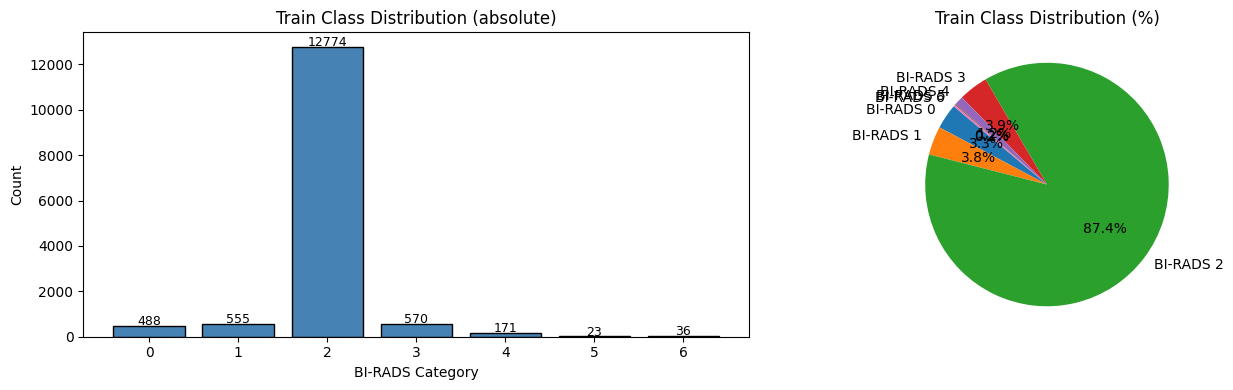


Train class counts:
target
0      488
1      555
2    12774
3      570
4      171
5       23
6       36
Name: count, dtype: int64


In [6]:
# ── Class distribution ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

counts = train_df["target"].value_counts().sort_index()
axes[0].bar(counts.index.astype(str), counts.values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("BI-RADS Category")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Class Distribution (absolute)")
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 30, str(v), ha="center", fontsize=9)

axes[1].pie(counts.values, labels=[f"BI-RADS {c}" for c in counts.index],
            autopct="%1.1f%%", startangle=140)
axes[1].set_title("Train Class Distribution (%)")

plt.tight_layout()
plt.show()

print("\nTrain class counts:")
print(counts)

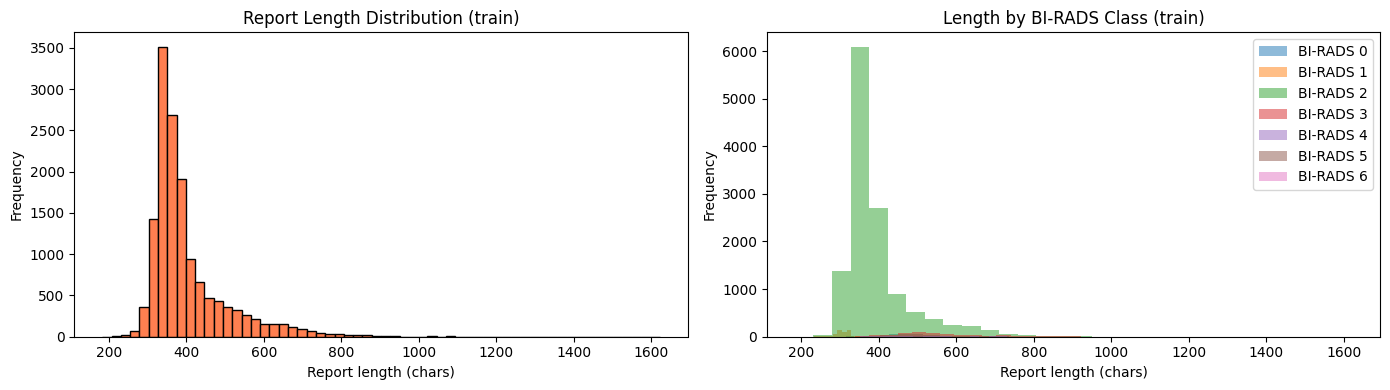

count    14617.000000
mean       400.619074
std        103.531591
min        183.000000
25%        332.000000
50%        363.000000
75%        423.000000
max       1622.000000
Name: char_len, dtype: float64


In [7]:
# ── Report length analysis ────────────────────────────────────────────────────
train_df["char_len"] = train_df["report"].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(train_df["char_len"], bins=60, color="coral", edgecolor="black")
axes[0].set_xlabel("Report length (chars)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Report Length Distribution (train)")

for cls in sorted(train_df["target"].unique()):
    subset = train_df[train_df["target"] == cls]["char_len"]
    axes[1].hist(subset, bins=30, alpha=0.5, label=f"BI-RADS {cls}")
axes[1].set_xlabel("Report length (chars)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Length by BI-RADS Class (train)")
axes[1].legend()

plt.tight_layout()
plt.show()

print(train_df["char_len"].describe())

In [8]:
# ── Duplicate reports ──────────────────────────────────────────────────────────
n_dup = train_df["report"].duplicated().sum()
print(f"Duplicate reports in train: {n_dup} ({n_dup/len(train_df)*100:.1f}%)")

# Check if duplicates have consistent labels
dup_mask = train_df["report"].duplicated(keep=False)
dup_df = train_df[dup_mask].groupby("report")["target"].nunique()
inconsistent = (dup_df > 1).sum()
print(f"Duplicated reports with inconsistent labels: {inconsistent}")

# ── Check for train/test leakage ───────────────────────────────────────────────
overlap = set(train_df["report"]) & set(test_df["report"])
print(f"\nTrain/test report overlap: {len(overlap)} reports")
if overlap:
    print("  ⚠ Leakage detected — consider deduplicating data.csv before splitting")
else:
    print("  ✓ No leakage")

Duplicate reports in train: 7191 (49.2%)
Duplicated reports with inconsistent labels: 9

Train/test report overlap: 417 reports
  ⚠ Leakage detected — consider deduplicating data.csv before splitting


## 5. Dataset & Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ── Check actual token lengths ─────────────────────────────────────────────────
sample_tokens = tokenizer(
    train_df["report"].tolist()[:500],
    truncation=False,
    return_length=True,
)["length"]
print(f"Token length stats (first 500 train samples):")
print(f"  Mean: {np.mean(sample_tokens):.0f}")
print(f"  Max:  {np.max(sample_tokens)}")
print(f"  P95:  {np.percentile(sample_tokens, 95):.0f}")
print(f"  P99:  {np.percentile(sample_tokens, 99):.0f}")
print(f"  Pct > 512: {np.mean(np.array(sample_tokens) > 512)*100:.1f}%")

Token length stats (first 500 train samples):
  Mean: 91
  Max:  475
  P95:  151
  P99:  187
  Pct > 512: 0.0%


In [10]:
class MammographyDataset(Dataset):
    """PyTorch Dataset for mammography reports."""

    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {
            "input_ids":      encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }
        if "token_type_ids" in encoding:
            item["token_type_ids"] = encoding["token_type_ids"].squeeze(0)
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## 6. Class Weights (handle imbalance)

In [11]:
def make_balanced_class_weights(y, num_classes, device):
    """Balanced class weights: n_samples / (n_present_classes * n_class)."""
    y = np.asarray(y, dtype=np.int64)
    counts = np.bincount(y, minlength=num_classes)

    weights = np.ones(num_classes, dtype=np.float32)
    present_mask = counts > 0
    n_present = int(present_mask.sum())

    if n_present > 0:
        n_samples = int(counts[present_mask].sum())
        weights[present_mask] = n_samples / (n_present * counts[present_mask])

    return torch.tensor(weights, dtype=torch.float, device=device), counts


# Preview weights on full train split (actual training uses fold-specific weights)
class_weights_tensor, class_counts = make_balanced_class_weights(
    train_df["target"].values,
    num_classes=NUM_CLASSES,
    device=DEVICE,
)

print("Class weights preview (balanced):")
for i, w in enumerate(class_weights_tensor.cpu().numpy()):
    print(f"  BI-RADS {i}: {w:.3f}  (n={int(class_counts[i])})")



Class weights preview (balanced):
  BI-RADS 0: 4.279  (n=488)
  BI-RADS 1: 3.762  (n=555)
  BI-RADS 2: 0.163  (n=12774)
  BI-RADS 3: 3.663  (n=570)
  BI-RADS 4: 12.211  (n=171)
  BI-RADS 5: 90.789  (n=23)
  BI-RADS 6: 58.004  (n=36)


## 7. Training & Validation Functions

In [12]:
def train_epoch(model, loader, optimizer, scheduler, criterion, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(loader, desc="Train", leave=False)):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels) / accum_steps
        loss.backward()

        if (step + 1) % accum_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Val", leave=False):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    bal_acc  = balanced_accuracy_score(all_labels, all_preds)
    return avg_loss, bal_acc, all_labels, all_preds

## 8. Cross-Validation Training

Cross-validation runs **only on `train_df`**. The held-out `test_df` is never seen during training.

In [13]:
texts  = train_df["report"].tolist()
labels = train_df["target"].tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_preds  = np.zeros((len(train_df), NUM_CLASSES))  # Out-of-fold probabilities
fold_scores = []
history     = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n{'='*60}")
    print(f"  FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*60}")

    # ── Datasets ───────────────────────────────────────────────────────────────
    train_texts  = [texts[i]  for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts    = [texts[i]  for i in val_idx]
    val_labels   = [labels[i] for i in val_idx]

    train_ds = MammographyDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds   = MammographyDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False,
                              num_workers=0, pin_memory=False)

    # ── Model ──────────────────────────────────────────────────────────────────
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    # ── Optimizer & scheduler ──────────────────────────────────────────────────
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )
    total_steps  = len(train_loader) // ACCUM_STEPS * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    if USE_CLASS_WEIGHTS:
        fold_class_weights, fold_class_counts = make_balanced_class_weights(
            train_labels,
            num_classes=NUM_CLASSES,
            device=DEVICE,
        )
        criterion = nn.CrossEntropyLoss(weight=fold_class_weights)
        print("  Fold class weights:")
        for i, w in enumerate(fold_class_weights.cpu().numpy()):
            print(f"    BI-RADS {i}: {w:.3f}  (n={int(fold_class_counts[i])})")
    else:
        criterion = nn.CrossEntropyLoss()

    # ── Training loop ──────────────────────────────────────────────────────────
    best_val_acc  = 0
    best_model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    fold_history = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scheduler,
                                 criterion, ACCUM_STEPS)
        val_loss, val_acc, val_true, val_pred = eval_epoch(model, val_loader, criterion)

        fold_history.append({
            "fold": fold+1, "epoch": epoch+1,
            "train_loss": train_loss, "val_loss": val_loss, "val_bal_acc": val_acc,
        })

        print(f"  Epoch {epoch+1}/{EPOCHS} — "
              f"train_loss: {train_loss:.4f}  "
              f"val_loss: {val_loss:.4f}  "
              f"val_bal_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"    ✓ New best model saved (bal_acc={best_val_acc:.4f})")

    # ── OOF predictions from best model ───────────────────────────────────────
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()

    all_oof_probs = []
    with torch.no_grad():
        for batch in DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            all_oof_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    oof_preds[val_idx] = np.concatenate(all_oof_probs, axis=0)
    fold_scores.append(best_val_acc)
    history.extend(fold_history)

    print(f"\n  Fold {fold+1} best balanced accuracy: {best_val_acc:.4f}")
    del model
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"CV Balanced Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"Per-fold scores: {[f'{s:.4f}' for s in fold_scores]}")





  FOLD 1/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 21290.88it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                           | 1/103 [00:00<00:01, 87.32it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                      | 2/103 [00:00<00:01, 88.90it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                      | 2/103 [00:00<00:01, 75.65it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:01, 92.69it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:01, 77.19it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:01, 75.72it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:01, 69.35it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:01, 75.73it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:01, 65.33it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:01, 66.79it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:01, 64.11it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▊                                                                                                                                                                                                                                       | 7/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 33/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 33/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 34/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 34/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 35/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 35/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 36/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 36/103 [00:00<00:01, 66.22it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 37/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 37/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 38/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 38/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 39/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 39/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 40/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 40/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 41/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 41/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 42/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 42/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 43/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 43/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 44/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 44/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 45/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 45/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 46/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 46/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 47/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 47/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 48/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 48/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 49/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 49/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 50/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 50/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 51/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 51/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 52/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 52/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 53/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 53/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 54/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 54/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 55/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 55/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 56/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 56/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 57/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 57/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 58/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 58/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 59/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 59/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 60/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 60/103 [00:00<00:00, 66.22it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 61/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 336.42it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 336.42it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 336.42it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 336.42it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 336.42it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 379.58it/s, Materializing param=bert.pooler.dense.weight]

BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:03<46:14,  3.80s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:05<29:05,  2.39s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:06<22:27,  1.85s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:07<19:32,  1.61s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:08<17:44,  1.47s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:10<16:49,  1.39s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:11<16:04,  1.33s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:12<15:46,  1.31s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:13<15:27,  1.29s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:15<15:24,  1.28s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:16<15:06,  1.26s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:17<15:10,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:18<14:58,  1.25s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:20<15:13,  1.27s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:21<15:05,  1.26s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:23<16:52,  1.42s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:24<16:17,  1.37s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:25<16:05,  1.35s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:26<15:46,  1.33s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:28<15:37,  1.32s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:29<15:27,  1.31s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:30<15:30,  1.31s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:32<15:18,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:33<15:16,  1.30s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:34<15:03,  1.28s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:36<15:11,  1.29s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:37<15:01,  1.28s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:38<14:59,  1.28s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:39<14:48,  1.27s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:41<14:50,  1.27s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:42<14:35,  1.25s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:43<14:41,  1.26s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:44<14:31,  1.25s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:46<14:30,  1.25s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:47<14:20,  1.24s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:48<14:25,  1.25s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:49<14:23,  1.24s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:50<14:23,  1.25s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:52<14:19,  1.24s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:53<14:22,  1.25s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:55<15:55,  1.39s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:56<15:27,  1.35s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:57<14:57,  1.30s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:58<14:46,  1.29s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [01:00<14:29,  1.27s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [01:01<14:24,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:02<14:13,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:03<14:13,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:05<14:03,  1.24s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:06<14:05,  1.24s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:07<13:59,  1.23s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:08<14:01,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:09<13:54,  1.23s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:11<13:57,  1.24s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:12<13:50,  1.23s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<13:53,  1.24s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<13:47,  1.23s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:16<13:51,  1.23s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<13:44,  1.23s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<13:48,  1.24s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<13:42,  1.23s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<13:46,  1.24s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<13:40,  1.23s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<13:45,  1.24s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:39,  1.23s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:26<13:43,  1.24s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<15:15,  1.38s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:50,  1.34s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:30<14:23,  1.30s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<14:13,  1.29s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:56,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:53,  1.27s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<13:41,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:33,  1.24s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:36,  1.25s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<13:28,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<13:31,  1.24s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:23,  1.23s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:27,  1.24s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<13:19,  1.23s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<13:23,  1.24s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:17,  1.23s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:21,  1.24s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:16,  1.23s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:19,  1.24s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:12,  1.23s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:17,  1.24s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:12,  1.23s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:16,  1.24s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:11,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:15,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:09,  1.24s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<14:47,  1.39s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<14:12,  1.34s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:56,  1.32s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:36,  1.29s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:30,  1.28s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:17,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:15,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:07,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<12:59,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:01,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:55,  1.24s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<12:58,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:51,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:18<12:55,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:49,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:52,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:46,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:23<12:50,  1.24s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:44,  1.24s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:48,  1.24s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:27<12:41,  1.24s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:28<12:45,  1.24s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:38,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:31<12:42,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:32<12:36,  1.24s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:34<14:09,  1.39s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:35<13:37,  1.34s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:36<13:21,  1.32s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<13:02,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:39<12:57,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:40<12:44,  1.26s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:41<12:43,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:34,  1.25s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:44<12:35,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:45<12:27,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:46<12:30,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:47<12:23,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:49<12:26,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:50<12:19,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:51<12:21,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:52<12:14,  1.23s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:54<12:15,  1.24s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:55<12:09,  1.23s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:56<12:11,  1.23s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:57<12:05,  1.22s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [02:59<12:10,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:00<12:06,  1.23s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:01<12:10,  1.24s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:02<12:05,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:04<12:15,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:05<12:09,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:07<13:50,  1.42s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:08<13:13,  1.36s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:09<12:59,  1.34s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:10<12:38,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:12<12:30,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:13<12:16,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:14<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:15<12:05,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:17<12:06,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:18<12:00,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:19<12:08,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:20<12:04,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:22<12:03,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:23<11:54,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:24<11:58,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:25<11:51,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:27<11:52,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:28<11:50,  1.25s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:29<11:51,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:30<11:43,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:32<11:46,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:33<11:41,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:34<11:44,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:35<11:38,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:37<11:42,  1.25s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:38<13:06,  1.40s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:40<12:46,  1.37s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:41<12:22,  1.33s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:42<12:13,  1.32s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:43<11:57,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:45<11:58,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:46<11:49,  1.28s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:47<11:48,  1.28s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:48<11:35,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:50<11:36,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:51<11:24,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:52<11:22,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:53<11:16,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:55<11:36,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:56<11:34,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:57<11:32,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [03:59<11:22,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:00<11:27,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:01<11:19,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:02<11:20,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:04<11:14,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:05<11:17,  1.26s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:06<11:11,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:07<11:14,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:09<11:08,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:10<11:11,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:12<12:42,  1.43s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:13<12:18,  1.39s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:14<11:52,  1.34s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:16<11:55,  1.35s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:17<11:43,  1.33s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:18<11:34,  1.31s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:19<11:22,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:21<11:17,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:22<11:02,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:23<10:57,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:24<10:48,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:25<10:49,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:27<10:45,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:28<10:49,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:29<10:51,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:31<11:00,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:32<10:52,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:33<10:57,  1.27s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:34<10:49,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:36<10:49,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:37<10:42,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:38<10:48,  1.26s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:39<10:43,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:41<10:45,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:42<10:39,  1.25s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:43<10:43,  1.26s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:45<12:02,  1.42s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:46<11:41,  1.38s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:47<11:18,  1.34s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:49<11:09,  1.33s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:50<10:55,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:51<10:59,  1.31s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:53<10:46,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:54<10:42,  1.28s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:55<10:32,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:56<10:33,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [04:58<10:27,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [04:59<10:28,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:00<10:22,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:01<10:22,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:03<10:12,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:04<10:11,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:05<10:04,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:06<10:09,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:08<10:06,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:09<10:11,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:10<10:08,  1.25s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:11<10:11,  1.26s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:13<10:06,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:14<10:10,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:15<10:05,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:17<11:23,  1.41s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:18<10:56,  1.36s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:19<10:45,  1.34s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:21<10:29,  1.31s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:22<10:32,  1.32s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:23<10:26,  1.31s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:25<10:21,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:26<10:08,  1.28s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:27<10:06,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:28<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:29<09:47,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:31<09:44,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:32<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:33<09:45,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:34<09:49,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:36<09:45,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:37<09:48,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:38<09:44,  1.25s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:40<09:45,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:41<09:46,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:42<09:47,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:43<09:41,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:45<09:43,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:46<09:38,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:47<09:40,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:48<09:35,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:50<10:57,  1.44s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:51<10:31,  1.38s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:53<10:19,  1.36s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:54<10:04,  1.33s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:55<09:59,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:57<09:48,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [05:58<09:44,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [05:59<09:35,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:00<09:34,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:02<09:26,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:03<09:27,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:04<09:22,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:05<09:24,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:07<09:16,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:08<09:15,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:09<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:10<09:11,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:12<09:09,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:13<09:13,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:14<09:10,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:15<09:12,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:17<09:08,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:18<09:10,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:19<09:05,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:20<09:08,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:22<09:03,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:24<10:15,  1.43s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:25<09:51,  1.38s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:26<09:39,  1.35s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:27<09:24,  1.32s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:29<09:23,  1.32s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:30<09:15,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:31<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:32<08:56,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:34<08:53,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:35<08:44,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:36<08:44,  1.24s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:37<08:42,  1.24s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:39<08:46,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:40<08:42,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:41<08:52,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:42<08:46,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:44<08:54,  1.29s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:45<08:48,  1.28s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:46<08:46,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:48<08:42,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:49<08:45,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:50<08:39,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:51<08:40,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:53<08:35,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:54<08:36,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:56<09:43,  1.44s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [06:57<09:25,  1.40s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [06:58<09:15,  1.37s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:00<09:06,  1.36s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:01<08:52,  1.32s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:02<08:55,  1.34s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:04<08:42,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:05<08:37,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:06<08:31,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:07<08:31,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:09<08:24,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:10<08:25,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:11<08:19,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:12<08:15,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:14<08:11,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:15<08:10,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:16<08:02,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:17<08:07,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:19<08:04,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:20<08:07,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:21<08:04,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:22<08:06,  1.26s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:24<08:02,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:25<08:05,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:26<08:02,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:28<09:03,  1.43s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:29<08:42,  1.38s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:31<08:34,  1.36s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:32<08:20,  1.33s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:33<08:15,  1.31s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:34<08:06,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:36<08:08,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:37<07:57,  1.28s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:38<07:51,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:39<07:43,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:41<07:43,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:42<07:41,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:43<07:51,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:44<07:46,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:46<07:46,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:47<07:43,  1.27s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:48<07:45,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:50<07:41,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:51<07:41,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:52<07:36,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:53<07:38,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:55<07:33,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:56<07:35,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [07:57<07:30,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [07:58<07:36,  1.28s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:00<07:32,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:02<08:37,  1.46s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:03<08:14,  1.40s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:04<08:04,  1.37s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:05<07:51,  1.34s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:07<07:45,  1.33s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:08<07:34,  1.30s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:09<07:31,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:10<07:23,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:12<07:21,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:13<07:16,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:14<07:18,  1.27s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:15<07:19,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:17<07:16,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:18<07:09,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:19<07:08,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:20<07:03,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:22<07:03,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:23<07:12,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:24<07:16,  1.30s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:26<07:09,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:27<07:12,  1.29s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:28<07:06,  1.28s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:29<07:04,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:31<06:58,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:32<07:03,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:34<07:54,  1.44s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:35<07:38,  1.39s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:36<07:23,  1.35s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:38<07:17,  1.34s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:39<07:08,  1.31s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:40<07:03,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:41<06:59,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:43<06:56,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:44<06:50,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:45<06:49,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:47<06:43,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:48<06:47,  1.28s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:49<06:42,  1.27s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:50<06:40,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:52<06:34,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:53<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:54<06:31,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:55<06:33,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [08:57<06:31,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [08:58<06:33,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [08:59<06:30,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:00<06:31,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:02<06:28,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:03<06:30,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:04<06:26,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:05<06:27,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:07<07:16,  1.43s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:09<07:02,  1.40s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:10<06:49,  1.36s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:11<06:43,  1.34s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:12<06:33,  1.31s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:14<06:29,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:15<06:22,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:16<06:20,  1.28s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:17<06:15,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:19<06:14,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:20<06:10,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:21<06:10,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:22<06:06,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:24<06:05,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:25<06:00,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:26<06:00,  1.25s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:27<06:02,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:29<06:03,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:30<05:59,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:31<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:32<05:56,  1.26s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:34<05:58,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:35<05:55,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:36<05:57,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:38<05:54,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:39<06:42,  1.44s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:41<06:26,  1.39s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:42<06:19,  1.37s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:43<06:08,  1.34s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:45<06:03,  1.32s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:46<05:57,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:47<05:53,  1.30s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:48<05:46,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:50<05:44,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:51<05:39,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:52<05:38,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:53<05:35,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:55<05:36,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:56<05:33,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [09:57<05:34,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [09:58<05:31,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:00<05:34,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:01<05:30,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:02<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:03<05:28,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:05<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:06<05:25,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:07<05:26,  1.27s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:09<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:10<05:24,  1.27s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:11<05:21,  1.27s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:13<06:03,  1.44s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:14<05:48,  1.38s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:15<05:40,  1.36s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:17<05:30,  1.32s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:18<05:26,  1.31s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:19<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:21<05:19,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:22<05:15,  1.28s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:23<05:14,  1.28s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:24<05:09,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:26<05:09,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:27<05:07,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:28<05:07,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:29<05:03,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:31<05:02,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:32<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:33<05:00,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:34<04:56,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:36<04:56,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:37<04:53,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:38<05:00,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:40<04:55,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:41<04:57,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:42<04:55,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:43<04:53,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:45<05:22,  1.42s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:46<05:14,  1.39s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:48<05:03,  1.34s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:49<04:57,  1.32s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:50<04:51,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:52<04:49,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:53<04:43,  1.28s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:54<04:41,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:55<04:37,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [10:57<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [10:58<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [10:59<04:34,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:00<04:31,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:02<04:33,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:03<04:30,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:04<04:31,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:05<04:28,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:07<04:28,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:08<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:09<04:25,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:10<04:22,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:12<04:22,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:13<04:22,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:14<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:16<04:17,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:17<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:19<04:49,  1.43s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:20<04:42,  1.41s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:21<04:32,  1.36s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:22<04:26,  1.34s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:24<04:19,  1.31s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:25<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:26<04:08,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:27<04:07,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:29<04:04,  1.26s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:30<04:04,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:31<04:01,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:33<04:03,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:34<04:00,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:35<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:36<03:57,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:38<03:57,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:39<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:40<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:41<03:57,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:43<03:57,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:44<03:52,  1.28s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:45<03:51,  1.28s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:47<03:47,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:48<03:48,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:49<03:46,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:51<04:17,  1.45s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:52<04:05,  1.40s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:54<03:59,  1.37s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:55<03:51,  1.33s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:56<03:48,  1.32s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [11:57<03:42,  1.29s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [11:59<03:40,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:00<03:36,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:01<03:35,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:02<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:04<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:05<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:06<03:29,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:07<03:27,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:09<03:26,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:10<03:24,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:11<03:24,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:12<03:21,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:14<03:21,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:15<03:19,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:16<03:19,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:18<03:16,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:19<03:16,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:20<03:14,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:21<03:14,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:23<03:11,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:24<03:35,  1.43s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:26<03:25,  1.37s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:27<03:20,  1.34s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:28<03:14,  1.31s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:29<03:12,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:31<03:08,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:32<03:07,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:33<03:04,  1.28s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:35<03:03,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:36<03:00,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:37<02:59,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:38<02:57,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:40<02:57,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:41<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:42<02:54,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:43<02:51,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:45<02:52,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:46<02:49,  1.27s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:47<02:49,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:48<02:46,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:50<02:46,  1.27s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:51<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:52<02:43,  1.27s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:54<02:41,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:55<02:41,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [12:57<02:59,  1.42s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [12:58<02:52,  1.38s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [12:59<02:46,  1.34s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:00<02:42,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:02<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:03<02:36,  1.29s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:04<02:33,  1.28s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:05<02:32,  1.28s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:07<02:29,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:08<02:29,  1.28s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:09<02:27,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:11<02:26,  1.28s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:12<02:24,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:13<02:23,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:14<02:21,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:16<02:20,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:17<02:18,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:18<02:19,  1.28s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:19<02:17,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:21<02:16,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:22<02:14,  1.27s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:23<02:14,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:24<02:11,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:26<02:11,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:27<02:09,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:29<02:24,  1.44s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:30<02:17,  1.37s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:31<02:14,  1.36s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:33<02:09,  1.33s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:34<02:07,  1.31s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:35<02:03,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:37<02:04,  1.31s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:38<02:01,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:39<01:59,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:40<01:57,  1.28s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:42<01:56,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:43<01:54,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:44<01:53,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:45<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:47<01:51,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:48<01:48,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:49<01:48,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:50<01:46,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:52<01:45,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:53<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:54<01:42,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:56<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [13:57<01:40,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [13:58<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [13:59<01:37,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:01<01:35,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:02<01:47,  1.43s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:04<01:41,  1.38s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:05<01:38,  1.35s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:06<01:34,  1.32s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:07<01:32,  1.31s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:09<01:30,  1.29s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:10<01:28,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:11<01:26,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:13<01:25,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:14<01:23,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:15<01:22,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:16<01:21,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:18<01:20,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:19<01:18,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:20<01:17,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:21<01:15,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:23<01:15,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:24<01:13,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:25<01:12,  1.28s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:26<01:10,  1.27s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:28<01:09,  1.27s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:29<01:08,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:30<01:07,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:32<01:05,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:33<01:04,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:35<01:11,  1.44s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:36<01:08,  1.39s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:37<01:04,  1.34s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:38<01:02,  1.33s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:40<00:59,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:41<00:58,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:42<00:56,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:44<00:55,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:45<00:53,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:46<00:52,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:47<00:50,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:49<00:49,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:50<00:48,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:51<00:46,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:52<00:45,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:54<00:44,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:55<00:43,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [14:56<00:42,  1.28s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [14:57<00:40,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [14:59<00:40,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:00<00:38,  1.28s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:01<00:37,  1.28s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:03<00:35,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:04<00:34,  1.27s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:05<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:06<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:08<00:34,  1.44s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:10<00:31,  1.39s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:11<00:29,  1.34s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:12<00:27,  1.33s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:13<00:26,  1.30s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:15<00:24,  1.31s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:16<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:17<00:21,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:18<00:20,  1.27s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:20<00:19,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:21<00:17,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:22<00:16,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:23<00:15,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:25<00:13,  1.27s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:26<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:27<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:28<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:30<00:08,  1.28s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:31<00:07,  1.27s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:32<00:06,  1.28s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:34<00:05,  1.29s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:35<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:36<00:02,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:37<00:01,  1.28s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:39<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:01<02:19,  1.53s/it]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:02<01:43,  1.15s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:03<01:31,  1.03s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:04<01:26,  1.02it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:22,  1.05it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:06<01:20,  1.07it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:18,  1.08it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.10it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.10it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.11it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:12,  1.11it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:11,  1.11it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:10,  1.11it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:09,  1.11it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:06,  1.11it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:05,  1.11it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:04,  1.11it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:03,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:02,  1.11it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:57,  1.11it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.11it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.11it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:54,  1.11it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.11it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.11it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:51,  1.11it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:34<00:58,  1.06s/it]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:35<00:54,  1.01s/it]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:36<00:51,  1.02it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:37<00:49,  1.05it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:47,  1.07it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:46,  1.08it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.09it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.10it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.11it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:40,  1.11it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:39,  1.11it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.11it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:37,  1.11it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.11it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.11it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.11it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.11it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.12it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.11it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.11it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.11it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.11it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.11it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.11it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.12it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.11it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.11it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:20,  1.06s/it]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:18,  1.01s/it]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:09<00:16,  1.02it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:15,  1.05it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:14,  1.07it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.09it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.10it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:09,  1.10it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.11it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.11it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.11it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.11it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.11it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.11it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.37it/s]

  Epoch 1/4 — train_loss: 0.5519  val_loss: 0.2272  val_bal_acc: 0.3878


    ✓ New best model saved (bal_acc=0.3878)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:49,  1.22s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:07,  1.24s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:14,  1.26s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:23,  1.27s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:11,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:20,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:14,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:20,  1.27s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:12,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:15,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<17:09,  1.43s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<16:37,  1.39s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<16:04,  1.34s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:51,  1.33s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:32,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:27,  1.30s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:12,  1.28s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:30,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:17,  1.29s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:13,  1.28s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:12,  1.29s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:10,  1.28s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:15,  1.29s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:19,  1.30s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:02,  1.28s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:07,  1.29s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:59,  1.28s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:59,  1.28s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:50,  1.27s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:52,  1.27s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:45,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:48,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:41,  1.26s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:46,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:46,  1.27s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<16:44,  1.45s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<16:01,  1.39s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:40,  1.36s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<15:15,  1.32s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<15:06,  1.31s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:56,  1.30s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:55,  1.30s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:45,  1.29s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:45,  1.29s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:35,  1.28s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:36,  1.28s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:26,  1.27s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:28,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:20,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:24,  1.27s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:17,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:19,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:12,  1.26s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:16,  1.27s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:09,  1.26s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:21,  1.28s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:15,  1.27s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:21,  1.28s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:13,  1.27s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:15,  1.28s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<16:03,  1.44s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<15:32,  1.39s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<15:07,  1.36s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:56,  1.34s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:33,  1.31s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:31,  1.31s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:18,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:12,  1.29s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:09,  1.28s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:09,  1.29s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:58,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:04,  1.28s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:55,  1.27s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:55,  1.27s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:48,  1.26s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:51,  1.27s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:46,  1.26s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:52,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:49,  1.27s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:54,  1.28s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:47,  1.27s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:52,  1.28s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:46,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:48,  1.28s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:41,  1.27s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<15:12,  1.42s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:48,  1.38s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<14:22,  1.34s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<14:11,  1.33s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:55,  1.31s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:52,  1.30s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:40,  1.29s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:40,  1.29s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:31,  1.28s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:33,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:26,  1.27s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:29,  1.28s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:21,  1.27s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:27,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:21,  1.27s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:25,  1.28s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:18,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:36,  1.30s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:27,  1.29s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:30,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:18,  1.28s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:16,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:06,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:09,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:58,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<14:45,  1.43s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<14:12,  1.38s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:50,  1.35s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:29,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:22,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:06,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:12,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:00,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:57,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:49,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:53,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:45,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:57,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:49,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:49,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:50,  1.28s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:51,  1.28s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:41,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:43,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:39,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:43,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:36,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:43,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:39,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:45,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<14:23,  1.45s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<13:52,  1.40s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<13:22,  1.36s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<13:08,  1.33s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:50,  1.31s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:46,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:35,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:34,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:31,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:34,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:23,  1.27s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:22,  1.27s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:13,  1.26s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:15,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:17,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:12,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:15,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:07,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:10,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:03,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:04,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:09,  1.28s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:10,  1.28s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:07,  1.28s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:09,  1.28s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<13:43,  1.45s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<13:14,  1.40s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:46,  1.35s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:33,  1.33s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:17,  1.31s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:12,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<12:01,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:02,  1.29s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:05,  1.30s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:02,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:50,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:52,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:44,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:46,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:39,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:54,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:46,  1.28s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:50,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:47,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:45,  1.28s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:35,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:39,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:33,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:36,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:30,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<13:01,  1.44s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<12:28,  1.38s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<12:11,  1.35s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:52,  1.32s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:46,  1.31s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:35,  1.29s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:33,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:25,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:24,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:18,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:22,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:16,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:18,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:12,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:10,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:13,  1.28s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:07,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:09,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:08,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:14,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:05,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:05,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:59,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:01,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:54,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<12:24,  1.44s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:52,  1.38s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:35,  1.35s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:19,  1.32s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<11:14,  1.32s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<11:03,  1.29s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<11:01,  1.29s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:52,  1.28s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:52,  1.28s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:45,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:47,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:41,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:43,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:37,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:40,  1.27s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:33,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:36,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:31,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:33,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:28,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:45,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:39,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:36,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:33,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:33,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<12:00,  1.47s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<11:38,  1.42s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<11:08,  1.37s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<11:03,  1.36s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:44,  1.32s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:36,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:24,  1.28s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:29,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:19,  1.28s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:22,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:14,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:14,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:08,  1.27s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<10:09,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:07,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:08,  1.28s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<10:02,  1.27s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:03,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:57,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:01,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<09:58,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:01,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:55,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:57,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<09:52,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<11:12,  1.44s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<10:44,  1.38s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:29,  1.35s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:13,  1.32s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<10:07,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:56,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:54,  1.29s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:46,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:47,  1.28s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:41,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:42,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:36,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:37,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:39,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:39,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:34,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:28,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:29,  1.27s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:31,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:32,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:25,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:26,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:20,  1.26s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:22,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:17,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<10:36,  1.44s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<10:12,  1.39s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:58,  1.36s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:43,  1.33s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:36,  1.32s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:26,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:23,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:09,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:10,  1.28s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:04,  1.27s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:11,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<09:05,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:04,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:57,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:00,  1.27s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<08:58,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:00,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:54,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:56,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:51,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:53,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:48,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:49,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<09:58,  1.44s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<09:38,  1.39s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<09:20,  1.35s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<09:12,  1.34s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:00,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:57,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:49,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:47,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:39,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:39,  1.28s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:32,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:33,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:28,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:33,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:28,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:30,  1.27s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:25,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:26,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:21,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:23,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:18,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:20,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:16,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:18,  1.27s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:14,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<09:27,  1.45s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<09:01,  1.39s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:49,  1.36s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:36,  1.33s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:32,  1.32s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:23,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:22,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:15,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:12,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:05,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:04,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<07:58,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:00,  1.27s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:57,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:58,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<07:54,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:55,  1.27s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:51,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:52,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:48,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:50,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:45,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:47,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:43,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:49,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:45,  1.27s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<08:51,  1.46s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:55<08:27,  1.39s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<08:15,  1.36s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<08:01,  1.33s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:58,  1.32s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:51,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:49,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:41,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:40,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:33,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:33,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:27,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<07:28,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:22,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:26,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:22,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:21,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:16,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:17,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:21,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:16,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:17,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:16,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:16,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:26<08:10,  1.44s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:54,  1.40s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:39,  1.36s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:32,  1.34s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:22,  1.32s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:20,  1.31s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:11,  1.29s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:12,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:08,  1.29s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:07,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:01,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:00,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:56,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:56,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:50,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:50,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:46,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:46,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:42,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:41,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:43,  1.27s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:40,  1.26s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:42,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:38,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:41,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<07:39,  1.46s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:01<07:24,  1.42s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<07:09,  1.38s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<07:01,  1.36s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:52,  1.33s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:47,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:44,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:43,  1.32s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:10<06:34,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:36,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:29,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:27,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:24,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:23,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:15,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:14,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:13,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:14,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:14,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:16,  1.28s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:11,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:15,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:11,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<06:11,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:06,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:32<07:00,  1.46s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:50,  1.43s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:40,  1.40s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:36<06:26,  1.35s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:21,  1.34s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:12,  1.31s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:08,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<06:01,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<06:00,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:55,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:54,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<05:55,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:54,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:47,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:50<05:53,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<05:47,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:44,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:38,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<05:44,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:40,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:37,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<05:38,  1.27s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:36,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:38,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<06:24,  1.46s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<06:11,  1.41s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:07<06:03,  1.39s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:56,  1.36s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:46,  1.33s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:11<05:44,  1.33s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<05:36,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:34,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:28,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:16<05:27,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:22,  1.27s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:22,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:18,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:21<05:17,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:12,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:11,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:07,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:08,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:06,  1.25s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:30<05:09,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:10,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:07,  1.28s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:07,  1.29s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:38<05:48,  1.47s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<05:35,  1.42s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:28,  1.39s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:42<05:21,  1.37s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:43<05:10,  1.33s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<05:10,  1.33s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:46<05:02,  1.30s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:47<04:58,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:52,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:54,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:51<04:49,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<04:49,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:45,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:44,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:56<04:40,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<04:39,  1.26s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:36,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:36,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:01<04:34,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:39,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:38,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:05<04:37,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:06<04:33,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:35,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:31,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<05:14,  1.47s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:12<04:59,  1.41s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:13<04:51,  1.38s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:14<04:48,  1.37s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:16<04:42,  1.35s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:17<04:35,  1.33s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<04:32,  1.32s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:25,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:21<04:22,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:22<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:17,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:16,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:26<04:15,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:27<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:13,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:08,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:31<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:03,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:05,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:05,  1.27s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:36<04:05,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<04:02,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:40<04:00,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:41<03:59,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:43<04:33,  1.46s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:44<04:26,  1.43s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:45<04:16,  1.38s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:47<04:11,  1.36s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:48<04:08,  1.35s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:49<04:03,  1.33s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:56,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:52<03:54,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:53<03:51,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:49,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:56<03:45,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:57<03:44,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:58<03:42,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:41,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:01<03:37,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:02<03:36,  1.25s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:03<03:33,  1.24s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:34,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:06<03:33,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:07<03:33,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:31,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:11<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<03:29,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<03:26,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:26,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:16<03:56,  1.46s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:18<03:47,  1.41s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:19<03:43,  1.40s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:20<03:38,  1.37s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:22<03:29,  1.33s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:23<03:26,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:24<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:27<03:16,  1.28s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:28<03:15,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:29<03:12,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:11,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:32<03:08,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:33<03:07,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:34<03:04,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:04,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:37<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:38<03:02,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:00,  1.25s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<03:03,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:42<03:00,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<02:59,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<03:01,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:46<03:00,  1.30s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:47<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:49<03:23,  1.49s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:50<03:13,  1.42s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<03:07,  1.39s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:53<03:00,  1.35s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:54<02:56,  1.33s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:55<02:54,  1.32s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:57<02:51,  1.31s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:58<02:46,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:59<02:44,  1.28s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:00<02:43,  1.28s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:02<02:42,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:03<02:39,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:04<02:38,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:36,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:07<02:35,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:08<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:09<02:32,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:31,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:12<02:30,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:13<02:28,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:28,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:26,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:17<02:27,  1.29s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:18<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:24,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:21<02:44,  1.47s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:23<02:38,  1.42s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:24<02:32,  1.39s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:25<02:28,  1.36s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:26<02:23,  1.32s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:28<02:21,  1.33s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:29<02:17,  1.30s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:30<02:15,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:12,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:33<02:11,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:34<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:35<02:07,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:05,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:38<02:04,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:39<02:01,  1.24s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:01,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<01:59,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:43<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:44<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<01:57,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:47<01:56,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:48<01:55,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:49<01:53,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:50<01:53,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:52<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:53<01:51,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:55<02:06,  1.47s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:56<02:01,  1.43s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:57<01:55,  1.38s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:59<01:52,  1.35s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:00<01:48,  1.32s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:01<01:45,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<01:42,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:04<01:41,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:05<01:39,  1.27s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:06<01:37,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:35,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:09<01:35,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:10<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:32,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:13<01:30,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:14<01:31,  1.29s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:15<01:28,  1.27s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:28,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:18<01:26,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:19<01:25,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:20<01:23,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:22<01:23,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:23<01:21,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:24<01:20,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:18,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:27<01:28,  1.46s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:28<01:23,  1.39s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:30<01:20,  1.37s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:31<01:17,  1.33s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:32<01:15,  1.32s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:34<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:35<01:11,  1.29s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:36<01:09,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:37<01:08,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:39<01:06,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:40<01:05,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:41<01:03,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:43<01:02,  1.28s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:44<01:00,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:45<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:46<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:48<00:57,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:49<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:50<00:54,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:51<00:53,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:53<00:52,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:54<00:50,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:55<00:49,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:47,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:58<00:47,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:59<00:45,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:01<00:52,  1.49s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:02<00:48,  1.43s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:04<00:45,  1.38s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:05<00:42,  1.34s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:06<00:41,  1.32s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:07<00:39,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:09<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:10<00:35,  1.28s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:11<00:34,  1.28s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:12<00:33,  1.28s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:14<00:32,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:15<00:30,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:16<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:17<00:27,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:19<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:20<00:25,  1.27s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:21<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:23<00:22,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:24<00:21,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:25<00:20,  1.27s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:26<00:19,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:28<00:17,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:29<00:16,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:30<00:15,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:32<00:13,  1.27s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:33<00:14,  1.44s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:35<00:12,  1.39s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:36<00:10,  1.35s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:37<00:09,  1.33s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:38<00:08,  1.33s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:40<00:06,  1.33s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:41<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:42<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:44<00:02,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:45<00:01,  1.28s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:46<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.11it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:17,  1.11it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:16,  1.11it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:15,  1.11it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:14,  1.12it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.12it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.12it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.12it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.12it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.12it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:15,  1.08s/it]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:10,  1.03s/it]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:06,  1.02it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:04,  1.04it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:02,  1.06it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:00,  1.08it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:59,  1.08it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.10it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:54,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.11it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.11it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:51,  1.11it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.11it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.11it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:42,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:41,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.12it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.12it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.12it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:33,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.12it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:36,  1.08s/it]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:33,  1.03s/it]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:31,  1.01it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:29,  1.04it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:28,  1.06it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.08it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.10it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.10it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.11it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.11it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.11it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.11it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.11it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.11it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.11it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.11it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.11it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.38it/s]

  Epoch 2/4 — train_loss: 0.2074  val_loss: 0.1924  val_bal_acc: 0.4105


    ✓ New best model saved (bal_acc=0.4105)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:48,  1.22s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:21,  1.26s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:21,  1.27s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:23,  1.27s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:12,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:20,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:14,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:18,  1.27s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:10,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:15,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<15:07,  1.26s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:11,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:04,  1.26s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<15:09,  1.27s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:18<15:02,  1.26s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:06,  1.27s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:21<14:59,  1.26s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:22<15:03,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:23<14:56,  1.26s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:01,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:26<15:01,  1.27s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:27<15:03,  1.27s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:54,  1.26s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:57,  1.27s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:31<14:50,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<17:07,  1.46s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<16:20,  1.39s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<16:06,  1.38s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:37,  1.34s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:25,  1.32s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<15:15,  1.31s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:10,  1.30s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:58,  1.29s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<15:00,  1.29s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:52,  1.28s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:51,  1.28s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:40,  1.27s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:42,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:33,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:44,  1.28s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:52<14:35,  1.27s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:53<14:38,  1.27s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:28,  1.26s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:31,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:57<14:24,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:45,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:35,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:01<14:39,  1.29s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:02<14:37,  1.29s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:34,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<16:31,  1.46s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<15:57,  1.41s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<15:23,  1.36s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<15:08,  1.34s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:47,  1.31s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:42,  1.31s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:29,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:26,  1.29s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:14,  1.27s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:15,  1.27s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:07,  1.26s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:09,  1.27s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:01,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:10,  1.28s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<14:03,  1.27s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:06,  1.27s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<13:58,  1.26s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:02,  1.27s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:28<13:55,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:59,  1.27s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:54,  1.26s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:32<13:57,  1.27s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:33<13:59,  1.28s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:02,  1.28s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:53,  1.27s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:37<13:54,  1.27s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<15:49,  1.45s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<15:15,  1.40s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:42,  1.35s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:27,  1.33s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<14:10,  1.31s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<14:07,  1.31s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:57,  1.29s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:55,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:45,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:42,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:45,  1.28s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:37,  1.27s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:38,  1.28s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:31,  1.27s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:34,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:29,  1.27s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:32,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:25,  1.27s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:31,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:36,  1.29s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:39,  1.29s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:25,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:08<13:30,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:22,  1.27s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<15:23,  1.47s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<14:39,  1.40s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<14:17,  1.37s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:52,  1.33s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:42,  1.32s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:27,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:24,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:15,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:17,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:09,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:13,  1.28s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:05,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:08,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:01,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<13:04,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:58,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:00,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:52,  1.26s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:34<12:55,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:49,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:52,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:48,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:55,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:47,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:50,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<14:44,  1.46s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<14:11,  1.41s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<13:39,  1.36s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<13:23,  1.34s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<13:14,  1.32s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<13:07,  1.31s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:52,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:49,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:39,  1.27s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:40,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:30,  1.26s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:37,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:30,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:32,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:25,  1.26s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:28,  1.27s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:22,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:26,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:19,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:23,  1.27s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:16,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:21,  1.27s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:14,  1.26s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:17,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:16,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<14:02,  1.46s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<13:32,  1.41s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<13:03,  1.36s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:50,  1.34s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:32,  1.31s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:27,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:15,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:14,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:23,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:24,  1.31s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<12:09,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:05,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:57,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:59,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:51,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:54,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:55,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<12:01,  1.29s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:53,  1.27s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:52,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:57,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<12:00,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:47,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:52,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:45,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<13:32,  1.47s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<12:54,  1.40s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<12:34,  1.37s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<12:10,  1.33s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<12:02,  1.32s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:41,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:39,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:35,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:38,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:26,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:29,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:22,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:24,  1.27s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:17,  1.26s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:20,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:16,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:19,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:13,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:16,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:11,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:15,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:15,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<12:51,  1.46s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<12:24,  1.41s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:57,  1.36s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:43,  1.34s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:28<11:26,  1.31s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:20,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:09,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:16,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:07,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:06,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:58,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<11:01,  1.28s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:00,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:02,  1.29s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:55,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:58,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:52,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:53,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:51,  1.28s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:53,  1.28s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:47,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:47,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:38,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:32,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:21,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:35,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<12:07,  1.45s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<11:41,  1.40s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:59<11:16,  1.35s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<11:04,  1.33s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:49,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:46,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<10:36,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:36,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:29,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:30,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:24,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:26,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:20,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:23,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:17,  1.27s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:20,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:14,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:17,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:12,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:14,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:09,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:11,  1.27s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:05,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:07,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:01,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<11:34,  1.46s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<11:03,  1.39s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:47,  1.36s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:30,  1.33s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:34<10:23,  1.32s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<10:13,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:10,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:02,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<10:02,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<09:55,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:04,  1.30s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:58,  1.28s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<09:55,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:56,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:59,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:49,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:49,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:43,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:44,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:38,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:39,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:35,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:38,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:33,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:30,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<10:59,  1.46s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<10:26,  1.39s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<10:10,  1.36s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:54,  1.33s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:51,  1.32s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:38,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<09:36,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:31,  1.29s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:31,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<09:22,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:27,  1.29s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:20,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:19,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:13,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:21,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:15,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:09,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:10,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:04,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:15,  1.29s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:11,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:09,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:06,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:06,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:35<10:21,  1.46s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<09:57,  1.41s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<09:40,  1.37s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:34,  1.36s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:40<09:16,  1.32s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<09:09,  1.30s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<09:02,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:44<09:01,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<08:54,  1.28s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:54,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<08:47,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<08:50,  1.28s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:45,  1.27s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:45,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:45,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:49,  1.29s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:40,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:42,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:37,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:37,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:31,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:32,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:31,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:32,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:27,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<09:46,  1.46s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<09:18,  1.40s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:10<09:03,  1.36s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:11<08:47,  1.33s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:12<08:41,  1.31s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:31,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:15<08:29,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<08:22,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:22,  1.28s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:17,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<08:18,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:13,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:18,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:12,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:13,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:07,  1.26s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:08,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:03,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:12,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:05,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:05,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<08:07,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:07,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:01,  1.27s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<08:03,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<07:57,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:41<09:09,  1.47s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:42<08:42,  1.40s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<08:30,  1.37s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<08:16,  1.33s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:46<08:09,  1.32s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:47<07:58,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<08:04,  1.31s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:50<07:55,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<07:52,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<07:47,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:55<07:41,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<07:42,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:38,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:40,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:35,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:35,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:34,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<07:35,  1.28s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:30,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:31,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:27,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<07:28,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:24,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:26,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<08:29,  1.46s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<08:10,  1.41s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:16<07:51,  1.35s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:17<07:42,  1.33s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:18<07:38,  1.33s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:32,  1.31s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:21<07:23,  1.29s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<07:21,  1.29s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:23<07:16,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:25<07:21,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:26<07:14,  1.28s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:13,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:12,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:30<07:11,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:06,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:06,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:02,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:02,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<06:58,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<06:59,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:56,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:01,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:56,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:55,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:44<06:50,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:51,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:47<07:52,  1.46s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:48<07:35,  1.41s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<07:17,  1.36s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:51<07:09,  1.34s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:52<07:01,  1.32s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:53<06:56,  1.31s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:54<06:48,  1.29s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:56<06:47,  1.28s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:57<06:41,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<06:43,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:39,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:01<06:38,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<06:34,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:35,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:31,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:32,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:28,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:29,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:10<06:26,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:27,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:23,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:24,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:20,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:22,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:18,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:19<07:17,  1.46s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:56,  1.40s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:22<06:45,  1.37s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:23<06:32,  1.33s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:24<06:27,  1.31s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:21,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:27<06:19,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:28<06:13,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<06:12,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:07,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:32<06:07,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:06,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:03,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<05:59,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<05:59,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<05:55,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<05:55,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:52,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:54,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<05:50,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:51,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:48,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:48,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<06:39,  1.46s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:53<06:23,  1.40s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:54<06:08,  1.36s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<06:01,  1.33s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:53,  1.31s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:58<05:50,  1.30s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:59<05:46,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<05:45,  1.29s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:39,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:03<05:38,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<05:34,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:34,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:07<05:30,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:27,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<05:24,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:25,  1.27s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:21,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:22,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:19,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:20,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:17,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:18,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:15,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:16,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:25<06:03,  1.46s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:48,  1.41s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:35,  1.36s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:29<05:29,  1.35s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:30<05:21,  1.32s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:18,  1.31s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:33<05:12,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:34<05:16,  1.31s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:11,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:07,  1.29s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:38<05:04,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<05:04,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:00,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<04:59,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:43<05:00,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<04:59,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<04:53,  1.26s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:47<04:55,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:51,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:50,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:46,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<04:47,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:44,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:44,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:42,  1.26s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<05:25,  1.46s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:59<05:09,  1.39s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:00<05:01,  1.36s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:01<04:51,  1.33s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:49,  1.32s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:04<04:44,  1.31s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:05<04:42,  1.30s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:06<04:36,  1.28s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:35,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:09<04:31,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<04:30,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<04:28,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:13<04:28,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:14<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:25,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:21,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<04:21,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:17,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:17,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:15,  1.25s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:13,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:14,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:16,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:12,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:31<04:50,  1.47s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:35,  1.41s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:30,  1.39s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:35<04:21,  1.35s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:36<04:18,  1.34s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:13,  1.32s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:39<04:11,  1.32s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:40<04:06,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:41<04:04,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<03:59,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:44<03:58,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:45<03:54,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<03:56,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:53,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:49<03:53,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:49,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:49,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:53<03:46,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:46,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:46,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<03:46,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:58<03:42,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:42,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:44,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:02<03:45,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:03<04:13,  1.47s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:05<04:03,  1.43s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:06<03:55,  1.38s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:07<03:48,  1.35s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:09<03:44,  1.34s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:10<03:40,  1.32s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:11<03:34,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<03:32,  1.29s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:14<03:28,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:15<03:28,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:16<03:25,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:25,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:19<03:22,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:20<03:22,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:20,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:23<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:24<03:18,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:17,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:15,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:28<03:14,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:29<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:11,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:09,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:33<03:09,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:34<03:08,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:36<03:36,  1.48s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:37<03:25,  1.41s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:39<03:20,  1.38s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:40<03:14,  1.35s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:41<03:10,  1.33s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:42<03:07,  1.32s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:44<03:05,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:45<02:59,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:46<02:59,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:47<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:49<02:55,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:50<02:53,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<02:52,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:53<02:51,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:54<02:50,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:55<02:48,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<02:47,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:58<02:45,  1.27s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:59<02:45,  1.28s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:00<02:42,  1.27s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:42,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:03<02:39,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:04<02:39,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:37,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:07<02:36,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:08<02:34,  1.27s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:10<02:57,  1.47s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:11<02:48,  1.41s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:12<02:44,  1.38s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:14<02:38,  1.34s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:15<02:35,  1.33s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:16<02:31,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:17<02:29,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:19<02:25,  1.28s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:20<02:24,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:21<02:21,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:22<02:20,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:24<02:18,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:25<02:18,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:26<02:16,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:15,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:29<02:14,  1.27s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:30<02:14,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:12,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:33<02:11,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:34<02:09,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:35<02:08,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:06,  1.27s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:38<02:05,  1.27s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:39<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:03,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:42<02:20,  1.47s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:43<02:15,  1.42s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:45<02:09,  1.38s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:46<02:06,  1.36s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:47<02:01,  1.32s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:49<01:59,  1.31s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:50<01:56,  1.30s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:51<01:55,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:52<01:52,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:54<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:55<01:48,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:56<01:47,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:57<01:45,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:59<01:45,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:00<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:01<01:42,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:04<01:40,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:05<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:06<01:38,  1.28s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:08<01:36,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:09<01:35,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:10<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:34,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:13<01:31,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:15<01:44,  1.47s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:16<01:39,  1.42s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:17<01:35,  1.39s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:18<01:31,  1.35s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:20<01:29,  1.33s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:21<01:26,  1.30s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:22<01:24,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:23<01:21,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:25<01:20,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:26<01:18,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:27<01:17,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:28<01:15,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:30<01:14,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:31<01:12,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:32<01:12,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:34<01:11,  1.28s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:35<01:11,  1.29s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:36<01:08,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:37<01:07,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:39<01:06,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:40<01:05,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:41<01:03,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:43<01:02,  1.28s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:44<01:00,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:45<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:46<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:48<01:05,  1.47s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:50<01:01,  1.41s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:51<00:59,  1.37s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:52<00:56,  1.34s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:53<00:54,  1.33s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:55<00:52,  1.31s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:56<00:50,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:57<00:48,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:58<00:47,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:00<00:45,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:01<00:44,  1.28s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:02<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:04<00:42,  1.27s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:05<00:40,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:06<00:39,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:07<00:37,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:09<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:10<00:34,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:11<00:34,  1.28s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:12<00:33,  1.28s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:14<00:31,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:15<00:30,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:16<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:17<00:27,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:19<00:26,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:21<00:29,  1.48s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:22<00:27,  1.43s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:23<00:24,  1.38s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:25<00:23,  1.36s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:26<00:21,  1.34s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:27<00:19,  1.33s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:28<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:30<00:16,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:31<00:15,  1.28s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:32<00:14,  1.28s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:33<00:12,  1.27s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:35<00:11,  1.27s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:36<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:37<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:39<00:07,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:40<00:06,  1.26s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:41<00:04,  1.24s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:42<00:03,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:44<00:02,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:45<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:46<00:00,  1.19s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:21,  1.11it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:20,  1.12it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:16,  1.11it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:34,  1.13s/it]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:27,  1.06s/it]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:23,  1.01s/it]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:19,  1.02it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:17,  1.04it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:14,  1.06it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:12,  1.07it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:10,  1.09it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:09,  1.10it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:06,  1.11it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:03,  1.12it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:02,  1.12it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.14it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:56,  1.14it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:55,  1.14it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.14it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.14it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.14it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.12it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.12it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.11it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.11it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.11it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:54,  1.13s/it]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:49,  1.06s/it]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:46,  1.01s/it]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:44,  1.02it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:42,  1.04it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:40,  1.06it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:39,  1.07it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:37,  1.08it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.10it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.11it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.14it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.13it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.12it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.12it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.12it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.11it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.11it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:13,  1.13s/it]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:11,  1.06s/it]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:10,  1.02s/it]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.02it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.04it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.06it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.07it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.09it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.10it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.10it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.11it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.37it/s]

  Epoch 3/4 — train_loss: 0.1747  val_loss: 0.1975  val_bal_acc: 0.4174


    ✓ New best model saved (bal_acc=0.4174)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<16:20,  1.34s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:26,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:55,  1.23s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:03,  1.24s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:51,  1.23s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:02,  1.24s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:57,  1.24s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:16,  1.27s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:08,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:19,  1.28s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<15:12,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:17,  1.28s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:10,  1.27s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<15:14,  1.28s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<17:37,  1.48s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<17:00,  1.43s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<16:23,  1.38s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<16:07,  1.36s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:45,  1.33s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:36,  1.32s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:18,  1.29s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:14,  1.29s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:03,  1.28s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:17,  1.30s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:05,  1.28s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:07,  1.29s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:57,  1.27s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:59,  1.28s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:49,  1.27s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:51,  1.27s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<14:44,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:48,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:41,  1.26s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:44,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:38,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:42,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:35,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:40,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:33,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:38,  1.27s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<16:34,  1.44s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<16:01,  1.39s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<15:30,  1.35s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<15:15,  1.33s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:57,  1.31s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:52,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:40,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:39,  1.29s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:29,  1.27s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:29,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:19,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:21,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:28,  1.28s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:28,  1.28s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:18,  1.27s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:20,  1.27s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:11,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:15,  1.27s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:10,  1.27s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:15,  1.27s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:04,  1.26s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:07,  1.27s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<13:59,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:12,  1.28s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<14:07,  1.27s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<16:21,  1.48s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<15:33,  1.41s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<15:07,  1.37s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:40,  1.33s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:30,  1.32s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<14:15,  1.30s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:12,  1.29s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:00,  1.28s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:59,  1.28s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:50,  1.27s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:02,  1.29s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:51,  1.27s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:52,  1.28s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:48,  1.27s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:53,  1.28s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:46,  1.27s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:48,  1.28s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:37,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:52,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:40,  1.27s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:39,  1.27s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:42,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:43,  1.28s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:34,  1.27s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:36,  1.27s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:30,  1.27s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<15:42,  1.47s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<14:57,  1.41s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<14:33,  1.37s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<14:08,  1.33s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:59,  1.32s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:43,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:40,  1.30s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:27,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:26,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:17,  1.27s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:23,  1.28s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:17,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:20,  1.28s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:11,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:14,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:11,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:15,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:05,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:17,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:08,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:08,  1.27s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:00,  1.26s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:02,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:53,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<13:04,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<15:01,  1.47s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<14:25,  1.41s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:52,  1.36s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:46,  1.35s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:26,  1.32s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:20,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:04,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:01,  1.29s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:51,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:56,  1.28s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:48,  1.27s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:48,  1.28s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:41,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:42,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:36,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:39,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:31,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:40,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:34,  1.27s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:38,  1.27s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:31,  1.27s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:34,  1.27s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:29,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:31,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:26,  1.27s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<14:29,  1.48s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<13:47,  1.41s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<13:23,  1.37s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:59,  1.33s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:50,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:51,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:46,  1.32s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:29,  1.29s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:33,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:21,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:20,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:15,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:09,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:10,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:03,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:04,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:58,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:03,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<11:57,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:01,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:55,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<11:58,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:53,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:56,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:50,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<13:47,  1.47s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<13:08,  1.40s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:47,  1.37s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:25,  1.33s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:16,  1.32s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<12:02,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:00,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:50,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:50,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:42,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:44,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:38,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:40,  1.27s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:35,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:37,  1.27s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:32,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:34,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:28,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:31,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:26,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:29,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:23,  1.26s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:25,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:21,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:33,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<13:14,  1.48s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<12:40,  1.42s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<12:21,  1.38s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<12:05,  1.36s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:44,  1.32s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:36,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:30,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<11:29,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:19,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:20,  1.29s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:12,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:12,  1.28s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:10,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:12,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:05,  1.27s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:07,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:02,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:03,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:12,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:15,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<11:03,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<11:01,  1.28s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<10:55,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:58,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:52,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:53,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<12:30,  1.47s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<12:00,  1.41s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:32,  1.36s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:20,  1.34s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:49<11:03,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<11:04,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:54,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:52,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:54<10:45,  1.28s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:46,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:39,  1.27s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:40,  1.28s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:59<10:44,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:43,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:32,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<10:33,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<10:27,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:30,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:24,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:27,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:21,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:23,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:18,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:21,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:16,  1.26s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<11:58,  1.48s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<11:21,  1.40s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<11:06,  1.37s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:20<10:49,  1.34s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:41,  1.33s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:30,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:24<10:25,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<10:16,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<10:15,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:08,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:29<10:09,  1.28s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<10:14,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:15,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:05,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:34<10:05,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<10:00,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:03,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:38<09:57,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<09:59,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<09:53,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<09:56,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<09:50,  1.27s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<09:52,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:47,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:49,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<11:18,  1.47s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<10:52,  1.42s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<10:28,  1.37s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<10:16,  1.34s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:54<10:02,  1.31s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:55<09:57,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:48,  1.29s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:52,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:59<09:44,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:00<09:44,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:38,  1.28s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:39,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:04<09:33,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<09:34,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:28,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:08<09:29,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:09<09:31,  1.28s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<09:32,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:25,  1.27s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:13<09:34,  1.30s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<09:27,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:26,  1.29s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<09:24,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:24,  1.29s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:17,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:21<10:46,  1.48s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<10:13,  1.41s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:24<09:56,  1.37s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:25<09:47,  1.35s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<09:38,  1.34s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<09:24,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:29<09:22,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:30<09:14,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<09:14,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:33<09:08,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:34<09:07,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:35<09:08,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<09:06,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:38<08:58,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:39<09:05,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:40<08:59,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:42<08:58,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:43<08:52,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:44<08:54,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<08:48,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:47<08:51,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:48<08:49,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<08:51,  1.28s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:47,  1.27s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:52<08:48,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<08:43,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:55<10:08,  1.48s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:56<09:38,  1.41s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:58<09:30,  1.40s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:59<09:11,  1.35s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:00<09:01,  1.33s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:01<08:57,  1.33s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:03<08:54,  1.32s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:04<08:43,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:05<08:42,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:06<08:39,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:08<08:37,  1.29s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:09<08:32,  1.28s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:10<08:32,  1.28s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:12<08:26,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:13<08:28,  1.28s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:14<08:23,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:15<08:24,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:17<08:19,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:18<08:27,  1.29s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:19<08:24,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:21<08:25,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:22<08:20,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:23<08:22,  1.29s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:24<08:18,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:26<08:18,  1.29s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:28<09:24,  1.46s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:29<09:03,  1.41s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:30<08:44,  1.36s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:31<08:34,  1.34s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:33<08:23,  1.32s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:34<08:19,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:35<08:12,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:37<08:11,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:38<08:05,  1.28s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:39<08:05,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:40<08:00,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:42<08:01,  1.28s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:43<07:56,  1.27s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:44<07:58,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:45<07:54,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:47<07:55,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:48<07:51,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:49<07:52,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:51<07:48,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:52<07:49,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:53<07:45,  1.27s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:54<07:46,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:56<07:42,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:57<07:44,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:58<07:40,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:00<08:49,  1.47s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:01<08:25,  1.40s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:03<08:12,  1.37s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:04<07:58,  1.34s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:05<07:53,  1.33s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:07<07:44,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:08<07:41,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:09<07:38,  1.29s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:10<07:37,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:12<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:13<07:34,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:14<07:29,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:16<07:27,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:17<07:29,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:18<07:28,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:19<07:19,  1.27s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:21<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:22<07:03,  1.23s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:23<07:09,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:24<07:08,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:26<07:12,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:27<07:09,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:28<07:12,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:29<07:09,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:31<07:10,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:32<07:06,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:34<08:31,  1.53s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:35<08:01,  1.44s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:37<07:45,  1.40s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:38<07:34,  1.37s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:39<07:26,  1.35s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:40<07:15,  1.32s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:42<07:10,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:43<07:03,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:44<07:03,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:46<06:58,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:47<06:58,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:48<06:53,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:49<06:53,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:51<06:49,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:52<06:50,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:53<06:46,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:54<06:48,  1.28s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:56<06:45,  1.27s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:57<06:46,  1.28s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:58<06:42,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:00<06:43,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:01<06:40,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:02<06:41,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:03<06:44,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:05<06:45,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:07<07:41,  1.49s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:08<07:21,  1.43s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:09<07:08,  1.39s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:11<06:56,  1.36s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:12<06:44,  1.32s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:13<06:46,  1.33s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:14<06:35,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:16<06:35,  1.31s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:17<06:30,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:18<06:28,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:20<06:23,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:21<06:23,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:22<06:17,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:23<06:18,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:25<06:15,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:26<06:15,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:27<06:12,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:28<06:12,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:30<06:09,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:31<06:10,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:32<06:06,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:34<06:07,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:35<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:36<06:06,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:37<06:03,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:39<07:00,  1.48s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:41<06:40,  1.41s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:42<06:29,  1.37s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:43<06:17,  1.34s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:44<06:11,  1.32s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:46<06:03,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:47<06:02,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:48<05:56,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:49<05:56,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:51<05:51,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:52<05:51,  1.28s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:53<05:47,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:55<05:48,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:56<05:49,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:57<05:49,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:58<05:43,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:00<05:47,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:01<05:42,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:02<05:41,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:03<05:36,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:05<05:36,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:06<05:33,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:07<05:34,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:09<05:31,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:10<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<06:22,  1.47s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:13<06:08,  1.42s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:14<05:57,  1.39s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:51,  1.37s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:17<05:40,  1.33s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:18<05:35,  1.32s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:19<05:31,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:21<05:28,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:22<05:22,  1.28s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:23<05:21,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:25<05:16,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:26<05:19,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:27<05:16,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:28<05:16,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:30<05:12,  1.27s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:31<05:12,  1.28s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:32<05:09,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:33<05:09,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:35<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:36<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:37<05:03,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:39<05:04,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:40<05:00,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:41<05:01,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:42<04:58,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:44<04:58,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<05:44,  1.47s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:47<05:30,  1.42s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:48<05:17,  1.37s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:49<05:10,  1.34s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<05:02,  1.32s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:52<04:59,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:53<04:54,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:54<04:53,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:56<04:48,  1.28s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:57<04:48,  1.28s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:58<04:45,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:00<04:45,  1.28s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:01<04:41,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:02<04:41,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:03<04:38,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:05<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:06<04:34,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:07<04:38,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:08<04:33,  1.27s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:10<04:33,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:11<04:30,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:12<04:30,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:13<04:27,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:15<04:28,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:16<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:18<05:08,  1.48s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:19<04:53,  1.41s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<04:45,  1.38s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:22<04:36,  1.34s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:23<04:32,  1.33s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:24<04:25,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:23,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:27<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:28<04:19,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:29<04:15,  1.28s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:31<04:15,  1.28s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:32<04:11,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:33<04:11,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:34<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:36<04:07,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:37<04:06,  1.27s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:38<04:06,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:40<04:03,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:41<04:03,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:42<04:00,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:43<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:45<03:57,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:46<03:57,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:47<03:54,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:48<03:54,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:50<04:30,  1.47s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:52<04:19,  1.42s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:53<04:08,  1.37s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:54<04:02,  1.34s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:55<03:56,  1.31s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:57<03:54,  1.31s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:58<03:49,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:59<03:49,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:01<03:45,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:02<03:44,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:03<03:46,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:05<03:45,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:06<03:40,  1.28s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:07<03:41,  1.30s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:08<03:37,  1.28s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:10<03:35,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:11<03:33,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:12<03:34,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:13<03:30,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:15<03:29,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:16<03:27,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:17<03:28,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:18<03:25,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:20<03:24,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:21<03:21,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:22<03:21,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:24<03:52,  1.47s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:26<03:43,  1.42s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:27<03:33,  1.37s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:28<03:27,  1.34s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:29<03:21,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:31<03:22,  1.32s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:32<03:17,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:33<03:15,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:34<03:11,  1.28s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:36<03:10,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:37<03:07,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:38<03:06,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:39<03:04,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:41<03:03,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:42<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:43<03:01,  1.27s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:45<03:03,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:46<03:03,  1.30s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:47<02:58,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:48<02:59,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:50<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:51<02:54,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:52<02:51,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:53<02:51,  1.27s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:55<02:49,  1.27s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:57<03:17,  1.48s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:58<03:06,  1.41s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:59<02:59,  1.37s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:01<02:55,  1.35s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:02<02:51,  1.33s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:03<02:47,  1.31s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:04<02:45,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:06<02:42,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:07<02:42,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:08<02:38,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:10<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:11<02:35,  1.28s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:12<02:34,  1.28s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:13<02:32,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:15<02:31,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:16<02:29,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:17<02:28,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:18<02:26,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:20<02:25,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:21<02:24,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:22<02:25,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:23<02:22,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:25<02:21,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:26<02:18,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:27<02:18,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:29<02:39,  1.47s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:30<02:31,  1.42s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:32<02:24,  1.37s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:33<02:21,  1.34s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:34<02:16,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:36<02:15,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:37<02:11,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:38<02:10,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:39<02:06,  1.27s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:41<02:05,  1.27s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:42<02:02,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:43<02:01,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:44<02:02,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:46<02:01,  1.28s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:47<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:48<01:58,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:49<01:55,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:51<01:55,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:52<01:53,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:53<01:52,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:54<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:56<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:57<01:48,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:58<01:47,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:00<01:46,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:01<01:46,  1.28s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:03<02:01,  1.48s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:04<01:55,  1.43s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:05<01:50,  1.38s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:07<01:46,  1.35s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:08<01:44,  1.34s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:09<01:42,  1.33s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:11<01:38,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:12<01:37,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:13<01:35,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:14<01:33,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:16<01:31,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:17<01:30,  1.27s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:18<01:28,  1.26s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:19<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:21<01:25,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:22<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:23<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:24<01:21,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:26<01:20,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:27<01:19,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:28<01:18,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:29<01:17,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:31<01:15,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:32<01:15,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:33<01:13,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:35<01:24,  1.48s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:37<01:19,  1.41s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:38<01:16,  1.39s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:39<01:12,  1.35s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:40<01:10,  1.33s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:42<01:08,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:43<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:44<01:04,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:45<01:02,  1.28s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:47<01:00,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:48<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:49<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:51<00:57,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:52<00:56,  1.28s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:53<00:54,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:54<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:56<00:51,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:57<00:50,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:58<00:49,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:59<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:01<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:02<00:45,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:03<00:44,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:04<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:06<00:42,  1.27s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:07<00:40,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:09<00:46,  1.51s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:10<00:43,  1.45s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:12<00:40,  1.41s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:13<00:38,  1.37s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:14<00:36,  1.36s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:15<00:34,  1.32s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:17<00:33,  1.32s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:18<00:31,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:19<00:29,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:21<00:27,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:22<00:26,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:23<00:25,  1.29s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:24<00:24,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:26<00:22,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:27<00:21,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:28<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:29<00:18,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:31<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:32<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:33<00:15,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:34<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:36<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:37<00:11,  1.27s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:38<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:39<00:08,  1.27s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:41<00:08,  1.48s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:43<00:07,  1.44s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:44<00:05,  1.40s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:45<00:04,  1.37s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:47<00:02,  1.35s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:48<00:01,  1.34s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:49<00:00,  1.24s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.13it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.12it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:14,  1.12it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.13it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.14it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.14it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:08,  1.14it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:07,  1.14it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:06,  1.14it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.12it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.12it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:02,  1.11it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:01,  1.11it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.12it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:12,  1.13s/it]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<01:07,  1.07s/it]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<01:03,  1.02s/it]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<01:00,  1.01it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:58,  1.03it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:56,  1.05it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:54,  1.07it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.08it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.10it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.10it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.11it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.11it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.11it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.14it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.15it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:35,  1.14it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.13it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.11it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.11it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:31,  1.12s/it]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:28,  1.06s/it]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:26,  1.02s/it]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:24,  1.01it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:23,  1.04it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.06it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.07it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.08it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.14it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.14it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.14it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.13it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.38it/s]

  Epoch 4/4 — train_loss: 0.1565  val_loss: 0.1985  val_bal_acc: 0.4359


    ✓ New best model saved (bal_acc=0.4359)



  Fold 1 best balanced accuracy: 0.4359

  FOLD 2/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                         | 1/103 [00:00<00:00, 9039.45it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 106.24it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 175.33it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                      | 2/103 [00:00<00:01, 86.85it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:01, 86.66it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:01, 75.02it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:01, 77.60it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:01, 62.96it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:01, 65.28it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:01, 62.50it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:01, 68.89it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:01, 55.06it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▊                                                                                                                                                                                                                                       | 7/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 33/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 33/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 34/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 34/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 35/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 35/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 36/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 36/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 37/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 37/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 38/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 38/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 39/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 39/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 40/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 40/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 41/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 41/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 42/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 42/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 43/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 43/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 44/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 44/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 45/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 45/103 [00:00<00:01, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 46/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 46/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 47/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 47/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 48/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 48/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 49/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 49/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 50/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 50/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 51/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 51/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 52/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 52/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 53/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 53/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 54/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 54/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 55/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 55/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 56/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 56/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 57/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 57/103 [00:00<00:00, 57.91it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 58/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 302.26it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 302.26it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 302.26it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 302.26it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 354.92it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:45,  1.21s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:02,  1.24s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:55,  1.23s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<15:02,  1.24s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:07,  1.25s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:14,  1.26s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:15,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:22,  1.28s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:10,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:26,  1.28s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<15:13,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:16,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<18:14,  1.52s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<17:27,  1.46s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<16:44,  1.40s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<16:17,  1.37s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:49,  1.33s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:41,  1.32s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:18,  1.29s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:13,  1.28s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:59,  1.27s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:58,  1.27s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:48,  1.26s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:50,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:41,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:43,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:35,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:40,  1.25s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:31,  1.24s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:45,  1.26s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:41,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:46,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:39,  1.26s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:44,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:36,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:41,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:37,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<17:28,  1.51s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<16:36,  1.44s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<16:08,  1.40s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<15:34,  1.35s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:19,  1.34s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:58,  1.31s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:57,  1.31s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:41,  1.28s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:33,  1.28s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:19,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:17,  1.26s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:22,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:28,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:19,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:22,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:14,  1.26s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:17,  1.27s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:10,  1.26s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:14,  1.27s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:08,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:13,  1.27s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:06,  1.26s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:11,  1.27s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:03,  1.26s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:07,  1.27s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:02,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<16:41,  1.50s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<15:52,  1.43s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<15:28,  1.40s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:58,  1.35s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:42,  1.33s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:20,  1.30s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:13,  1.29s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:01,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:00,  1.28s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:50,  1.26s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:52,  1.27s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:43,  1.26s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:43,  1.26s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:34,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:36,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:31,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:38,  1.26s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:33,  1.25s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:38,  1.26s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:34,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:39,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:33,  1.26s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:37,  1.27s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:31,  1.26s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:39,  1.27s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<16:04,  1.50s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<15:28,  1.45s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<14:57,  1.40s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<14:33,  1.37s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<14:08,  1.33s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:57,  1.31s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:38,  1.29s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:33,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:20,  1.26s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:21,  1.27s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:11,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:15,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:07,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:13,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:09,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:02,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:01,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:06,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:01,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:05,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:00,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:04,  1.27s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<13:09,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:09,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<15:32,  1.51s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<15:00,  1.46s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<14:16,  1.40s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:53,  1.36s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:27,  1.32s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:26,  1.32s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:10,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:07,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:55,  1.28s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:55,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:47,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:49,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:41,  1.26s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:43,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:37,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:39,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:34,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:37,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:31,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:35,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:29,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:32,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:26,  1.26s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:29,  1.26s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:23,  1.26s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<14:43,  1.49s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<13:56,  1.42s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<13:30,  1.38s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<13:05,  1.34s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:54,  1.32s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:42,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:41,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:28,  1.28s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:27,  1.28s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:17,  1.27s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:17,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:10,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:21,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:13,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:08,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:10,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:05,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:05,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:02,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:06,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:01,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:02,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:54,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:57,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:50,  1.25s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<14:03,  1.49s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<13:19,  1.42s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<13:05,  1.39s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<12:38,  1.35s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:22,  1.32s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:21,  1.32s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:13,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<11:57,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:53,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:47,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:48,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:40,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:41,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:34,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:36,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:31,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:34,  1.27s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:28,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:32,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:27,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:32,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:26,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:30,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:23,  1.26s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:24,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<13:24,  1.49s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<12:47,  1.42s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<12:15,  1.37s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<12:00,  1.34s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:41,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:35,  1.30s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:25,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:26,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:18,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<11:20,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:07,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:09,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:03,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:05,  1.27s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:57,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:07,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:02,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:01,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:54,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<10:56,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:52,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:56,  1.27s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:49,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:51,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<12:45,  1.49s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<12:14,  1.43s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<11:45,  1.38s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<11:30,  1.35s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:12,  1.32s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:04,  1.31s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:52,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<10:50,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:41,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:41,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:37,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:38,  1.27s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:32,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:34,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:29,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:32,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:27,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:29,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:24,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:26,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:24,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:26,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:19,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:20,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:14,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<12:10,  1.49s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<11:42,  1.44s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<11:19,  1.40s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:54,  1.35s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:46,  1.33s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:29,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:30,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:20,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:18,  1.29s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<10:10,  1.27s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<10:11,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:04,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:05,  1.27s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<10:00,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:00,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:54,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:56,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<09:51,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<09:52,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:51,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:53,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<09:48,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<09:52,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:47,  1.26s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:48,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:41,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<11:32,  1.50s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<10:56,  1.42s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<10:36,  1.38s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<10:15,  1.34s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<10:05,  1.32s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:52,  1.29s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:50,  1.29s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:41,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:41,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:34,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:36,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:36,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:38,  1.28s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:32,  1.27s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:33,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:26,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:27,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:21,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<09:27,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:22,  1.27s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:23,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:17,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:18,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:12,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:20,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<10:56,  1.50s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<10:28,  1.44s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<10:00,  1.38s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:46,  1.35s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:36,  1.33s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<09:28,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<09:15,  1.29s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:15,  1.29s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:08,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<09:09,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<09:03,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:03,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:58,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<08:59,  1.27s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<08:53,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<08:54,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:51,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<08:54,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:48,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:49,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:48,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:50,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<08:44,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:45,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:40,  1.26s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:41,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<10:15,  1.49s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<09:49,  1.43s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<09:24,  1.38s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:57<09:11,  1.35s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:56,  1.31s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:50,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:40,  1.28s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:02<08:39,  1.28s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:31,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:32,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:31,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<08:31,  1.28s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:24,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:29,  1.28s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:11<08:24,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:12<08:25,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:20,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:21,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<08:15,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:19,  1.27s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:15,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:16,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:11,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:11,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:15,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<09:45,  1.51s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<09:10,  1.43s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:28<08:57,  1.40s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:36,  1.35s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:29,  1.33s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:32<08:19,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:33<08:14,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<08:05,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:04,  1.28s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:37<07:57,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<07:57,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<07:53,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:54,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:42<07:49,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<07:50,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:52,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:46<07:53,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:47<07:46,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:53,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:46,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<07:46,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<07:40,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<07:41,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:36,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<07:37,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:33,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:59<08:59,  1.49s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<08:31,  1.42s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<08:15,  1.38s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:03<07:59,  1.34s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<07:52,  1.32s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:43,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:39,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:08<07:31,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:28,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:12<07:26,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<07:24,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:24,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:18,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:17<07:20,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:18<07:15,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:16,  1.27s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<07:13,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:23<07:09,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:10,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:05,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:07,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:03,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:05,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<08:23,  1.50s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<08:00,  1.43s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:34<07:44,  1.39s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:32,  1.36s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:18,  1.32s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:38<07:12,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:39<07:03,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:01,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:55,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:43<06:55,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:44<06:50,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:51,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:47,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:48<06:54,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<06:48,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:47,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:43,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:53<06:43,  1.27s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:54<06:39,  1.26s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:40,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:36,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<06:37,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:42,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<06:36,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:35,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:05<07:45,  1.50s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<07:23,  1.44s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<07:03,  1.37s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:09<06:56,  1.36s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:10<06:45,  1.33s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:39,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:32,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:14<06:30,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:27,  1.28s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:26,  1.28s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:18<06:20,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:19<06:19,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:17,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:18,  1.28s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:23<06:13,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:24<06:13,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:08,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:12,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:28<06:08,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<06:09,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:05,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:05,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:02,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:04,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<07:04,  1.49s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:40,  1.41s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:40<06:28,  1.37s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<06:15,  1.33s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<06:09,  1.32s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:44<06:01,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:45<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<05:54,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:53,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:49<05:49,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:50<05:49,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<05:45,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:46,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:54<05:42,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<05:43,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:40,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:40,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:59<05:37,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<05:37,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:34,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:35,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<05:32,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:32,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:29,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:29,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:26,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:11<06:29,  1.50s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<06:07,  1.42s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:54,  1.38s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:15<05:42,  1.34s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:16<05:35,  1.32s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:30,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:28,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:20<05:22,  1.28s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:21<05:21,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:17,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:16,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:25<05:13,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:13,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:10,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:30<05:07,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:07,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:04,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:34<05:05,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:01,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:02,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<04:56,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<04:56,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:43<05:49,  1.49s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<05:32,  1.43s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:46<05:17,  1.37s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:47<05:10,  1.34s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<05:03,  1.32s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<05:00,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:51<04:53,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<04:51,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:45,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:56<04:44,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<04:44,  1.28s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:40,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:00<04:40,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:01<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:34,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:05<04:34,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:06<04:30,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:33,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:30,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<04:30,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<04:26,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:26,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:23,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:24,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:17<05:10,  1.49s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<04:56,  1.43s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:43,  1.37s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:21<04:35,  1.34s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:22<04:28,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:26,  1.31s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:19,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:26<04:18,  1.28s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:27<04:13,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:12,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:09,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:31<04:09,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:06,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:05,  1.26s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:36<04:04,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:01,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<04:01,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<04:00,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:41<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<03:56,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<03:56,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:50,  1.25s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:49<04:40,  1.53s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<04:24,  1.45s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:52<04:12,  1.40s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:53<04:03,  1.35s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:57,  1.33s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:50,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:57<03:48,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:58<03:46,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:44,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:01<03:41,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:02<03:42,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:03<03:38,  1.27s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:37,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:06<03:33,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:07<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:29,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:30,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:11<03:28,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<03:28,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:16<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:22,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:22,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:21,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:23<03:55,  1.50s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:24<03:46,  1.45s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:38,  1.41s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:27<03:28,  1.35s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:28<03:22,  1.32s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:29<03:17,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:15,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:32<03:11,  1.28s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:33<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:34<03:06,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:06,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:37<03:03,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:38<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<03:01,  1.27s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:42<02:58,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<02:57,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:46<02:57,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:47<02:54,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<02:53,  1.27s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<02:50,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<02:50,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:52<02:48,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<02:47,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:45,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<03:16,  1.50s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:58<03:05,  1.43s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:59<03:00,  1.40s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:00<02:52,  1.35s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:02<02:49,  1.34s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:03<02:44,  1.31s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:04<02:41,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:38,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:07<02:37,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:08<02:34,  1.26s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:09<02:33,  1.27s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:30,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:12<02:30,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:13<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:25,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:17<02:27,  1.28s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:18<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:23,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:21,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:22<02:21,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:18,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:17,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:15,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:15,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:29<02:38,  1.49s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:30<02:29,  1.43s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:22,  1.37s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:33<02:18,  1.35s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:34<02:14,  1.32s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:35<02:11,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:08,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:38<02:06,  1.28s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:39<02:04,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:03,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:01,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:43<02:00,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:44<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<01:57,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:55,  1.25s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:48<01:54,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:49<01:52,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:50<01:52,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:50,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:53<01:49,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:54<01:47,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<01:47,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<01:44,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:44,  1.28s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:43,  1.28s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<02:00,  1.50s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:04<01:54,  1.44s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:05<01:48,  1.39s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:06<01:44,  1.36s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:40,  1.32s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:09<01:38,  1.31s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:10<01:36,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:34,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:31,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:14<01:30,  1.28s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:15<01:28,  1.27s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:18<01:25,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:19<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:20<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:21<01:22,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:23<01:20,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:24<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:16,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:28<01:15,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:14,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:12,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:12,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:33<01:10,  1.26s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:35<01:22,  1.51s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:36<01:17,  1.43s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:37<01:13,  1.39s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:38<01:09,  1.35s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:40<01:07,  1.33s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:41<01:05,  1.31s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:42<01:03,  1.30s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:44<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:45<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:46<00:57,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:49<00:54,  1.24s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:50<00:53,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:51<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:54<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:55<00:49,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:57<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:59<00:45,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:00<00:44,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:01<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:41,  1.27s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:04<00:40,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:39,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:38,  1.27s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:08<00:43,  1.52s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:10<00:40,  1.44s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:11<00:37,  1.40s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:12<00:35,  1.35s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:13<00:33,  1.35s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:15<00:31,  1.32s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:16<00:30,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:17<00:28,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:18<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:20<00:25,  1.27s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:21<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:22,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:25<00:20,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:26<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:27<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:30<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:31<00:13,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:32<00:12,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:35<00:10,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:39<00:06,  1.26s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:41<00:05,  1.49s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:42<00:04,  1.43s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:43<00:02,  1.38s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:44<00:01,  1.35s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:45<00:00,  1.27s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.11it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.12it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.13it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.12it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:01,  1.11it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:00,  1.11it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:59,  1.11it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:57,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:56,  1.12it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:26<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<01:09,  1.14s/it]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<01:04,  1.07s/it]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<01:00,  1.02s/it]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:57,  1.02it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:54,  1.04it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:53,  1.05it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:51,  1.07it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.10it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.10it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.11it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.13it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.12it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.12it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [00:59<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:27,  1.12s/it]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:25,  1.05s/it]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:23,  1.01s/it]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:21,  1.02it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:20,  1.05it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.06it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.08it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.10it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.13it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.12it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.12it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.12it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.38it/s]

  Epoch 1/4 — train_loss: 0.5571  val_loss: 0.2094  val_bal_acc: 0.3916


    ✓ New best model saved (bal_acc=0.3916)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<16:08,  1.33s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:36,  1.28s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:10,  1.25s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:16,  1.26s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:09,  1.25s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<18:23,  1.52s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<17:17,  1.43s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<16:43,  1.39s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<16:11,  1.35s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:59,  1.33s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:39,  1.30s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:31,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:14,  1.27s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:12,  1.27s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:01,  1.26s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:01,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:55,  1.25s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:01,  1.26s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:52,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<14:51,  1.25s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:40,  1.24s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:42,  1.24s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:34,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:43,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:39,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:45,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:41,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:47,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:41,  1.26s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:45,  1.26s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:39,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<17:42,  1.52s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<16:52,  1.45s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<16:25,  1.41s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:50,  1.37s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:31,  1.34s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<15:07,  1.31s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:58,  1.30s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:38,  1.27s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:36,  1.27s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:24,  1.25s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:24,  1.25s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:12,  1.24s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:21,  1.25s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:17,  1.25s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:20,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:13,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:01<14:21,  1.26s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:17,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:21,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:13,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:16,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:08,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:23,  1.28s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:20,  1.27s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:18,  1.27s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:09,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<16:57,  1.51s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<16:12,  1.45s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<15:46,  1.41s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<15:08,  1.36s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:50,  1.33s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:29,  1.30s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:19,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:11,  1.28s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:08,  1.28s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<13:54,  1.26s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:54,  1.26s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:43,  1.24s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:45,  1.25s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:54,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:55,  1.27s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:48,  1.26s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:50,  1.27s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:49,  1.27s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:39,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:49,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:43,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:44,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:37,  1.26s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:45,  1.27s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<16:27,  1.52s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<15:45,  1.46s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<15:06,  1.40s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<14:45,  1.37s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<14:27,  1.35s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:11,  1.32s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<14:02,  1.31s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:55,  1.30s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:34,  1.27s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:36,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:22,  1.26s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:20,  1.26s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:10,  1.24s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:11,  1.25s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:03,  1.24s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:06,  1.24s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<12:57,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:07,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:00,  1.24s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:08,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:04,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:09,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:06,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:11,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:10,  1.27s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<15:46,  1.52s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<15:09,  1.46s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<14:35,  1.41s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<14:10,  1.37s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:44,  1.33s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:32,  1.32s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:13,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:07,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:54,  1.26s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:58,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:56,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:53,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:44,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:43,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:34,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:40,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:32,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:33,  1.25s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:38,  1.26s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:47,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:38,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:45,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:39,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:40,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:32,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<15:12,  1.53s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<14:24,  1.45s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<13:59,  1.41s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<13:30,  1.37s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<13:12,  1.34s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:51,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:55,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:39,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:30,  1.27s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:18,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:16,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:07,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:11,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:06,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:08,  1.25s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:01,  1.24s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:03,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<11:55,  1.23s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:59,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:57,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:04,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:01,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:06,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:02,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:04,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:00,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<14:34,  1.53s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<13:49,  1.45s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<13:24,  1.41s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<13:00,  1.37s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:43,  1.35s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:23,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:12,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:57,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:06,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:52,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:59,  1.28s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:46,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:42,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:46,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:42,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:30,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:31,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:26,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:30,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:26,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:30,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:26,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:29,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:24,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:27,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:26,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<13:59,  1.54s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<13:07,  1.45s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<12:37,  1.40s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<12:09,  1.35s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:56,  1.33s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:39,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:44,  1.31s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:31,  1.28s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:28,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:17,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:17,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:10,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:11,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:04,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:06,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:01,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:04,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:58,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:01,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:56,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:59,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:53,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:09,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<11:01,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:59,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<13:14,  1.53s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<12:32,  1.45s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<12:05,  1.40s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:46,  1.37s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:23,  1.32s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:13,  1.31s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:59,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<11:02,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:51,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:49,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:40,  1.26s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:43,  1.26s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:39,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:40,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:32,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:34,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:26,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:37,  1.27s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:30,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:31,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:28,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:32,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:31,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:31,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:23,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:25,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<12:30,  1.52s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<11:57,  1.45s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<11:24,  1.39s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<11:05,  1.36s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:52,  1.33s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:42,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:27,  1.29s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:24,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:14,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:13,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:05,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:13,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:04,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:04,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:57,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:04,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:57,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:58,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:53,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:57,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:52,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:56,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:54,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:55,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:50,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<12:00,  1.54s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<11:17,  1.45s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:53,  1.40s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<10:31,  1.35s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:20,  1.33s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:05,  1.31s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<10:06,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:55,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:52,  1.29s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:43,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:42,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:35,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:44,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:38,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:36,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:36,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:28,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:29,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:23,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:33,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:26,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:26,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:20,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:21,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:16,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<10:57,  1.48s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<10:21,  1.41s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<10:03,  1.37s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:44,  1.33s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:46,  1.33s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:30,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:24,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:24,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:21,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:10,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:19,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:09,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:07,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:01,  1.26s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:03,  1.27s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:58,  1.26s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<08:58,  1.26s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:54,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:56,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:51,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<08:53,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:48,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:50,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:47,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:50,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<10:31,  1.51s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<10:00,  1.44s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<09:32,  1.38s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<09:17,  1.34s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<09:07,  1.32s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<09:01,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:49,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:46,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:41,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:42,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:36,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:36,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:31,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:31,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:26,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:27,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:22,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:25,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:20,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:22,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:17,  1.25s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:24,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:18,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:19,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:15,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:16,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<09:52,  1.51s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<09:23,  1.44s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:57,  1.38s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:44,  1.35s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:31,  1.32s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:26,  1.31s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:16,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:13,  1.28s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:01,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:02,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<07:57,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<07:58,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:53,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:54,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<07:50,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:52,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:49,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:52,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:46,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:48,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:43,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:44,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:42,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:44,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<09:12,  1.51s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<08:45,  1.44s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<08:20,  1.38s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<08:08,  1.35s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:54,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:50,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:41,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:40,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:34,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:34,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:28,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:29,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:24,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:25,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:24,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:25,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:20,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:16,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:17,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:12,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:14,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:09,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<08:36,  1.51s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<08:05,  1.43s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:48,  1.38s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:31,  1.34s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:24,  1.32s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<07:13,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:15,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:08,  1.28s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<07:06,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:00,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<06:59,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:54,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<06:55,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:53,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:53,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:49,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:52,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:49,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:48,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:48,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:48,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:46,  1.27s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:40,  1.26s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:40,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:36,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<07:57,  1.51s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<07:28,  1.43s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<07:15,  1.39s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<07:01,  1.35s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:55,  1.34s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:48,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:43,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:34,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:32,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:26,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:25,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:21,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:22,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:18,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:19,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:15,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:17,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:13,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:14,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:10,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:11,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:10,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:07,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:08,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:03,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<07:17,  1.52s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:51,  1.43s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:42,  1.40s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:27,  1.35s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:18,  1.33s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:09,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:05,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:54,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:58,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<05:52,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:52,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:51,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:50,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:44,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:47,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:44,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:42,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:41,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:36,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:36,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:32,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:33,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<06:37,  1.51s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<06:17,  1.44s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:59,  1.37s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:54,  1.36s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:43,  1.32s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:39,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:33,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:29,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:28,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:26,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:20,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:20,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:15,  1.25s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:15,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:15,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:15,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:11,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:11,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:08,  1.25s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:05,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<05:02,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<05:02,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<05:59,  1.51s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<05:40,  1.44s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:24,  1.37s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<05:15,  1.34s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<05:06,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<05:05,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<04:58,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<04:55,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:51,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:52,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:47,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:43,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:43,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:40,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:40,  1.26s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:37,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:37,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:35,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:32,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:30,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:34,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:30,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<05:24,  1.52s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<05:05,  1.44s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:54,  1.39s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:14<04:43,  1.35s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:37,  1.33s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:29,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:26,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:20,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:12,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:14,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:12,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:10,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:09,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:05,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<04:00,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:01,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<03:58,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:56,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<04:44,  1.52s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:45<04:27,  1.44s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<04:17,  1.39s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<04:07,  1.34s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<04:01,  1.32s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:55,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:55,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<03:50,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:49,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:46,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<03:44,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:41,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:40,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:36,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<03:36,  1.25s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:33,  1.24s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:33,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:30,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:30,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:28,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:28,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:26,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:23,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<04:04,  1.52s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:49,  1.43s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:43,  1.40s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:33,  1.35s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<03:28,  1.33s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:18,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:16,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:12,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:11,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:08,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:08,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:05,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:04,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:06,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:06,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:02,  1.27s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<03:01,  1.27s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<02:58,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:42<02:59,  1.28s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:56,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:55,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:52,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<02:52,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<03:23,  1.50s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<03:15,  1.45s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:52<03:06,  1.39s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<02:59,  1.35s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:53,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<02:51,  1.31s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:57<02:47,  1.29s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:45,  1.29s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:42,  1.27s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:41,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:02<02:38,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:38,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:31,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:30,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:30,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:13<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:22,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:18<02:22,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:19,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:45,  1.51s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:38,  1.45s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:30,  1.40s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:25,  1.36s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:28<02:20,  1.32s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:18,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:14,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:32<02:12,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:33<02:10,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:08,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:06,  1.26s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:05,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:02,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:00,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<01:57,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:55,  1.25s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:54,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:53,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:52,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:48,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<02:09,  1.52s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:57<02:00,  1.44s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<01:55,  1.39s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:49,  1.34s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:47,  1.32s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:03<01:41,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:39,  1.27s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:38,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:35,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:08<01:34,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:32,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:32,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:30,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:29,  1.26s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:27,  1.25s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:24,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:21,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:19,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:24<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:17,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:15,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:29,  1.52s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:22,  1.43s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:18,  1.38s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:14,  1.34s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:34<01:12,  1.32s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:35<01:09,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:08,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:06,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:39<01:05,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:03,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:02,  1.27s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:43<01:00,  1.26s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:44<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:57,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:48<00:55,  1.25s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:54,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:48,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:55<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:44,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:43,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:42,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:50,  1.52s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:45,  1.43s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:42,  1.39s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:40,  1.34s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:38,  1.32s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:34,  1.29s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:33,  1.27s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:31,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:27,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:19<00:25,  1.25s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:21<00:22,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:24<00:20,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:14,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:30<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:32<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:10,  1.52s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:08,  1.43s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.38s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:40<00:05,  1.36s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:41<00:04,  1.34s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.30s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.13it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.13it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.12it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.13it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.12it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.12it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.13it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:15,  1.15s/it]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:09,  1.07s/it]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:05,  1.02s/it]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<01:01,  1.02it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:58,  1.05it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:56,  1.08it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.08it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.10it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:51,  1.11it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.12it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.12it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.13it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.13it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:41,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.12it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.12it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:34,  1.15s/it]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:31,  1.07s/it]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:28,  1.01s/it]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:26,  1.02it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.05it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:23,  1.07it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.10it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.11it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.11it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.11it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.12it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.12it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.13it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.39it/s]

  Epoch 2/4 — train_loss: 0.2086  val_loss: 0.1956  val_bal_acc: 0.4595


    ✓ New best model saved (bal_acc=0.4595)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:47,  1.30s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:26,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:04<19:57,  1.64s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<18:08,  1.50s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<16:56,  1.40s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<16:22,  1.36s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:50,  1.31s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:39,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:22,  1.28s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:19,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:05,  1.26s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:18,  1.28s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:05,  1.26s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:02,  1.26s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<14:58,  1.25s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:00,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:52,  1.25s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:07,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:03,  1.27s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:00,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:48,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:50,  1.26s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:42,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:51,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:45,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:48,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:41,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:43,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<17:55,  1.53s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<17:02,  1.46s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<16:13,  1.39s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<16:06,  1.38s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:43,  1.35s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:26,  1.33s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:05,  1.30s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:02,  1.30s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:40,  1.27s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:34,  1.26s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:19,  1.24s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:30,  1.26s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:28,  1.26s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:27,  1.26s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:35,  1.27s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:34,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:21,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:21,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:20,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:21,  1.26s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:14,  1.25s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:17,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:10,  1.25s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:15,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:09,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<17:11,  1.52s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<16:12,  1.44s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<15:49,  1.41s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:17,  1.36s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<15:02,  1.34s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:42,  1.31s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:33,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:17,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:14,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:01,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:10,  1.27s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:59,  1.26s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<13:59,  1.26s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<13:49,  1.25s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:55,  1.26s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:47,  1.25s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:48,  1.25s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:38,  1.24s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:41,  1.25s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:37,  1.24s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:57,  1.28s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:02,  1.29s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:48,  1.27s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:47,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:41,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<16:33,  1.53s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<15:38,  1.44s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<15:07,  1.40s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<14:35,  1.35s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:30,  1.34s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:07,  1.31s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:58,  1.30s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:42,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:39,  1.27s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:27,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:28,  1.26s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:25,  1.26s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:30,  1.27s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:22,  1.26s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:24,  1.26s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:15,  1.25s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:16,  1.25s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:08,  1.24s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:12,  1.25s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:09,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:13,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:08,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:12,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:10,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<15:50,  1.52s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<15:08,  1.45s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<14:33,  1.40s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<14:15,  1.37s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:52,  1.34s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:38,  1.32s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:21,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:16,  1.29s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:10,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:05,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:54,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:02,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:51,  1.26s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<12:58,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:50,  1.26s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:50,  1.26s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:52,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<12:52,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:42,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:56,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:46,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:44,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:51,  1.28s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:51,  1.28s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:37,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:38,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<15:02,  1.50s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<14:23,  1.44s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<13:48,  1.39s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<13:31,  1.36s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<13:08,  1.32s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:58,  1.31s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:43,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:38,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:25,  1.26s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:22,  1.26s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:16,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:18,  1.25s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:15,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:20,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:14,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:16,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:09,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:22,  1.27s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:12,  1.26s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:05,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:09,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:02,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:05,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:59,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<14:26,  1.51s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<13:47,  1.44s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<13:20,  1.40s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<13:02,  1.37s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:49,  1.35s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:33,  1.32s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:25,  1.31s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:09,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:05,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<11:54,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<11:54,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:46,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:47,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:39,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:37,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:28,  1.23s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:29,  1.23s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:22,  1.22s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:30,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:26,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:31,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:28,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:32,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:27,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:31,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:26,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<13:58,  1.53s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<13:18,  1.46s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<12:56,  1.42s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<12:30,  1.37s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<12:14,  1.35s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:55,  1.31s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:47,  1.30s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:30,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:25,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:14,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:13,  1.25s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:12,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:22,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:13,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:19,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:16,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:14,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:12,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:13,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:05,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:07,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:03,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:05,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:00,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:02,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:56,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<13:19,  1.53s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<12:37,  1.45s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<12:14,  1.41s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:45,  1.36s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:31,  1.33s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<11:12,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:14,  1.30s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<10:59,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:54,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:43,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:42,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:34,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:39,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:34,  1.24s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:37,  1.25s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:33,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:36,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:31,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:34,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:32,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:36,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:31,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:34,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:28,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:30,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:02<12:35,  1.52s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<12:01,  1.45s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<11:30,  1.39s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<11:13,  1.36s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<10:55,  1.33s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:46,  1.31s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:32,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:31,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:23,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:22,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:15,  1.26s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:16,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:10,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:09,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:00,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<09:59,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:53,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:55,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:54,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<09:59,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:55,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:59,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:54,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:57,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:54,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<12:00,  1.53s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<11:28,  1.46s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:38<10:58,  1.40s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<10:45,  1.38s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<10:25,  1.34s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:15,  1.32s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<09:59,  1.29s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<09:54,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:43,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:41,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:34,  1.24s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:34,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:31,  1.24s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:34,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:30,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:33,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:29,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:31,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:27,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:29,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:32,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:27,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:28,  1.27s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:22,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:24,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:09<11:15,  1.52s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<10:52,  1.47s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<10:22,  1.40s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<10:06,  1.37s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<09:48,  1.33s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:39,  1.31s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:25,  1.29s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:21,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:12,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:16,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:09,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:07,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<08:59,  1.24s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<08:59,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<08:53,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<08:54,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<08:50,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<08:54,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:51,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:54,  1.25s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:50,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:53,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:49,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:51,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:47,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<10:45,  1.53s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<10:10,  1.45s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<09:50,  1.41s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<09:27,  1.36s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<09:15,  1.33s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<09:02,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:55,  1.29s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:44,  1.27s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:41,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:29,  1.24s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:32,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:28,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:31,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:27,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:29,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:25,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:27,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:24,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:26,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:20,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:21,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:21,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:23,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:19,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<10:05,  1.53s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<09:31,  1.45s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<09:11,  1.40s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:51,  1.36s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:41,  1.33s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:31,  1.31s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:22,  1.29s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:14,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:09,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:00,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:05,  1.26s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:03,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:04,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<07:58,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<07:58,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:55,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:57,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:53,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:54,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:49,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:51,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:46,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:48,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:43,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:45,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:50,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<09:31,  1.55s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<08:58,  1.46s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<08:36,  1.41s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<08:15,  1.35s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<08:06,  1.33s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:52,  1.30s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<07:46,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:37,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:35,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:28,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:30,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:27,  1.25s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:29,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:25,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:27,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:22,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:24,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:19,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:20,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:26,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:25,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:22,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:24,  1.28s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:16,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:19,  1.27s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<08:47,  1.53s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<08:23,  1.47s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:23<07:58,  1.40s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:43,  1.36s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:30,  1.32s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:27,  1.32s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:15,  1.29s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:09,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<07:01,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<06:59,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<06:58,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<06:59,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<06:54,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<06:55,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:50,  1.24s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<06:55,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<06:51,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:52,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:47,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:48,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:44,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:45,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:42,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:43,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:40,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:44,  1.27s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:54<08:05,  1.53s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<07:43,  1.46s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<07:20,  1.39s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<07:07,  1.36s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:55,  1.32s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:49,  1.31s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:39,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:35,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:29,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:29,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:23,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:24,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:19,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:19,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:15,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:21,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:16,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:16,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:13,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:15,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:17,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:17,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:12,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:12,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:10,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:14,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<07:31,  1.55s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<07:07,  1.47s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:45,  1.40s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:34,  1.37s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<06:21,  1.33s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:14,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:05,  1.28s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<06:02,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<05:56,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<05:54,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<05:50,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<05:50,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<05:46,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:46,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<05:43,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<05:44,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:40,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:42,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:39,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:41,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:39,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:41,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:38,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:40,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:39,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<06:59,  1.57s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<06:35,  1.49s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<06:19,  1.43s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<06:04,  1.38s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:54,  1.35s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:43,  1.31s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:38,  1.30s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:30,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:23,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:22,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:17,  1.24s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:18,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:12,  1.23s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:13,  1.24s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:09,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:08,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:06,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:09,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:08,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:09,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:10,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:10,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:09,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:09,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<06:20,  1.58s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:58,  1.50s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:41,  1.43s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<05:25,  1.37s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<05:16,  1.34s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:04,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<04:57,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<04:50,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:47,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<04:42,  1.22s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<04:43,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<04:42,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:44,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:42,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:43,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:41,  1.24s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:42,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:39,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:40,  1.26s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:37,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:37,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:34,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:32,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:29,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<05:41,  1.59s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<05:17,  1.48s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<05:02,  1.42s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:48,  1.36s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:40,  1.33s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:32,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:30,  1.29s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:25,  1.28s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:24,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:19,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:19,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:14,  1.25s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:13,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:13,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:10,  1.25s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:10,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:07,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:04,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:04,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<03:59,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<03:59,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:55,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<04:51,  1.54s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<04:31,  1.45s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<04:20,  1.39s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<04:09,  1.34s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<04:03,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:58,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:56,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<03:51,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:50,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:46,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:45,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<03:42,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:42,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:40,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:41,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:38,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:37,  1.26s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:34,  1.25s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:34,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:32,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:35,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:33,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:32,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:28,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:27,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<04:14,  1.55s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:59,  1.47s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:46,  1.40s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<03:38,  1.36s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:31,  1.32s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:27,  1.31s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:22,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:17,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:16,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:13,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:13,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:09,  1.26s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:07,  1.25s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:06,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:04,  1.24s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:04,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:01,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<02:59,  1.24s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:01,  1.27s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:58,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:55,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:55,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<03:33,  1.55s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<03:21,  1.47s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<03:09,  1.39s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<03:03,  1.36s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:56,  1.32s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<02:53,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:49,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<02:47,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:42,  1.26s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:41,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:40,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:37,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:36,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:34,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:34,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:32,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:29,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:30,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:24,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:24,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:21,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:21,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:54,  1.55s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:43,  1.48s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:22<02:35,  1.41s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:29,  1.37s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:23,  1.32s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:20,  1.31s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:15,  1.28s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:14,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:11,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:10,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:07,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:05,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:04,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:02,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:01,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<01:59,  1.24s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<01:58,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<01:56,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:55,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:54,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:52,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:49,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:49,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<02:13,  1.55s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<02:04,  1.47s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:57,  1.39s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:57<01:52,  1.36s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<01:47,  1.32s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:42,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:40,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:37,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:35,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:34,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:32,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:31,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:30,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:29,  1.26s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:27,  1.25s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:24,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:21,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:20,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:34,  1.55s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:27,  1.45s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:28<01:22,  1.40s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:29<01:18,  1.35s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:15,  1.32s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:10,  1.29s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:08,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:07,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:04,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:02,  1.25s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:01,  1.26s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<00:59,  1.25s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<00:57,  1.25s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:54,  1.25s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:46,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:54,  1.56s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:49,  1.46s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:46,  1.40s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:43,  1.35s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:04<00:41,  1.32s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:05<00:39,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:35,  1.28s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:34,  1.27s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:32,  1.26s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:31,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:30,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:29,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:27,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:25,  1.26s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:23,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:22,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:13,  1.55s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:11,  1.46s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:35<00:09,  1.40s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:36<00:08,  1.35s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.33s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:39<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:40<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:41<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.19s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.13it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:17,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.13it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.13it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.13it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:08,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:07,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.13it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:20,  1.18s/it]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:13,  1.09s/it]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<01:08,  1.03s/it]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:04,  1.01it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:01,  1.04it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:59,  1.07it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:54,  1.10it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.11it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.12it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.12it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.12it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.12it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.13it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.13it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.13it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:37,  1.19s/it]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:33,  1.10s/it]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:30,  1.03s/it]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:28,  1.01it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:26,  1.05it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:25,  1.07it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.10it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.13it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.13it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.13it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.13it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.13it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.39it/s]

  Epoch 3/4 — train_loss: 0.1726  val_loss: 0.1776  val_bal_acc: 0.4444


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:13,  1.25s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:18,  1.26s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:03,  1.24s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:06<20:05,  1.66s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<18:13,  1.51s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<17:19,  1.43s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<16:39,  1.38s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:11<16:11,  1.34s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:42,  1.30s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:33,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:15,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<15:21,  1.28s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:08,  1.26s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:08,  1.27s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<14:58,  1.25s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<15:00,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:52,  1.25s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:56,  1.26s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:48,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:51,  1.25s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:44,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:49,  1.25s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:42,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:46,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:40,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:44,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:37,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:41,  1.25s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:34,  1.25s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<18:09,  1.55s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<17:00,  1.46s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<16:24,  1.41s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:47,  1.36s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:28,  1.33s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:05,  1.30s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<14:58,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:43,  1.27s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:42,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:30,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:33,  1.26s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:26,  1.26s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:28,  1.26s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:20,  1.25s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:23,  1.26s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:16,  1.25s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:22,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:24,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:24,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:15,  1.25s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:16,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:09,  1.25s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:11,  1.25s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:03,  1.24s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:07,  1.25s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<17:23,  1.54s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<16:26,  1.46s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:38,  1.39s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<15:11,  1.35s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:43,  1.32s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:33,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:17,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:14,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:03,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:02,  1.26s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:53,  1.25s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<13:55,  1.26s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<13:58,  1.26s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:58,  1.27s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:48,  1.25s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:56,  1.27s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:49,  1.26s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:50,  1.26s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:44,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:46,  1.26s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:38,  1.25s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:41,  1.25s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:33,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:50,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:39,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:40,  1.26s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<16:44,  1.55s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<15:53,  1.47s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<15:07,  1.40s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:40,  1.36s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:12,  1.32s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<14:09,  1.32s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:52,  1.29s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:47,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:33,  1.27s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:31,  1.27s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:21,  1.25s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:22,  1.26s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:28,  1.27s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:28,  1.27s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:30,  1.28s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:34,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:19,  1.26s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:17,  1.26s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:07,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:11,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:04,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:08,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:03,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:06,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:58,  1.24s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:02,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<16:03,  1.54s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<15:09,  1.46s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<14:32,  1.40s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<14:06,  1.36s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:37,  1.32s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:37,  1.32s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:19,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:11,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:58,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:03,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:53,  1.26s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:54,  1.26s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:45,  1.25s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:47,  1.26s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:39,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:42,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:36,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:39,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:33,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:36,  1.25s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:34,  1.25s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:40,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:31,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:32,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:35,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<15:36,  1.56s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<14:50,  1.49s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<14:12,  1.43s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<13:31,  1.36s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<13:17,  1.34s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:55,  1.31s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:47,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:34,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:31,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:22,  1.26s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:24,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:18,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:19,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:11,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:12,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:14,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:17,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:06,  1.25s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:07,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:06,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:02,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:08,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:58,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:59,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:52,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<14:57,  1.57s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<13:57,  1.46s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<13:22,  1.40s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:49,  1.35s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:34,  1.33s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:21,  1.31s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:21,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:06,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:01,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:51,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:52,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:43,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:44,  1.26s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:37,  1.25s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:39,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:33,  1.24s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:35,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:29,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:33,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:27,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:31,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:26,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:29,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:24,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:42,  1.28s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:32,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<14:17,  1.57s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<13:29,  1.48s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<12:57,  1.43s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<12:24,  1.37s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<12:08,  1.34s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:49,  1.31s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:48,  1.31s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:36,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:30,  1.28s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:19,  1.26s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:18,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:14,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:15,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:06,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:13,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:05,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:04,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<10:56,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:58,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:52,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:00,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<10:57,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:00,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:54,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:56,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<10:51,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<13:22,  1.54s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<12:35,  1.45s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<12:09,  1.40s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<11:49,  1.37s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:43,  1.36s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:19,  1.32s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:10,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:59,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:55,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:44,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:43,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:39,  1.25s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:41,  1.26s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:32,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:32,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:26,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:27,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:21,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:24,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:20,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:24,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:32,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:33,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:23,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:32,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<12:53,  1.56s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:06<12:13,  1.48s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<11:47,  1.43s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<11:26,  1.39s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<11:08,  1.36s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<10:52,  1.33s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:37,  1.30s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:30,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:20,  1.27s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:16,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:08,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:08,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:01,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:03,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:57,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:58,  1.25s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:53,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<09:55,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:50,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:53,  1.24s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:50,  1.24s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<09:59,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:54,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:56,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:52,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<09:54,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:38<12:07,  1.55s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<11:31,  1.47s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<11:00,  1.41s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<10:44,  1.38s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<10:21,  1.33s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:10,  1.31s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:56,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<09:52,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:43,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:42,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:34,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:36,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:30,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:31,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:25,  1.24s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:30,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:28,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:28,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:21,  1.24s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:26,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:23,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:26,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:20,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:23,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:18,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:20,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<11:24,  1.54s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:13<10:51,  1.47s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<10:22,  1.41s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<10:07,  1.38s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<09:49,  1.34s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:39,  1.32s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:27,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:21,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<09:11,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:10,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:03,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:03,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<08:57,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<08:59,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<08:52,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<08:50,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:43,  1.22s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<08:45,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:43,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:56,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:50,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<08:50,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:46,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:48,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:44<10:53,  1.56s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<10:15,  1.47s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<09:55,  1.43s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:48<09:37,  1.39s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<09:25,  1.36s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<09:07,  1.32s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:59,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<08:46,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:41,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:31,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:39,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:30,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:28,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:22,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:23,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:18,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:19,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:13,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:15,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:10,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:16,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:13,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:16,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:13,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:15,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:11,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<10:16,  1.57s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:19<09:41,  1.48s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<09:22,  1.44s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<09:02,  1.39s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:49,  1.36s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:24<08:32,  1.32s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:24,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:12,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:08,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:04,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<07:56,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:01,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<07:50,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<07:50,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:42,  1.22s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:41,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:35,  1.21s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:40,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:38,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:42,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:40,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:42,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:38,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:39,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:39,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<09:49,  1.61s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<09:12,  1.51s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:54<08:55,  1.47s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:55<08:32,  1.41s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<08:15,  1.36s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<08:01,  1.33s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:59<07:52,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:38,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:32,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:24,  1.24s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<07:27,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:23,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:20,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:20,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:19,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:13,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:16,  1.24s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:12,  1.24s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:12,  1.24s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:08,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:11,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:10,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:13,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:10,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:10,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:25<09:02,  1.59s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:26<08:32,  1.51s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<08:10,  1.45s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:45,  1.38s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:30<07:32,  1.34s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:21,  1.31s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:15,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:05,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:02,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<06:54,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<06:54,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:51,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<06:50,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:44,  1.23s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:44,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:40,  1.23s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:45,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:42,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:41,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:41,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:40,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:42,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:38,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:39,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:57<08:13,  1.56s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<07:53,  1.50s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<07:30,  1.43s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:01<07:12,  1.38s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<06:58,  1.34s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:49,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:05<06:48,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:43,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:30,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:28,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:20,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:18,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:13,  1.23s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:15,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:11,  1.23s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:13,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:10,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:11,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:07,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:09,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:07,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:11,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:08,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:05,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:07,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<07:36,  1.57s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:32<07:13,  1.50s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:50,  1.42s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:35,  1.38s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:36<06:20,  1.33s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:13,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:06,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:04,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<05:55,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<05:52,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:46,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:45,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<05:43,  1.23s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:44,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:46,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:46,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:41,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:42,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:38,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:39,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:36,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:37,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:34,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:35,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:32,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<06:51,  1.56s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<06:27,  1.47s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:07<06:06,  1.40s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:55,  1.36s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:43,  1.32s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:37,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<05:34,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:30,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:27,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:21,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:19,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:16,  1.25s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:16,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:12,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:12,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:09,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:09,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:05,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:06,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:02,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:07,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:08,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<05:02,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<06:16,  1.58s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:38<05:50,  1.47s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<05:33,  1.41s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:20,  1.36s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<05:13,  1.33s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:43<05:05,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<05:00,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<04:54,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<04:52,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:48,  1.25s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:43,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:44,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:41,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:41,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:38,  1.24s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:38,  1.25s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:34,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:37,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:33,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:33,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:32,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:29,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:29,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:33,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<05:43,  1.61s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<05:17,  1.50s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:13<05:01,  1.43s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:14<04:51,  1.39s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:43,  1.36s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:33,  1.32s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:22,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:21,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:17,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:13,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:14,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:27<04:13,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:07,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:06,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:03,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:04,  1.25s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<03:59,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<03:59,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<03:56,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<03:56,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:54,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:44<04:44,  1.52s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:45<04:26,  1.43s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<04:17,  1.39s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<04:07,  1.34s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:49<04:02,  1.32s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:55,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:52,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<03:48,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:46,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:43,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<03:42,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:39,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:39,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:38,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<03:38,  1.26s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:35,  1.25s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:34,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:32,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:32,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:29,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:27,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:26,  1.25s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:24,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:24,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:21,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<04:09,  1.55s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:52,  1.45s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:20<03:42,  1.40s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:33,  1.35s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<03:27,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:15,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:14,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:11,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:10,  1.26s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:07,  1.25s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:06,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:08,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:07,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:05,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:00,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<02:59,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:42<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:54,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:54,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:51,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:50<03:30,  1.55s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<03:17,  1.47s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:52<03:06,  1.39s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<03:00,  1.36s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:53,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<02:50,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:57<02:46,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:44,  1.28s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:41,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:40,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:02<02:37,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:37,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:31,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:29,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:29,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:26,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:13<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:25,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:24,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:22,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:18<02:21,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:19,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:49,  1.55s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:39,  1.46s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:26<02:30,  1.39s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:25,  1.36s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:28<02:19,  1.32s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:16,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:12,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:32<02:11,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:33<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:08,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:06,  1.26s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:04,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:02,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:01,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<01:59,  1.24s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<01:59,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<01:57,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<01:56,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:54,  1.24s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:56,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:53,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:52,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:49,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:54<01:48,  1.28s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:57<02:10,  1.56s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<02:01,  1.47s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:54,  1.40s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:50,  1.36s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<01:45,  1.32s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:03<01:43,  1.31s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:40,  1.28s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:38,  1.28s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:36,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:08<01:34,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:32,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:31,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:30,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:29,  1.26s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:27,  1.25s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:24,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:22,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:19,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:24<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:28<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:29,  1.54s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:23,  1.46s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:33<01:17,  1.39s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:34<01:14,  1.35s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:35<01:10,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:09,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:38<01:06,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:39<01:05,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:03,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:02,  1.27s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:43<01:01,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:44<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:48<00:55,  1.25s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:53,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:50,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:48,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:55<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:57<00:46,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:42,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:03<00:51,  1.57s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:04<00:46,  1.46s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:43,  1.40s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:40,  1.36s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:08<00:38,  1.33s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:09<00:36,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:34,  1.29s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:33,  1.28s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:13<00:32,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:14<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:29,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:27,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:18<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:19<00:24,  1.25s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:23,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:21<00:22,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:24<00:20,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:14,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:30<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:09,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:10,  1.55s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:08,  1.46s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:39<00:07,  1.41s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:40<00:05,  1.35s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:41<00:03,  1.33s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.31s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:44<00:01,  1.30s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:45<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:17,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:16,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.12it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.12it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:01,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:00,  1.13it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:16,  1.18s/it]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:10,  1.09s/it]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<01:05,  1.03s/it]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<01:01,  1.01it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:58,  1.04it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:56,  1.07it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.10it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:51,  1.11it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.11it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.13it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.13it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.13it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.13it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.13it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.13it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.13it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:55<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:34,  1.19s/it]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:30,  1.09s/it]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:27,  1.03s/it]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:25,  1.01it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:24,  1.04it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.06it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.10it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.11it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.12it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.12it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.13it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.13it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.13it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.13it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.13it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.38it/s]

  Epoch 4/4 — train_loss: 0.1486  val_loss: 0.1809  val_bal_acc: 0.4960


    ✓ New best model saved (bal_acc=0.4960)



  Fold 2 best balanced accuracy: 0.4960

  FOLD 3/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 23301.69it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 614.10it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 553.01it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 293.90it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 341.51it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 289.61it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 303.97it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 278.45it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 269.31it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 250.99it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 254.18it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 236.09it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 252.41it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 235.19it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 243.65it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 232.10it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 238.88it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 221.94it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 226.04it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 214.29it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 229.49it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 226.74it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 244.23it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 241.77it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 258.83it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 256.36it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 272.75it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 270.18it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 262.61it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 259.25it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 272.73it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 269.53it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 282.30it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 278.82it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 291.44it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 289.35it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 302.24it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 299.96it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 310.23it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 308.02it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 320.43it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 318.07it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 327.88it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 325.62it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 337.49it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 335.16it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 343.32it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 341.09it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 352.26it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 349.83it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 360.66it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 358.19it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 368.73it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 366.17it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 376.92it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 374.37it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 376.48it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 373.17it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 382.11it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 379.86it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 387.98it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 385.80it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 395.43it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 393.13it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 402.48it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 400.22it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 404.48it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 402.20it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 411.28it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 408.97it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 417.77it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 415.55it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 423.84it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 421.61it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 430.25it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 427.92it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 436.48it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 433.93it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 442.08it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 439.46it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 447.75it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 445.47it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 450.64it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 448.30it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 453.18it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 451.11it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 458.89it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 456.68it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 464.20it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 461.94it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 469.33it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 467.13it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 474.46it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 472.25it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 48/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 476.25it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 476.25it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 476.25it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 476.25it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 476.25it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 560.89it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:42,  1.21s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:20,  1.26s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:03,  1.24s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<15:05,  1.25s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:22,  1.27s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:26,  1.28s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:12,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:12,  1.26s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:00,  1.25s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:19,  1.28s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<15:10,  1.26s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:08,  1.26s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:10,  1.27s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<15:10,  1.27s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<18:38,  1.56s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<17:34,  1.48s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<16:39,  1.40s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<16:16,  1.37s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:44,  1.33s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:29,  1.31s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:10,  1.28s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:11,  1.29s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:01,  1.27s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:58,  1.27s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:47,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:48,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:39,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:41,  1.25s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:35,  1.25s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:38,  1.25s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:30,  1.24s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:35,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:28,  1.24s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:47,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:37,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:46,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:33,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:32,  1.26s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:33,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:33,  1.26s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<17:49,  1.55s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<16:50,  1.47s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<16:00,  1.40s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<15:31,  1.36s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<15:02,  1.32s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:50,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:33,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:30,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:19,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:20,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:10,  1.25s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:12,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:07,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:12,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:05,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:05,  1.25s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:07,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:08,  1.26s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<13:59,  1.25s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:02,  1.26s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:54,  1.25s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<13:59,  1.25s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<13:52,  1.25s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<13:55,  1.25s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:49,  1.25s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<14:00,  1.26s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<17:10,  1.55s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<16:13,  1.47s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<15:24,  1.40s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:57,  1.36s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:28,  1.32s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:31,  1.32s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:12,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:04,  1.29s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:49,  1.26s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:56,  1.28s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:44,  1.26s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:43,  1.26s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:34,  1.25s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:39,  1.26s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:34,  1.25s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:35,  1.26s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:28,  1.25s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:40,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:38,  1.27s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:35,  1.26s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:26,  1.25s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:27,  1.26s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:19,  1.25s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:22,  1.25s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:31,  1.27s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<16:41,  1.57s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<15:30,  1.46s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<14:59,  1.41s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<14:22,  1.36s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<14:02,  1.33s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:41,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:46,  1.30s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:30,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:25,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:22,  1.27s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:19,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:09,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:03,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<12:58,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:00,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:53,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<12:59,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:54,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:57,  1.26s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:50,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<12:53,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:46,  1.24s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<12:50,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:44,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<15:51,  1.55s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<14:50,  1.46s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<14:16,  1.40s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:42,  1.35s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:27,  1.33s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:08,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:02,  1.29s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:50,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:49,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:42,  1.26s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:45,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:37,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:39,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:31,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:34,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:27,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:29,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:24,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:27,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:21,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:24,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:15,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:31,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:27,  1.27s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:25,  1.27s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:14,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<15:17,  1.56s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<14:15,  1.46s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<13:39,  1.40s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<13:12,  1.36s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:56,  1.33s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:35,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:29,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:25,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:20,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:09,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:08,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:00,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:01,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:54,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<11:56,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:00,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:59,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:50,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<11:54,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:49,  1.25s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:52,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:46,  1.25s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:48,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:41,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:44,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:37<11:38,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<14:28,  1.55s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<13:32,  1.45s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<13:05,  1.40s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<12:34,  1.35s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:19,  1.33s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<12:02,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:57,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:45,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:43,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:35,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:35,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:26,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:28,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:22,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:24,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:17,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:28,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:21,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:20,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:24,  1.26s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:24,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:15,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:16,  1.26s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:09,  1.24s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:11,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<13:46,  1.54s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<13:00,  1.46s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<12:20,  1.39s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<12:00,  1.35s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:40,  1.32s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:32,  1.31s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:20,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:17,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:08,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:09,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<11:01,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:03,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:57,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:58,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:51,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:52,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:46,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:48,  1.25s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:43,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:45,  1.25s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:40,  1.24s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:50,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:45,  1.26s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:47,  1.26s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:40,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:43,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<13:09,  1.55s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<12:25,  1.46s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<11:47,  1.39s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<11:26,  1.36s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<11:05,  1.32s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<11:05,  1.32s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:51,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:45,  1.28s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:40,  1.28s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:38,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:27,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:31,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:24,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:23,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:16,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:18,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:13,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:15,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:09,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:11,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:20,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:23,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:12,  1.26s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:19,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:10,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:09,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<12:31,  1.55s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<11:48,  1.47s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<11:18,  1.41s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:58,  1.37s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:36,  1.33s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:31,  1.32s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:19,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:13,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:59,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:54,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:56,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:52,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:45,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:51,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:51,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:42,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:45,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:41,  1.25s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:43,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:37,  1.24s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:40,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:35,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:38,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:33,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:34,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<11:49,  1.55s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<11:12,  1.47s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<10:45,  1.42s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<10:27,  1.38s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<10:08,  1.34s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:58,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:43,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:37,  1.28s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:39,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:36,  1.28s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:25,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:25,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:20,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:18,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:17,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:15,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:06,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:10,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:11,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:04,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:12,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<09:05,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:05,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<08:59,  1.24s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<11:14,  1.56s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<10:31,  1.46s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<10:07,  1.41s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:44,  1.36s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:33,  1.34s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:19,  1.31s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:12,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<09:03,  1.28s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:02,  1.28s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:54,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<08:53,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:44,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:48,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:41,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:40,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:38,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:45,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:38,  1.25s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:37,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:36,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:32,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:34,  1.26s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:28,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<10:35,  1.56s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<09:58,  1.47s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<09:36,  1.42s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<09:15,  1.38s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<09:03,  1.35s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:47,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:40,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:29,  1.27s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:25,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:18,  1.25s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:17,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:16,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:16,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:10,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:11,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:07,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:08,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:04,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:06,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:02,  1.24s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:04,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<07:59,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:01,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:07,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:59,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<09:57,  1.57s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<09:20,  1.47s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<09:02,  1.43s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:42,  1.38s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:27,  1.35s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<08:13,  1.31s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<08:11,  1.31s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:57,  1.28s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:52,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:47,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:50,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:42,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:45,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:40,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:40,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:35,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:36,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:32,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:34,  1.25s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:30,  1.24s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:30,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:36,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:37,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:29,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:28,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<09:12,  1.55s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<08:43,  1.47s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<08:16,  1.40s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<08:08,  1.38s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:50,  1.34s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:41,  1.32s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:32,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:30,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:19,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:22,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:11,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:11,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:06,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:04,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:05,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:01,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:02,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<06:57,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<06:59,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:55,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<06:56,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<06:52,  1.24s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:53,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<08:26,  1.53s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<08:01,  1.46s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<07:39,  1.40s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:28,  1.37s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<07:12,  1.33s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<07:05,  1.31s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:55,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:52,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:45,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:47,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:41,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:34,  1.24s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:33,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:30,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:28,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:27,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:31,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:30,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:26,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:28,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:24,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:26,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:22,  1.25s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:23,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<07:57,  1.57s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<07:32,  1.49s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<07:11,  1.43s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:55,  1.38s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:40,  1.34s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:33,  1.32s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:22,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:17,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:10,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:08,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:02,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:02,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<05:59,  1.23s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:01,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<05:58,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:00,  1.25s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<05:57,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<05:58,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:55,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<05:56,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<05:53,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:54,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:51,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<05:52,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<05:50,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:52,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<07:14,  1.56s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<06:52,  1.49s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<06:32,  1.42s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<06:19,  1.38s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<06:06,  1.34s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:59,  1.32s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:49,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:46,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:39,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:37,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:32,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:33,  1.25s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:25,  1.23s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:25,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:21,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:25,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:21,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:20,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:21,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:18,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:19,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:17,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:20,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<06:38,  1.58s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<06:17,  1.50s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:57,  1.43s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:44,  1.38s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:31,  1.34s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:24,  1.31s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:15,  1.28s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:11,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:07,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:00,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:00,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<04:57,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<04:57,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:53,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<04:52,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<04:49,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:49,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:46,  1.22s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:49,  1.24s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<04:50,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:50,  1.26s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:47,  1.25s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:44,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<05:58,  1.58s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<05:36,  1.49s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<05:24,  1.44s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<05:09,  1.38s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<05:02,  1.36s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:52,  1.32s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:46,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:39,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:31,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:32,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:27,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:27,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:23,  1.23s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:23,  1.24s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:20,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:20,  1.23s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:16,  1.22s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:16,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:14,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:16,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:14,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:15,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:13,  1.24s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:14,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<05:20,  1.59s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:59,  1.50s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:49,  1.45s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:35,  1.39s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:25,  1.35s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:20,  1.33s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:14,  1.31s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:07,  1.28s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:04,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<03:59,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<03:58,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:54,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<03:53,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:52,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:52,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:48,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:48,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:46,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:45,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:43,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:45,  1.25s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:43,  1.24s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<03:44,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:41,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:42,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:40,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<04:40,  1.60s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<04:22,  1.51s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<04:09,  1.44s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:57,  1.38s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:52,  1.36s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:43,  1.32s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:38,  1.29s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:34,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:26,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:27,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:22,  1.24s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:22,  1.24s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:19,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<03:19,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:16,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:16,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:14,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:15,  1.25s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:14,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:14,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:12,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:10,  1.26s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:09,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:57,  1.59s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:41,  1.50s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:30,  1.43s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:20,  1.37s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:14,  1.34s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:07,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:02,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:42<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:52,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:51,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:49,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:48,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:46,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<02:45,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:43,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:43,  1.26s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:39,  1.25s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:39,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:38,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:38,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<03:14,  1.57s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<03:04,  1.50s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:53,  1.42s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:46,  1.38s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:39,  1.33s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:35,  1.31s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:29,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:13<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:23,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:19,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:18<02:20,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:18,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:18,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:16,  1.24s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:23<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:14,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:11,  1.24s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:11,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:09,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:09,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:07,  1.25s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:06,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:04,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:05,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:36,  1.60s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:28,  1.53s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:18,  1.44s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<02:12,  1.39s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<02:06,  1.34s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<02:03,  1.32s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:59,  1.30s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:56,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:52,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:48,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:48,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:54<01:45,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:43,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:42,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<01:40,  1.23s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:40,  1.24s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:38,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:38,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:37,  1.25s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:36,  1.26s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:05<01:35,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:34,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:32,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:33,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:54,  1.59s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:46,  1.50s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:39,  1.42s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:34,  1.37s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:31,  1.34s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:27,  1.31s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:23,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:19,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:18,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:24<01:16,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:15,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:29<01:12,  1.24s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:11,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.25s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:07,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:06,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:04,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:04,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:03,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:40<01:02,  1.27s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:41<01:00,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<01:12,  1.58s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<01:07,  1.49s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<01:02,  1.41s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:58,  1.37s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:56,  1.34s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:55<00:46,  1.22s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:45,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.23s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:42,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:01<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:05<00:37,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:36,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:35,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:34,  1.27s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:32,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:29,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:28,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:33,  1.58s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:29,  1.50s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:27,  1.45s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:21<00:24,  1.38s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:22,  1.35s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:20,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:17,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:15,  1.22s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.20s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.22s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.22s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:32<00:11,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:09,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:36<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:37<00:06,  1.26s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:04,  1.24s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:41<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:42<00:01,  1.29s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.24s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:18,  1.11it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.10it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:42,  1.21s/it]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:33,  1.12s/it]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:26,  1.05s/it]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:21,  1.00it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:17,  1.04it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:15,  1.06it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:12,  1.08it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:06,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:04,  1.17it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:03,  1.18it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:01,  1.19it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:01,  1.20it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:00,  1.18it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:00,  1.17it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:00,  1.16it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:00,  1.15it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:59,  1.11it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:57,  1.11it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.11it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:54,  1.12it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.12it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.11it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:30<00:52,  1.10it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.11it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.11it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:46,  1.07it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:57,  1.18s/it]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:52,  1.10s/it]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:48,  1.03s/it]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:45,  1.01it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:42,  1.05it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:41,  1.07it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:39,  1.09it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:37,  1.12it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:35,  1.15it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:34,  1.16it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:33,  1.18it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:31,  1.19it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:30,  1.20it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:29,  1.21it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:29,  1.20it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:28,  1.18it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:28,  1.15it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.10it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.09it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.09it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.10it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.11it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:01<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:02<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:20,  1.07it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:19,  1.07it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.07it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.10it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.10it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.07it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:13,  1.15s/it]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:11,  1.07s/it]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:10,  1.02s/it]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.02it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.05it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.07it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.17it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.18it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.19it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.20it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.50it/s]

  Epoch 1/4 — train_loss: 0.5556  val_loss: 0.2381  val_bal_acc: 0.4013


    ✓ New best model saved (bal_acc=0.4013)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<16:36,  1.37s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<16:29,  1.36s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:04<16:06,  1.33s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:46,  1.30s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:25,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:21,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:21,  1.27s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:42,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:39,  1.30s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:31,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:14,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:13,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:09,  1.27s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:30,  1.30s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:20<18:09,  1.52s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<17:12,  1.44s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<16:22,  1.38s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:58,  1.34s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:25<15:30,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:02,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:32,  1.23s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:27,  1.22s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:10,  1.20s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:02,  1.19s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:12,  1.21s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:29,  1.23s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:46,  1.26s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:08,  1.29s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:07,  1.29s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:07,  1.29s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:50,  1.27s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:49,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<15:01,  1.29s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<15:18,  1.32s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:03,  1.30s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:54,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:39,  1.27s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:38,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:48,  1.28s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<15:08,  1.31s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<17:30,  1.52s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<16:35,  1.44s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<15:47,  1.38s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<15:21,  1.34s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:45,  1.29s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:21,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<13:57,  1.22s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<13:46,  1.21s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<13:29,  1.19s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<13:28,  1.19s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<13:35,  1.20s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:03,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:18,  1.27s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:48,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:38,  1.30s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:32,  1.29s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:21,  1.28s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:29,  1.29s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:33,  1.30s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:42,  1.31s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:24,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:20,  1.29s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:07,  1.27s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:13,  1.28s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<14:21,  1.29s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<16:55,  1.53s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<15:52,  1.43s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<15:16,  1.38s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:42,  1.33s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:27,  1.31s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:55,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:38,  1.24s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:18,  1.21s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:10,  1.20s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<12:55,  1.18s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:37<13:00,  1.19s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:06,  1.20s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:45,  1.26s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:58,  1.29s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:14,  1.31s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:56,  1.29s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:51,  1.28s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:39,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:58,  1.30s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<14:05,  1.31s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<14:03,  1.31s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:41,  1.28s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:29,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:43,  1.29s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:50,  1.30s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<16:09,  1.52s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<15:09,  1.43s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<14:37,  1.38s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<14:04,  1.33s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:54,  1.31s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:48,  1.31s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:46,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:35,  1.29s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:35,  1.29s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:26,  1.28s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:28,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:43,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<14:01,  1.34s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<14:05,  1.35s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<14:03,  1.35s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:45,  1.32s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:40,  1.32s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:31,  1.31s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:33,  1.31s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:24,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:32,  1.31s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:19,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:20,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:14,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:27,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:13,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:11,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:01,  1.28s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:15,  1.30s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:57,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<12:39,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:19,  1.22s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:13,  1.21s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:03,  1.19s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:05,  1.20s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<11:57,  1.19s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:10,  1.21s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:16,  1.22s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:28,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:26,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:43,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:38,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:51,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<13:09,  1.33s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<13:17,  1.34s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<13:00,  1.31s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:55,  1.31s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:56,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:54,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:48,  1.30s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<14:31,  1.48s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<13:51,  1.41s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<13:31,  1.38s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<13:07,  1.34s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:59,  1.33s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:40,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:35,  1.30s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:30,  1.29s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:26,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:15,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<11:59,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:41,  1.22s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:45,  1.23s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:49,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:01,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:59,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:03,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<11:58,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:02,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<12:06,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<12:09,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:01,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:09,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<12:02,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<13:49,  1.47s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<13:11,  1.41s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:51,  1.38s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:29,  1.34s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:19,  1.32s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<12:04,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:00,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:52,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:54,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:46,  1.28s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:48,  1.28s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:42,  1.27s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:44,  1.28s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:39,  1.27s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:42,  1.28s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:35,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:36,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:31,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:33,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:28,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:31,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:27,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:29,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:10,  1.24s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:03,  1.23s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<12:37,  1.41s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<12:18,  1.38s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<12:08,  1.36s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:58,  1.34s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:33,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:21,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:04,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:57,  1.24s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<10:56,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:07,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:05,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:01,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:51,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:50,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:55,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:03,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:58,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:05,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:59,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<11:01,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:55,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:58,  1.27s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:52,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:55,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:51,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:56,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<12:47,  1.50s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<12:16,  1.44s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:46,  1.39s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:32,  1.36s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<11:07,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:57,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:42,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:42,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:41,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:43,  1.28s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:34,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:34,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:28,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:29,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:23,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:29,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:25,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:27,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:21,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:23,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:17,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:20,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:18,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:29,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:20,  1.27s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<11:59,  1.48s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<11:32,  1.43s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<11:08,  1.38s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<11:00,  1.36s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:49,  1.35s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:29,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:20,  1.29s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:12,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:11,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:04,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:05,  1.27s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:57,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:04,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:58,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:57,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:51,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:56,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:50,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:50,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:43,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:43,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:39,  1.24s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:46,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:42,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:44,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:40,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<11:25,  1.49s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<10:49,  1.41s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<10:31,  1.38s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<10:13,  1.34s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<10:02,  1.32s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:48,  1.29s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:44,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:25,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:26,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:20,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:21,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:21,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:24,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:17,  1.26s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:28,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:20,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:17,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:12,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:15,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:10,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:12,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<09:07,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<10:46,  1.49s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<10:12,  1.41s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:58,  1.38s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:33,  1.33s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:20,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<09:06,  1.27s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:05,  1.27s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:03,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:06,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:58,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:55,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:48,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:48,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:46,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:54,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:52,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:51,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:44,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:44,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:39,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:44,  1.26s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:42,  1.26s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:43,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:40,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:43,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<10:13,  1.50s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<09:47,  1.44s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<09:25,  1.39s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<09:09,  1.35s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:48,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:38,  1.28s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:28,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:33,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:31,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:32,  1.28s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:19,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:15,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:08,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:17,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:18,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:22,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:17,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:15,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:08,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:13,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:12,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:17,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:12,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<08:10,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:16,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:19,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<09:44,  1.52s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<09:17,  1.46s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:51,  1.39s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:28,  1.34s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<08:07,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<08:03,  1.28s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:00,  1.27s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:03,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<08:00,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:54,  1.27s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:42,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:42,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:44,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:50,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:48,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:48,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:37,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:33,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:32,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:38,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:37,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:40,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:35,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:35,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:31,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<09:09,  1.53s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<08:36,  1.44s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<08:16,  1.39s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:58,  1.34s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:50,  1.32s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:39,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:28,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:27,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:22,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:22,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:22,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:21,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:14,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:22,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:17,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:15,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:11,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:12,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:07,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:07,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:03,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:04,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:02,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:02,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<07:00,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<08:19,  1.50s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<07:50,  1.42s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<07:40,  1.39s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:23,  1.34s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<07:15,  1.32s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:04,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<07:00,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:53,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:56,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:50,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:50,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:46,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:46,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:41,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:42,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:38,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:38,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:35,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:36,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:32,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:33,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:29,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:30,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:27,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:27,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:24,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<07:37,  1.49s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<07:12,  1.41s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<07:02,  1.39s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:50,  1.35s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:42,  1.33s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:31,  1.30s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:28,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:21,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:25,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:18,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:16,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:15,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:15,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:09,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:13,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:11,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:10,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:03,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:07,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:02,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<06:01,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:04,  1.28s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<06:01,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:59,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<07:01,  1.49s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<06:42,  1.43s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<06:24,  1.37s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<06:15,  1.35s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<06:05,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:01,  1.31s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:54,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:53,  1.28s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:47,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:47,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:43,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:43,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:39,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:39,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:35,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:35,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:34,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:31,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:31,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:28,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:28,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:25,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:26,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<06:22,  1.50s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<06:05,  1.43s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:48,  1.37s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:44,  1.36s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:33,  1.33s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:28,  1.31s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:22,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:22,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:15,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:17,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:12,  1.27s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:11,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:07,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:05,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<05:01,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<05:02,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:55,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:56,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:52,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:52,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:49,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:45,  1.50s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<05:27,  1.42s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<05:17,  1.39s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<05:05,  1.34s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:59,  1.32s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:50,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:45,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:44,  1.28s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:40,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:40,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:33,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:30,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:30,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:27,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:28,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:24,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:22,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:23,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:20,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:20,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:17,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<05:07,  1.50s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:50,  1.42s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:40,  1.38s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:29,  1.33s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:28,  1.34s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:20,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:17,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:13,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:12,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:08,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:10,  1.28s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:05,  1.27s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:05,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<04:01,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:00,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<04:00,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:55,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:57,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:54,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:54,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:47,  1.25s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:47,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:45,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<04:29,  1.50s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<04:13,  1.42s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<04:04,  1.38s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:54,  1.34s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:52,  1.33s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:46,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:43,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:39,  1.27s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:37,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:36,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:34,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:31,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:30,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:28,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:27,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:22,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:20,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:20,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:17,  1.25s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:17,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:14,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:17,  1.28s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:52,  1.51s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:39,  1.44s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:29,  1.38s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:23,  1.35s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:16,  1.31s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:14,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:08,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:03,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<03:00,  1.25s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:00,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:54,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:51,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:48,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:47,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:48,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:46,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:46,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:44,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:42,  1.25s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:42,  1.26s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<03:18,  1.55s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<03:07,  1.47s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:57,  1.41s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:51,  1.37s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:03<02:45,  1.34s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:42,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:36,  1.29s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:33,  1.28s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:31,  1.28s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:29,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:28,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:22,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:21,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:19,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:17,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:16,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:15,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:14,  1.27s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:13,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:10,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:10,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:33,  1.50s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:24,  1.43s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:17,  1.37s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:12,  1.34s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:09,  1.32s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:06,  1.31s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:03,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:00,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:53,  1.23s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:44<01:51,  1.21s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:50,  1.22s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:50,  1.22s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:50,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:48,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:48,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:46,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:44,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:44,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:42,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:42,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:40,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:37,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:59,  1.58s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:52,  1.50s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:45,  1.43s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:41,  1.39s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:37,  1.36s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:35,  1.34s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:31,  1.31s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:14<01:29,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:27,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:25,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:23,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:22,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:20,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:15,  1.22s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:13,  1.21s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:12,  1.22s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:12,  1.23s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:11,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:11,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:07,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:06,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:05,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:18,  1.53s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:12,  1.44s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:40<01:08,  1.40s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:04,  1.35s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:02,  1.33s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<00:59,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:45<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:55,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:51,  1.22s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:49,  1.21s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:48,  1.20s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:47,  1.23s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:45,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:42,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:41,  1.26s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:39,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:35,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:34,  1.26s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.26s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:40,  1.61s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:36,  1.51s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:33,  1.44s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:30,  1.40s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:16<00:28,  1.37s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:26,  1.34s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:25,  1.33s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:22,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:21<00:21,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:22<00:19,  1.22s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.20s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:16,  1.21s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:15,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:27<00:14,  1.23s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:09,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.27s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:05,  1.26s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.25s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.26s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:01<02:55,  1.93s/it]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:02<01:59,  1.32s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:03<01:41,  1.14s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:04<01:32,  1.05s/it]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:26,  1.01it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:06<01:22,  1.04it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:19,  1.06it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:17,  1.08it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:16,  1.09it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:08,  1.16it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:07,  1.18it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:05,  1.19it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:04,  1.20it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:04,  1.18it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:04,  1.16it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:04,  1.15it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:03,  1.14it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:03,  1.14it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:02,  1.14it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:02,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.13it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:56,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.12it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.13it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:54,  1.13it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.13it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.13it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.13it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.13it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:35<01:05,  1.20s/it]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:36<00:59,  1.11s/it]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:37<00:54,  1.05s/it]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:38<00:51,  1.01s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:39<00:48,  1.02it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:46,  1.04it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:45,  1.06it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:43,  1.07it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:40,  1.10it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:39,  1.11it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.11it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:37,  1.12it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:31,  1.15it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:30,  1.16it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:28,  1.17it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:27,  1.18it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:27,  1.18it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:26,  1.16it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.15it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.14it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.14it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.13it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.13it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.13it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.13it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.13it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.13it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.13it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.13it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.13it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:21,  1.17s/it]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:09<00:18,  1.09s/it]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:10<00:16,  1.03s/it]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:11<00:14,  1.00it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:12<00:13,  1.03it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.06it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.07it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.09it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.10it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:06,  1.15it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:05,  1.17it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.18it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.19it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.17it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.15it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.14it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.14it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.41it/s]

  Epoch 2/4 — train_loss: 0.1979  val_loss: 0.1930  val_bal_acc: 0.4244


    ✓ New best model saved (bal_acc=0.4244)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:05,  1.24s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:07,  1.24s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:58,  1.23s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<15:07,  1.25s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:57,  1.24s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:03,  1.25s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:58,  1.24s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<15:04,  1.25s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<14:58,  1.24s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:02,  1.25s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:55,  1.24s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<19:15,  1.61s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<18:07,  1.51s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<17:17,  1.45s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<16:33,  1.39s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<16:11,  1.36s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:42,  1.32s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:28,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:09,  1.28s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:04,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:50,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:51,  1.26s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:41,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:40,  1.24s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:25,  1.23s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:23,  1.23s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:12,  1.21s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:23,  1.23s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:23,  1.23s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:33,  1.25s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:29,  1.24s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:36,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:31,  1.25s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:35,  1.26s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:29,  1.25s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:34,  1.26s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:29,  1.25s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<18:04,  1.57s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<17:09,  1.49s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<16:26,  1.43s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<15:44,  1.37s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:30,  1.35s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<15:05,  1.32s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<15:03,  1.31s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:43,  1.29s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:40,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:38,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:33,  1.28s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:21,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:16,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:02,  1.24s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<13:59,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:10,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:13,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:03,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:17,  1.27s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:06,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:12,  1.27s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:03,  1.26s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:03,  1.26s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:05,  1.26s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:05,  1.26s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<17:06,  1.54s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<16:11,  1.46s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<15:22,  1.39s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<15:00,  1.35s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:33,  1.32s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:25,  1.30s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:00,  1.27s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:47,  1.25s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:29,  1.23s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:26,  1.22s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:26,  1.23s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:35,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:31,  1.24s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:44,  1.26s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:38,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:39,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:43,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:43,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:33,  1.25s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:36,  1.26s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:28,  1.25s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:35,  1.26s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:37,  1.27s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:36,  1.27s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:27,  1.25s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:38,  1.27s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<17:00,  1.59s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<15:58,  1.50s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<15:06,  1.42s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<14:44,  1.38s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<14:22,  1.35s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<14:04,  1.33s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:26,  1.27s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:05,  1.24s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:06,  1.24s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:13,  1.25s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:06,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:14,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:10,  1.26s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:09,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:10,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:10,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:06,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:06,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:04,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:05,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:57,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<13:01,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:54,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:57,  1.26s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:51,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:56,  1.26s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<16:05,  1.57s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<15:12,  1.48s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<14:27,  1.41s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<14:02,  1.37s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:35,  1.33s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:22,  1.31s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:03,  1.28s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:03,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:51,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:51,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:41,  1.26s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:41,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:26,  1.24s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:21,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:14,  1.22s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:24,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:22,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:29,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:25,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:32,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:26,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:29,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:23,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:27,  1.26s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:22,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:26,  1.26s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<15:18,  1.56s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<14:29,  1.48s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<13:46,  1.41s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<13:23,  1.37s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:59,  1.33s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:33,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:05,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:05,  1.24s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:02,  1.24s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:08,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:04,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:09,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:01,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:03,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:55,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:57,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:51,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<11:52,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:49,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:53,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:57,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<11:59,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:53,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:53,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:54,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<14:59,  1.59s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<14:01,  1.49s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<13:27,  1.43s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<12:56,  1.38s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:37,  1.35s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:13,  1.31s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:02,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:47,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:43,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:33,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:33,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:24,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:22,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:14,  1.22s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:23,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:11,  1.22s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:11,  1.22s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:23,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:26,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:20,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:26,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:19,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:19,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:14,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:18,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:25,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<14:23,  1.60s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<13:29,  1.50s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<12:57,  1.45s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<12:23,  1.39s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<12:02,  1.35s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:51,  1.33s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:42,  1.32s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:21,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:13,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:00,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:58,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:48,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:46,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:38,  1.21s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:43,  1.22s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:36,  1.21s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:43,  1.23s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:49,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:52,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:46,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:51,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:48,  1.25s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:51,  1.26s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:47,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:53,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:52,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<13:39,  1.60s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<12:47,  1.50s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<12:12,  1.43s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:40,  1.37s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:22,  1.34s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:57,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:49,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:34,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:29,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:21,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:28,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:27,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:27,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:21,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:27,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:21,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:23,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:17,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:20,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:15,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:18,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:12,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:24,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:17,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:17,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:23,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<12:49,  1.58s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<11:58,  1.48s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<11:28,  1.42s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<11:00,  1.36s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:45,  1.34s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:36,  1.32s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:28,  1.31s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:15,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:11,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:08,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:06,  1.27s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:57,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:57,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:52,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:55,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:50,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:52,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:47,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:49,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:44,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:47,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:40,  1.25s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:43,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:38,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:40,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<11:31,  1.50s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<10:58,  1.43s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<10:28,  1.37s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<10:14,  1.34s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:57,  1.31s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:52,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:45,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:41,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:37,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:28,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:27,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:22,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:25,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:20,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:23,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:18,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:19,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:13,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:15,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:10,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:12,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:07,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:08,  1.25s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:04,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:08,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<11:06,  1.53s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<10:32,  1.45s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<10:01,  1.39s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:45,  1.35s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:28,  1.32s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:21,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<09:11,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:09,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:01,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:01,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:55,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:56,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:51,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:52,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:47,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:49,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:43,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:44,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:40,  1.24s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:43,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:38,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:40,  1.25s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:36,  1.25s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:38,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:35,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<10:28,  1.53s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<09:55,  1.46s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<09:26,  1.39s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<09:11,  1.35s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:54,  1.32s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:47,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:47,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:43,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:31,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:29,  1.27s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:22,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:24,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:19,  1.25s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:19,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:13,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:14,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:10,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:16,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:10,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:10,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:05,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:07,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:03,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<08:04,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<07:59,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:01,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<09:47,  1.53s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<09:16,  1.45s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<08:48,  1.38s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:34,  1.35s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<08:19,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<08:13,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<08:06,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:02,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:54,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:53,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:49,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:50,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:46,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:47,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:43,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:44,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:38,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:39,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:38,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:40,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:35,  1.25s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:36,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:31,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:33,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:29,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<09:13,  1.54s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<08:37,  1.44s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<08:24,  1.41s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<08:02,  1.36s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:51,  1.33s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:38,  1.29s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:34,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:26,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:25,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:20,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:19,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:16,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:12,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:12,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:08,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:09,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:04,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:05,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:00,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:01,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<06:57,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<06:59,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:55,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<08:33,  1.54s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<08:00,  1.45s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<07:45,  1.41s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:26,  1.35s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<07:17,  1.33s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:06,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<07:02,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:55,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:54,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:48,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:48,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:43,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:43,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:39,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:40,  1.25s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:36,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:37,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:33,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:38,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:34,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:34,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:29,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:29,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:25,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:34,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:28,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<07:55,  1.55s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<07:28,  1.46s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<07:09,  1.41s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:50,  1.35s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:41,  1.32s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:30,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:27,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:20,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:18,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:13,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:19,  1.28s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:13,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:12,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:11,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:06,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:06,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:03,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:06,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:00,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<06:00,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:57,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<05:58,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:55,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:57,  1.26s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:53,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<07:14,  1.55s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<06:48,  1.46s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<06:30,  1.40s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<06:13,  1.34s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:09,  1.33s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:59,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:54,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:47,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:51,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:45,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:43,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:38,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:39,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:35,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:35,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:32,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:28,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:30,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:27,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:27,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:24,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:25,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<06:34,  1.54s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<06:12,  1.46s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:53,  1.39s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:42,  1.35s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:31,  1.32s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:27,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:20,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:18,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:13,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:12,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:08,  1.25s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:05,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:05,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:01,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:59,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<04:59,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:56,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:57,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:54,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:55,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:51,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:52,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:48,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:50,  1.26s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<05:54,  1.54s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<05:34,  1.46s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<05:22,  1.41s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<05:10,  1.37s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:58,  1.32s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:50,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:47,  1.29s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:41,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:39,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:39,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:33,  1.27s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:32,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:27,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:24,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:24,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:20,  1.24s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:21,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:18,  1.24s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:19,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:17,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:17,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<05:13,  1.54s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:55,  1.46s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:40,  1.39s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:32,  1.35s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:23,  1.32s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:19,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:13,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:12,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:08,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:06,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:03,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<03:59,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<03:59,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:56,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:56,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:58,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:59,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:55,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:55,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:53,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:52,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:48,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:48,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:45,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<04:32,  1.52s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<04:15,  1.44s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<04:05,  1.39s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:55,  1.34s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:50,  1.32s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:44,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:43,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:39,  1.28s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:37,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:35,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:34,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:31,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:30,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:27,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:29,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:24,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:26,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:25,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:21,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:21,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:14,  1.24s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:08,  1.21s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:05,  1.20s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:03,  1.19s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<04:01,  1.58s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:43,  1.47s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:33,  1.41s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:23,  1.35s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:18,  1.33s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:12,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:05,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:00,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:54,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:54,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:51,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:49,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:49,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:46,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:48,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:46,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:42,  1.25s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:41,  1.25s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:39,  1.25s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<03:17,  1.55s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<03:03,  1.46s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:57,  1.42s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:49,  1.37s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:44,  1.34s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:36,  1.29s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:32,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:31,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:28,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:25,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:25,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:22,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:23,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:21,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:21,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:19,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:17,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:14,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:11,  1.24s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:11,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:08,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:10,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:36,  1.55s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:27,  1.47s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:19,  1.41s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:12,  1.36s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:09,  1.33s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:04,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:02,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:59,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:58,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:56,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:54,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:52,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:52,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:50,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:49,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:47,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:46,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:44,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:42,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:42,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:40,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:39,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:37,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:37,  1.26s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:57,  1.54s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:49,  1.46s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:43,  1.40s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:39,  1.36s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:34,  1.32s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:32,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:29,  1.28s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:14<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:27,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:25,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:23,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:22,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:20,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:16,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:15,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:13,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:12,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:10,  1.25s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:09,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:07,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:06,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:04,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:17,  1.54s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:11,  1.46s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:06,  1.39s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:03,  1.35s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<01:00,  1.31s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:59,  1.32s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:56,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:55,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:54,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:52,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:50,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:49,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:42,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:01<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:34,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:33,  1.26s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.25s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:31,  1.25s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:37,  1.55s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:33,  1.47s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:30,  1.39s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:28,  1.36s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:26,  1.32s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:24,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:23,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:21,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:15,  1.22s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.22s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:32<00:11,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:09,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:37<00:06,  1.25s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:05,  1.25s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:42<00:01,  1.26s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:02<02:19,  1.55s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:03<01:51,  1.25s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:04<01:37,  1.11s/it]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:29,  1.03s/it]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:06<01:24,  1.01it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:21,  1.04it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:18,  1.07it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:16,  1.08it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:14,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.10it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:08,  1.14it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:07,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:05,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:04,  1.16it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:03,  1.17it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:03,  1.16it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:02,  1.15it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:02,  1.14it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:01,  1.14it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:00,  1.14it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:59,  1.14it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:58,  1.14it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.13it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:56,  1.13it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:55,  1.13it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.13it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.13it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.13it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.13it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.13it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.13it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.13it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:36<01:03,  1.20s/it]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:37<00:57,  1.11s/it]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:38<00:53,  1.04s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:39<00:49,  1.00it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:47,  1.03it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:45,  1.06it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:43,  1.08it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.10it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:39,  1.10it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.12it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:35,  1.15it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:34,  1.17it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:33,  1.17it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:32,  1.18it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:31,  1.18it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:30,  1.18it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:30,  1.16it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:29,  1.15it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:28,  1.14it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.14it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.14it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.14it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.13it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.13it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.13it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.13it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.13it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.13it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:02<00:20,  1.13it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.12it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.12it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.12it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:10<00:19,  1.24s/it]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:11<00:17,  1.14s/it]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:12<00:15,  1.08s/it]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:13<00:13,  1.03s/it]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.01it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.03it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.05it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.06it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.08it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.09it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.12it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.15it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.17it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.19it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.20it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.20it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.48it/s]

  Epoch 3/4 — train_loss: 0.1656  val_loss: 0.1840  val_bal_acc: 0.4589


    ✓ New best model saved (bal_acc=0.4589)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:52,  1.31s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:26,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:01,  1.24s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:15,  1.26s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:03,  1.24s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:03,  1.25s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:02,  1.25s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:06,  1.25s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<14:57,  1.24s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:02,  1.25s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:54,  1.24s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<14:58,  1.25s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<19:00,  1.59s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<18:07,  1.52s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<17:09,  1.44s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<16:35,  1.39s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<16:02,  1.35s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:49,  1.33s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:25<15:30,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:01,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:32,  1.23s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:20,  1.21s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:03,  1.19s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:18,  1.21s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:31,  1.23s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:37,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:32,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:50,  1.27s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:41,  1.26s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:47,  1.27s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:38,  1.25s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:36,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:30,  1.25s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:36,  1.26s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:29,  1.25s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:32,  1.26s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:24,  1.25s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:27,  1.25s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<18:27,  1.60s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<17:25,  1.51s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<16:32,  1.44s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<16:02,  1.40s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<15:32,  1.36s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<15:20,  1.34s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:55,  1.31s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:46,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:31,  1.27s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:29,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:18,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:18,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:16,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:02,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:42,  1.21s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<13:37,  1.21s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<13:34,  1.20s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<13:46,  1.22s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:45,  1.22s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:53,  1.24s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:50,  1.24s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<13:55,  1.25s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:12,  1.27s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:18,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:03,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<17:36,  1.58s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<16:30,  1.49s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<15:52,  1.43s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<15:14,  1.38s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:55,  1.35s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:33,  1.32s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:25,  1.31s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:00,  1.27s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:40,  1.24s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:17,  1.21s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:07,  1.20s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:17,  1.22s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:26,  1.23s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:30,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:34,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:27,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:31,  1.25s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:25,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:29,  1.25s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:23,  1.24s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:28,  1.25s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:21,  1.24s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:25,  1.25s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:26,  1.25s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:29,  1.26s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:23,  1.25s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<17:17,  1.62s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<16:07,  1.51s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<15:31,  1.46s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<14:56,  1.41s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<14:33,  1.37s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<14:03,  1.33s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:51,  1.31s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:30,  1.28s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:22,  1.27s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:08,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:06,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:56,  1.23s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:03,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:55,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<12:54,  1.24s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:45,  1.22s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<12:46,  1.23s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:37,  1.21s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<12:43,  1.22s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:41,  1.22s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:47,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:52,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:56,  1.25s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:49,  1.24s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:57,  1.26s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:58,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<16:33,  1.62s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<15:26,  1.51s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<14:48,  1.45s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<14:14,  1.40s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:53,  1.36s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:27,  1.32s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:15,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:56,  1.28s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:50,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:37,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:39,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:29,  1.24s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:26,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:30,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:27,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:13,  1.22s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:11,  1.22s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:04,  1.21s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:11,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:17,  1.24s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:23,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:17,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:21,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:19,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:20,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:13,  1.24s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<15:46,  1.61s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<14:43,  1.50s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<14:06,  1.44s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<13:32,  1.39s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<13:10,  1.35s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:46,  1.31s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:35,  1.30s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:24,  1.28s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:24,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:05,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:03,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:53,  1.23s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<11:56,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:48,  1.23s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:49,  1.23s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:42,  1.22s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<11:41,  1.22s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:41,  1.23s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:48,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:44,  1.24s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<11:49,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:43,  1.24s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:46,  1.25s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:41,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:45,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:40,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<15:07,  1.61s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<14:06,  1.51s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<13:31,  1.45s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:55,  1.38s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:44,  1.37s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<12:20,  1.33s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:04,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:45,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:38,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:26,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:24,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:24,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:28,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:22,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:24,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:19,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:23,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:17,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:21,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:15,  1.24s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:18,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:12,  1.24s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:15,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:09,  1.24s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:12,  1.25s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:07,  1.24s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<14:04,  1.57s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<13:07,  1.47s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<12:33,  1.41s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<12:02,  1.35s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:48,  1.33s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:31,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:22,  1.29s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:10,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:07,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:59,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:04,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:55,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:53,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:48,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:51,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:45,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:48,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:44,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:44,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:44,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:35<10:52,  1.26s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:44,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:44,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:38,  1.24s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:40<10:41,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:35,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<13:43,  1.61s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<12:46,  1.50s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<12:08,  1.43s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<11:37,  1.37s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<11:26,  1.35s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<11:04,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:51,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:35,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:30,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:19,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:17,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:15,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:19,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:15,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:18,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:13,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:16,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:11,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:06<10:14,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:10,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:13,  1.25s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:08,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:11<10:10,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:06,  1.24s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:10,  1.25s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:15<10:10,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<13:00,  1.61s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<12:05,  1.50s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<11:33,  1.44s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<11:03,  1.38s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:48,  1.35s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:24,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:09,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:52,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<09:46,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:45,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:50,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:47,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<09:49,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:47,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:43,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:48,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:44,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:45,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<09:39,  1.24s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:42<09:40,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:37,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:41,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:46<09:38,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:47<09:43,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:39,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<12:22,  1.62s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<11:31,  1.51s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<11:00,  1.44s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<10:29,  1.38s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<10:13,  1.35s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:53,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:45,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:36,  1.28s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:28,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:25,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:15,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:11,  1.23s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:05,  1.22s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:12,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:08,  1.24s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:11,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:09,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:05,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:13,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<09:09,  1.25s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:08,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<09:05,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<09:08,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<11:35,  1.60s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<10:52,  1.51s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<10:20,  1.44s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:59,  1.39s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:37,  1.34s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:25,  1.32s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:09,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:01,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:50,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:47,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:41,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:45,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:41,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:51,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:44,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:43,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:44,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:38,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:38,  1.25s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:33,  1.24s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:35,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:39,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:38,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<08:31,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:42,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<10:50,  1.59s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<10:09,  1.50s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<09:36,  1.42s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<09:18,  1.38s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:58,  1.33s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:46,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:32,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:27,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:17,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:16,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:14,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:16,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:12,  1.24s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:14,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:09,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:10,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:09,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:13,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:06,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:06,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:00,  1.24s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<08:07,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:01,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:01,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<07:57,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:28<08:01,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<10:02,  1.58s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<09:27,  1.49s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<09:08,  1.44s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:52,  1.40s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:28,  1.34s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:16,  1.32s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<08:01,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:54,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:44,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:46,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:42,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:43,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:37,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:38,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:34,  1.23s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:35,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:31,  1.23s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:33,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:30,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:32,  1.25s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:30,  1.24s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:31,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:27,  1.24s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:59<07:30,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:29,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:32,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<09:26,  1.59s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<08:53,  1.50s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<08:23,  1.42s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<08:05,  1.38s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:52,  1.34s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:41,  1.32s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:28,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:23,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:15,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:13,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:07,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:05,  1.23s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<06:59,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<06:58,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<06:54,  1.21s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<06:58,  1.23s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<06:56,  1.23s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:06,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:01,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:04,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:00,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<07:00,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:56,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:57,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<06:56,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:35<07:02,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<08:53,  1.62s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<08:17,  1.51s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:50,  1.43s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:34,  1.39s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<07:14,  1.33s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<07:01,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:47,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:42,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:35,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:37,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:35,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:37,  1.24s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:33,  1.24s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:35,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:32,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:29,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:31,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:27,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:29,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:25,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:27,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:23,  1.24s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:06<06:25,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:25,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:28,  1.28s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<08:07,  1.61s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<07:35,  1.50s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<07:11,  1.43s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:56,  1.38s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:37,  1.32s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:26,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:14,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:10,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:07,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:03,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:07,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:03,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:04,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<05:59,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:00,  1.25s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<05:55,  1.23s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<05:57,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:55,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<05:56,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:53,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:37<05:53,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:52,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:55,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:54,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:42<05:56,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<07:27,  1.61s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:58,  1.51s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<06:32,  1.42s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<06:16,  1.37s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:57,  1.31s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:47,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:41,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:36,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:32,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:38,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:34,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:34,  1.25s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:35,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:36,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:30,  1.25s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:32,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:28,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:27,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:26,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:27,  1.27s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:26,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:26,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<06:49,  1.62s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<06:18,  1.50s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:59,  1.43s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:42,  1.37s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:29,  1.32s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:14,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<04:57,  1.21s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<04:54,  1.20s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<04:59,  1.23s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:00,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:01,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:01,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:57,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:01,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:58,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:57,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:55,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:58,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:58,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<05:00,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:55,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:53,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:51,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:55,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:54,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<06:03,  1.60s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<05:36,  1.49s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<05:20,  1.42s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<05:05,  1.36s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:51,  1.31s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:39,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:33,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:25,  1.21s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:22,  1.20s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:17,  1.18s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:22,  1.21s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:23,  1.22s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:26,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:25,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:26,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:27,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:27,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:28,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:31,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:28,  1.29s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:23,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:20,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:23,  1.29s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:28,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:26,  1.32s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<05:14,  1.56s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:51,  1.46s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:40,  1.41s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:26,  1.34s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:04,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<03:59,  1.23s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<03:52,  1.20s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<03:50,  1.20s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<03:47,  1.19s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:36<03:51,  1.21s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<03:50,  1.22s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:52,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:51,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<03:52,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<03:50,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:50,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:48,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:48,  1.25s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:47<03:46,  1.24s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:46,  1.25s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:44,  1.24s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<03:44,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:52<03:41,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:42,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:55<03:39,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<05:01,  1.72s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<04:33,  1.57s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<04:16,  1.48s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<04:02,  1.41s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:53,  1.37s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:45,  1.32s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:41,  1.31s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:35,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:33,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:28,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:21,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:18,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:18,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:18,  1.25s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:17,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:14,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:14,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:11,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:08,  1.24s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:08,  1.25s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:05,  1.24s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:52,  1.56s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:35,  1.46s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:26,  1.40s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:17,  1.35s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:12,  1.33s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:06,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:03,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:59,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:58,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:54,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:56,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:53,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:50,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:49,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:46,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:46,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:45,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:41,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:41,  1.25s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:39,  1.25s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:38,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:36,  1.24s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:36,  1.25s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:02<02:33,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<03:15,  1.59s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<03:00,  1.48s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:50,  1.41s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:43,  1.37s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:38,  1.34s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:33,  1.30s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:30,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:27,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:25,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:23,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:22,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:20,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:19,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:17,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:13,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:13,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:10,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:09,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:09,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:09,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:05,  1.26s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:04,  1.25s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:33,  1.57s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:23,  1.48s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:14,  1.40s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:09,  1.36s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<02:04,  1.32s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<02:01,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:57,  1.28s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:55,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:52,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:53,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:49,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:48,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:54<01:47,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:44,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:43,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:43,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:39,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:37,  1.26s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:05<01:34,  1.24s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:33,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:32,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:31,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:52,  1.57s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:44,  1.48s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:37,  1.40s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:33,  1.36s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:29,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:27,  1.30s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:25,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:23,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:21,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:12,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:11,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:07,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:06,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:04,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:03,  1.25s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:02,  1.24s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:40<01:01,  1.25s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:41<00:59,  1.24s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:42<00:58,  1.25s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<01:11,  1.57s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<01:06,  1.48s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<01:01,  1.40s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:58,  1.36s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:55,  1.32s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:51,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:49,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:47,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:42,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:01<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:36,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:34,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:33,  1.26s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.25s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:31,  1.25s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:29,  1.24s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:28,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:27,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:16<00:26,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:31,  1.57s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:28,  1.48s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:25,  1.40s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:23,  1.36s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:21,  1.32s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:16,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:15,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:32<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:37<00:06,  1.25s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:04,  1.24s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.25s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:42<00:01,  1.24s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.14it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:17,  1.14it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:16,  1.14it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:15,  1.14it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:14,  1.14it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:42,  1.22s/it]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:32,  1.12s/it]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:25,  1.04s/it]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:20,  1.00it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:16,  1.04it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:15,  1.05it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:12,  1.08it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:10,  1.09it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:06,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:01,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:00,  1.13it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.13it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:56,  1.13it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:55,  1.13it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.13it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.13it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.14it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.14it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.14it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.14it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.14it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.13it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.14it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.13it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.13it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:58,  1.21s/it]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:52,  1.11s/it]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:47,  1.04s/it]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:44,  1.01it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:42,  1.04it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:40,  1.06it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:38,  1.08it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:37,  1.10it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:36,  1.11it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.11it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.13it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:27,  1.13it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.13it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.13it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.13it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.13it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.13it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.13it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.14it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.14it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.14it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.14it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.14it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.14it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.14it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.14it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.14it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.14it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.14it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.14it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:13,  1.20s/it]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:11,  1.11s/it]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:09,  1.04s/it]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.01it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.04it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.07it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.08it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.10it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.11it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.11it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.40it/s]

  Epoch 4/4 — train_loss: 0.1433  val_loss: 0.1770  val_bal_acc: 0.4921


    ✓ New best model saved (bal_acc=0.4921)



  Fold 3 best balanced accuracy: 0.4921

  FOLD 4/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 53773.13it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 292.80it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 270.03it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 114.57it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 128.12it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:01, 98.56it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 121.30it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 105.67it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 122.17it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 118.58it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 129.88it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 119.37it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 132.95it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 119.36it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 130.61it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 128.57it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 136.40it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 134.95it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 148.68it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 147.52it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 160.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 159.77it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 170.24it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 168.50it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 180.64it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 178.80it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 190.31it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 189.06it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 200.26it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 199.01it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 209.72it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 207.73it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 218.52it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 217.31it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 227.20it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 225.09it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 235.41it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 234.09it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 244.60it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 243.18it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 251.67it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 249.98it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 260.10it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 258.60it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 266.92it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 264.57it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 273.38it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 271.92it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 281.07it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 279.27it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 288.54it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 287.02it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 293.57it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 292.16it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 301.15it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 299.59it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 308.36it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 306.85it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 315.46it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 313.74it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 322.21it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 320.55it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 328.87it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 327.18it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 335.35it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 333.72it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 341.87it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 333.54it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 35/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 341.50it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 341.50it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 341.50it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 341.50it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 341.50it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 514.01it/s, Materializing param=bert.pooler.dense.weight]

BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:44,  1.21s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:35,  1.28s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:04<21:15,  1.75s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:06<18:53,  1.56s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<17:22,  1.44s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<16:38,  1.38s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:59,  1.33s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:11<15:45,  1.31s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:24,  1.28s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:18,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:15,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<15:14,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:04,  1.26s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:06,  1.26s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<14:57,  1.25s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<15:00,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:50,  1.25s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:53,  1.25s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:45,  1.24s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:47,  1.25s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:40,  1.24s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:54,  1.26s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:45,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:46,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:44,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:46,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:37,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:48,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<18:24,  1.57s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<17:23,  1.49s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<16:28,  1.41s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<15:53,  1.36s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:37,  1.34s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:20,  1.32s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:55,  1.29s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<14:51,  1.28s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:41,  1.27s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:38,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<14:35,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:35,  1.27s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:25,  1.25s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:26,  1.26s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:03,  1.23s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<13:55,  1.22s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<13:48,  1.21s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:11,  1.24s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:11,  1.24s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:11,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:18,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:30,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:21,  1.27s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:18,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:14,  1.26s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<18:24,  1.63s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:12<16:59,  1.51s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<16:25,  1.46s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:41,  1.40s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:16<15:18,  1.36s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<14:52,  1.33s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:38,  1.31s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:19,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<14:11,  1.27s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<13:57,  1.25s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<13:56,  1.25s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:45,  1.24s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:26<13:47,  1.24s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<13:40,  1.24s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:40,  1.24s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:47,  1.25s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<13:49,  1.25s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:34,  1.23s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:43,  1.25s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:35,  1.24s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:37,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:39,  1.25s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:41,  1.25s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:33,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:36,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:29,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<17:08,  1.58s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<16:00,  1.48s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:47<15:21,  1.42s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<14:45,  1.37s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:27,  1.34s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:16,  1.33s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:52<14:06,  1.31s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:40,  1.28s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:26,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<13:26,  1.26s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:16,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:17,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:09,  1.24s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:10,  1.24s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:05,  1.23s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:04,  1.23s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<12:55,  1.22s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:02,  1.24s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<12:58,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:03,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:58,  1.24s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:03,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:57,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:02,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:56,  1.24s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:18<16:30,  1.59s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<15:26,  1.49s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<14:49,  1.43s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<14:14,  1.37s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<13:59,  1.35s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:34,  1.31s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:24,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:06,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:10,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:57,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:53,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:40,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<12:42,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:37,  1.24s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:41,  1.25s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:34,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<12:39,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:35,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:38,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:39,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:41,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:32,  1.25s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:34,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:28,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:31,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:25,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<15:40,  1.57s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<14:37,  1.47s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<14:09,  1.42s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<13:34,  1.37s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<13:18,  1.34s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:57,  1.31s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:49,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:33,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:29,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:18,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:21,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:14,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:17,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:05,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:02,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<11:52,  1.22s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<11:53,  1.22s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<11:50,  1.22s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<11:51,  1.22s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<11:49,  1.22s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:54,  1.23s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:00,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:03,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:56,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:58,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:51,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<15:38,  1.64s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<14:34,  1.53s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<13:55,  1.46s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<13:20,  1.41s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<13:03,  1.38s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:43,  1.34s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:28,  1.32s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:06,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<11:59,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:47,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:43,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:32,  1.23s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:37,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:26,  1.23s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:22,  1.22s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:13,  1.21s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:22,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:16,  1.22s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:22,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:18,  1.22s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:25,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:21,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:24,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:19,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:24,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:19,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<14:45,  1.62s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<13:46,  1.51s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<13:12,  1.45s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<12:38,  1.39s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<12:16,  1.36s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:53,  1.32s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:41,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:24,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:18,  1.26s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:15,  1.26s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:12,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:01,  1.23s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<10:59,  1.23s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<10:56,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<10:56,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<10:48,  1.22s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:49,  1.22s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<10:44,  1.22s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<10:46,  1.22s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:41,  1.21s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:48,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:46,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:58,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:53,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:56,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:49,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<14:15,  1.64s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<13:31,  1.56s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<12:55,  1.49s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<12:13,  1.42s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:59,  1.39s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:32,  1.34s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<11:14,  1.31s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:52,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:50,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:36,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:39,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:29,  1.23s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:27,  1.23s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:17,  1.22s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:17,  1.22s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:11,  1.21s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:12,  1.21s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:07,  1.20s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:08,  1.21s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:17,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:22,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:18,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:21,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:27,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:28,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:21,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<13:38,  1.65s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<12:42,  1.54s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<12:07,  1.48s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<11:32,  1.41s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<11:10,  1.37s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:47,  1.32s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:32,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:26,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:22,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:07,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:03,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<09:53,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<09:52,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:45,  1.21s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:46,  1.22s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:40,  1.21s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<09:41,  1.21s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:43,  1.22s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:46,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:44,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:47,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:43,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:50,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:46,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:48,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:42,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<12:52,  1.65s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<11:52,  1.52s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<11:15,  1.45s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<10:43,  1.38s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:31,  1.36s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:13,  1.32s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<09:58,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:47,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:39,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:27,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:24,  1.23s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:16,  1.22s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:18,  1.22s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:15,  1.22s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:24,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:19,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:21,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:17,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:19,  1.24s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:16,  1.24s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:19,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:14,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:17,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:13,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:15,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:13,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:13<12:16,  1.66s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<11:21,  1.54s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<10:48,  1.47s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<10:19,  1.41s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<10:02,  1.37s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:41,  1.33s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:31,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:17,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:14,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:05,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:04,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<08:57,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<08:52,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<08:43,  1.22s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<08:40,  1.21s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:31,  1.20s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:34,  1.21s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:39,  1.22s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:43,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:41,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:46,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:40,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:50,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:43,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:45,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:42,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<11:21,  1.63s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<10:32,  1.52s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<10:03,  1.45s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<09:36,  1.39s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<09:20,  1.36s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:00,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:56,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:44,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:39,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:30,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:30,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:26,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:18,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:09,  1.21s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:06,  1.21s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<07:59,  1.19s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:06,  1.21s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:06,  1.22s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:10,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:08,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:12,  1.24s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:08,  1.23s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:11,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:07,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:09,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:17,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<10:44,  1.65s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<09:55,  1.53s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<09:26,  1.46s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:57,  1.39s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:49,  1.37s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:29,  1.32s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:18,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:13,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:07,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<07:57,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<07:57,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:50,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<07:47,  1.23s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:40,  1.22s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:41,  1.22s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:33,  1.21s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:44,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:40,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:41,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:39,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:43,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:40,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:40,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:35,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:39,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:40,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<10:01,  1.65s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:55<09:17,  1.53s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<08:48,  1.46s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<08:21,  1.39s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<08:07,  1.35s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:49,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:41,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:30,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:27,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:20,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:19,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:15,  1.23s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:14,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:09,  1.22s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:10,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:05,  1.22s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:07,  1.22s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:06,  1.22s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:09,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:06,  1.23s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:08,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:05,  1.24s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:07,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:03,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:11,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:09,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<09:20,  1.65s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<08:39,  1.54s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<08:11,  1.46s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:45,  1.39s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:32,  1.35s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:14,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<07:04,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<06:52,  1.24s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<06:56,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:48,  1.24s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<06:52,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<06:48,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:48,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:44,  1.24s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:45,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:41,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:42,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:38,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:39,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:36,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:37,  1.25s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:34,  1.24s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:35,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:32,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:34,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<08:26,  1.61s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<07:54,  1.52s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<07:28,  1.44s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<07:11,  1.39s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:54,  1.34s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:45,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:32,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:26,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:18,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:16,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:12,  1.23s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:14,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:12,  1.23s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:13,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:10,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:11,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:07,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:15,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:13,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:11,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:06,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:06,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:02,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:03,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:00,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:03,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<07:43,  1.61s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<07:15,  1.52s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:51,  1.44s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<06:36,  1.39s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:20,  1.34s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:16,  1.33s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<06:07,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<06:00,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:52,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:48,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<05:42,  1.23s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<05:44,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:38,  1.23s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:35,  1.22s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:35,  1.22s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:33,  1.22s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:31,  1.22s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:34,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:32,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:34,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:32,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:33,  1.25s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:30,  1.24s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:28,  1.25s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:33,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<07:08,  1.63s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<06:42,  1.54s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<06:16,  1.45s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<06:00,  1.39s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:46,  1.34s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:36,  1.31s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:29,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:21,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:12,  1.23s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:09,  1.22s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:09,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:11,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:07,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:08,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:06,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:07,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:04,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:05,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:02,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:00,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:00,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:57,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<04:57,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:56,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<05:01,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<06:23,  1.62s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<05:58,  1.53s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<05:35,  1.43s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<05:21,  1.38s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<05:11,  1.34s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:00,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<04:47,  1.25s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:45,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:39,  1.23s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:40,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:37,  1.23s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:41,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:37,  1.24s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:38,  1.25s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:35,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:35,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:32,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:32,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:29,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:30,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:28,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:27,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:27,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:26,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:29,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<05:42,  1.63s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<05:18,  1.52s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:57,  1.43s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:46,  1.38s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:33,  1.33s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:22,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:12,  1.24s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:07,  1.22s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:01,  1.19s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:04,  1.21s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:03,  1.22s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:05,  1.23s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:03,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:04,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:03,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:04,  1.25s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:00,  1.24s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:03,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:03,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<04:01,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<04:01,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:58,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:57,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:56,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:56,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<04:59,  1.63s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<04:40,  1.53s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<04:25,  1.46s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<04:14,  1.41s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<04:01,  1.34s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:52,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<03:43,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:40,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:35,  1.22s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:33,  1.22s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:30,  1.21s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:32,  1.23s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:31,  1.23s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:32,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:29,  1.23s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:29,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:29,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:29,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:25,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:28,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:24,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:23,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:20,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:19,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<04:21,  1.65s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<04:01,  1.54s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:44,  1.44s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:35,  1.39s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:26,  1.34s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:21,  1.32s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:15,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:13,  1.28s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:09,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:08,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:04,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:04,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<02:58,  1.24s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<02:58,  1.25s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:52,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:52,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:51,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:50,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:48,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:48,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:45,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:45,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<03:30,  1.59s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<03:15,  1.49s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<03:03,  1.41s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:56,  1.37s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:49,  1.32s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:45,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:40,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:39,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:34,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:31,  1.25s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:28,  1.24s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:28,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:26,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:25,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:23,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:23,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:20,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:20,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:18,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:17,  1.24s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:15,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:14,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:49,  1.60s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:37,  1.50s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:27,  1.41s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:20,  1.37s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:14,  1.32s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:11,  1.30s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:07,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:06,  1.27s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:02,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:00,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:54,  1.24s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:51,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:50,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:48,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:48,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:44,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:43,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:41,  1.24s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:40,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<02:08,  1.60s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:58,  1.50s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:50,  1.42s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:45,  1.37s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:40,  1.32s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:37,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:34,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:32,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:30,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:29,  1.26s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:27,  1.25s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:14<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:24,  1.24s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:19<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:17,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:13,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:11,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:10,  1.24s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:26,  1.61s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:19,  1.50s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:13,  1.41s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:10,  1.38s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:06,  1.34s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:04,  1.31s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<00:57,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:55,  1.25s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:49,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:45,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:41,  1.23s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:40,  1.24s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:39,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:35,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:44,  1.60s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:40,  1.50s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:36,  1.41s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:34,  1.37s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:31,  1.32s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:30,  1.31s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:28,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:16<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:25,  1.26s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:23,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:22,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:21<00:21,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:19,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.24s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:09,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:04,  1.24s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.25s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:41<00:03,  1.61s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.50s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.38s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.14it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:17,  1.14it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:16,  1.14it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:15,  1.14it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:14,  1.14it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:13,  1.14it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.14it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.14it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:10,  1.14it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.14it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:08,  1.14it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:07,  1.14it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:06,  1.14it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:14<01:05,  1.14it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.14it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:01,  1.14it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:00,  1.14it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<00:59,  1.14it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:21<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:22<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:23<00:57,  1.14it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:56,  1.14it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:55,  1.14it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:26<00:54,  1.14it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:27<00:53,  1.14it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:28<00:52,  1.14it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:29<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<01:12,  1.25s/it]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<01:04,  1.13s/it]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:59,  1.06s/it]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:55,  1.01s/it]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:52,  1.03it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:49,  1.06it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.08it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.10it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.11it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.13it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:35,  1.14it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:46<00:35,  1.14it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.14it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.14it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:29,  1.14it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:28,  1.14it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:53<00:28,  1.14it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:54<00:27,  1.14it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:55<00:26,  1.14it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.14it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.14it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:23,  1.14it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [00:59<00:22,  1.14it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:00<00:21,  1.14it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:00<00:21,  1.14it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:01<00:20,  1.14it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:27,  1.24s/it]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:23,  1.13s/it]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:21,  1.06s/it]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:19,  1.00s/it]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:17,  1.04it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.07it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.10it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:10<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.13it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.13it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.14it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.14it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.14it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:18<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.14it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.14it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.14it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.14it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.42it/s]

  Epoch 1/4 — train_loss: 0.5323  val_loss: 0.2046  val_bal_acc: 0.4030


    ✓ New best model saved (bal_acc=0.4030)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:31,  1.19s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:50,  1.22s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:45,  1.22s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<14:58,  1.24s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:49,  1.23s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<14:55,  1.23s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:47,  1.23s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:53,  1.24s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<19:21,  1.61s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<18:00,  1.50s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<16:55,  1.41s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<16:20,  1.36s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:45,  1.32s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:46,  1.32s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:24,  1.29s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:13,  1.28s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:03,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:03,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:51,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<14:53,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:45,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:48,  1.25s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:38,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:41,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:32,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:41,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:34,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:37,  1.25s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:30,  1.24s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:33,  1.25s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:27,  1.24s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:32,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:26,  1.24s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:30,  1.25s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<18:37,  1.61s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<17:25,  1.50s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<16:24,  1.42s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:52,  1.37s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<15:19,  1.33s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<15:05,  1.31s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:45,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:39,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:25,  1.26s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:23,  1.26s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:27,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:27,  1.27s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:14,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:14,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:15,  1.25s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:15,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:06,  1.24s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:08,  1.25s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:00,  1.24s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:04,  1.25s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:05,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:06,  1.25s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:55,  1.24s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:57,  1.24s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:49,  1.23s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<13:59,  1.25s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<17:56,  1.61s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<16:43,  1.50s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<15:44,  1.41s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<15:12,  1.37s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:40,  1.32s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:30,  1.31s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:13,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:08,  1.28s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:55,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:53,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:43,  1.25s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:44,  1.25s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:36,  1.24s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:39,  1.25s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:31,  1.24s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:34,  1.24s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:28,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:32,  1.24s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:26,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:30,  1.24s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:23,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:26,  1.24s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:20,  1.24s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:47<13:24,  1.24s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:21,  1.24s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:26,  1.25s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<17:17,  1.61s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<16:07,  1.51s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<15:11,  1.42s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<14:39,  1.37s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<14:08,  1.33s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:54,  1.31s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:36,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:32,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:19,  1.26s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:19,  1.26s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:09,  1.25s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:23,  1.27s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:18,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:15,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:09,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:01,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:01,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:06,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:06,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:55,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:06,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:55,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:56,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:47,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:58,  1.26s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<16:36,  1.61s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<15:27,  1.50s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<14:31,  1.41s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<14:06,  1.38s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:36,  1.33s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:20,  1.31s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:01,  1.28s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:56,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:45,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:44,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:36,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:37,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:30,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:32,  1.24s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:25,  1.23s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:27,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:19,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:21,  1.23s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:14,  1.22s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:17,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:12,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:19,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:16,  1.24s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:20,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:15,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:17,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<16:08,  1.64s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<15:00,  1.52s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<14:03,  1.43s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<13:32,  1.38s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<13:01,  1.33s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:47,  1.31s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:36,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:33,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:18,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:14,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:04,  1.25s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:05,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:04,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:02,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:01,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<11:54,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:55,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:50,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:00,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:57,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:55,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:58,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<12:01,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:49,  1.25s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:49,  1.25s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<15:07,  1.60s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<14:15,  1.51s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<13:30,  1.44s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:57,  1.38s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<12:26,  1.33s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:21,  1.32s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:00,  1.29s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:53,  1.28s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:47,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:42,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:31,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:39,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:28,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:28,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:20,  1.23s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:21,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:14,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:27,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:20,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:22,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:14,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:16,  1.24s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:10,  1.23s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:13,  1.24s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:07,  1.23s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:13,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<14:38,  1.63s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<13:37,  1.52s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<12:58,  1.45s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<12:28,  1.39s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<12:07,  1.36s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:51,  1.33s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:34,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:26,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:07,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:00,  1.24s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<10:53,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:53,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:48,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:52,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:47,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:51,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:46,  1.23s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:49,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:44,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:47,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:42,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:45,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:40,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:35<10:44,  1.25s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:39,  1.24s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:41,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<13:52,  1.62s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<12:58,  1.52s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<12:15,  1.44s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<11:51,  1.39s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<11:26,  1.35s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:15,  1.33s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:57,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:50,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:38,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:36,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:28,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:29,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:21,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:22,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:13,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:13,  1.23s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:06,  1.22s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:08,  1.22s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:04,  1.22s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:10,  1.23s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:06,  1.23s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:06<10:11,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:06,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:09,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:05,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:11<10:16,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<13:14,  1.63s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<12:23,  1.53s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<11:45,  1.45s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<11:20,  1.40s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:55,  1.36s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:41,  1.33s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:24,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:15,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:04,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:03,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:56,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:57,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:50,  1.24s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:49,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:40,  1.22s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:43,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:38,  1.22s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:38,  1.23s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:35,  1.23s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:39,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:35,  1.23s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:37,  1.24s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<09:33,  1.23s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:42<09:38,  1.24s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:34,  1.24s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:35,  1.24s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<12:26,  1.62s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<11:42,  1.52s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<11:05,  1.45s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<10:52,  1.42s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<10:24,  1.36s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<10:09,  1.33s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:52,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:42,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:29,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:25,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:18,  1.24s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:20,  1.24s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:14,  1.23s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:16,  1.24s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:11,  1.23s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:15,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:12,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:13,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:09,  1.24s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:12,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:06,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:09,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:03,  1.23s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:05,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<08:59,  1.23s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:07,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<11:36,  1.60s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<10:53,  1.50s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<10:16,  1.42s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:56,  1.38s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:36,  1.33s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:30,  1.32s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:17,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:08,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:57,  1.26s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:00,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:52,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:51,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:44,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:42,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:34,  1.22s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:34,  1.22s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:28,  1.21s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:35,  1.23s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:29,  1.22s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:32,  1.23s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:31,  1.23s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:36,  1.24s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:32,  1.24s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:49<08:33,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:29,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:31,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<11:16,  1.65s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<10:34,  1.55s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<09:59,  1.47s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<09:39,  1.42s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<09:15,  1.37s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:59,  1.33s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:42,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:34,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:24,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:22,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:15,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:15,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:09,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:06,  1.22s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<07:59,  1.21s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:00,  1.22s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<07:55,  1.21s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<07:55,  1.21s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<07:52,  1.21s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:01,  1.23s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:19<08:03,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:02,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<07:57,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<07:59,  1.24s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<07:55,  1.23s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:25<07:56,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<10:37,  1.66s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<09:57,  1.56s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<09:22,  1.47s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<09:00,  1.42s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<08:35,  1.36s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<08:23,  1.33s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:07,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:00,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:49,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:46,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:45,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:43,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:35,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:35,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:29,  1.22s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:28,  1.22s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:23,  1.21s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:24,  1.21s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:19,  1.20s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<07:22,  1.21s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:28,  1.23s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:31,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<07:27,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:56<07:31,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:29,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:59<07:29,  1.25s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<09:56,  1.67s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<09:17,  1.56s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<08:52,  1.50s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<08:32,  1.44s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<08:06,  1.37s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:52,  1.34s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:31,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:22,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:18,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:09,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:08,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:02,  1.22s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<06:59,  1.22s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:01,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<06:59,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<06:51,  1.20s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<06:50,  1.20s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<06:48,  1.20s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<06:59,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:26<06:56,  1.23s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<06:56,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<06:53,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<06:55,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:31<06:52,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:54,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<09:15,  1.67s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<08:40,  1.57s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<08:10,  1.49s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<07:47,  1.42s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:26,  1.36s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:15,  1.33s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<07:00,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:53,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:44,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:41,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:34,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:33,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:28,  1.21s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:29,  1.22s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<06:24,  1.21s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:25,  1.22s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:21,  1.21s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:22,  1.21s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<06:18,  1.21s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:22,  1.22s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:24,  1.23s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:26,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:02<06:29,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:32,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:26,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:06<06:26,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<08:29,  1.66s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<07:55,  1.56s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<07:27,  1.47s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<07:06,  1.41s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:47,  1.35s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:40,  1.33s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:26,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:19,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:10,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:10,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:03,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:02,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<05:57,  1.22s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<05:57,  1.22s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<05:54,  1.21s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<05:58,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<05:57,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<05:57,  1.24s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<05:52,  1.23s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<05:54,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<05:51,  1.23s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<05:56,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:52,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:37<05:52,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:38<05:48,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:57,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<07:49,  1.68s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<07:16,  1.56s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<06:51,  1.48s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:32,  1.42s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<06:14,  1.36s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<06:04,  1.33s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:52,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:46,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:38,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:36,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:31,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:37,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:31,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:27,  1.23s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:21,  1.21s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:21,  1.21s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:17,  1.20s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:18,  1.21s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:04<05:17,  1.21s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:20,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:18,  1.22s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:19,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<05:16,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:17,  1.24s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:14,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:22,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<07:07,  1.68s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<06:38,  1.57s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<06:11,  1.48s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:53,  1.41s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:39,  1.36s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:31,  1.33s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:17,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:11,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:03,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:01,  1.23s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<04:55,  1.21s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<04:55,  1.22s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<04:55,  1.22s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<04:57,  1.23s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:56,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<04:57,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:54,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:54,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:51,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<04:52,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:49,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:49,  1.24s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:46,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:44<04:46,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:43,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:44,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<06:14,  1.64s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<05:46,  1.53s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<05:24,  1.43s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<05:10,  1.38s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<05:00,  1.34s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:54,  1.32s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:42,  1.28s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:34,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:31,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:28,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:27,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:23,  1.23s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:23,  1.24s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:20,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:20,  1.24s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:18,  1.23s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:19,  1.24s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:16,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<04:16,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:15,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:16,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:13,  1.24s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:20<04:13,  1.25s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<05:33,  1.65s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<05:08,  1.53s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:48,  1.44s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:36,  1.39s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:25,  1.34s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:19,  1.32s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:10,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:06,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:01,  1.24s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<03:59,  1.24s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<03:55,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:36<03:54,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:51,  1.22s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:52,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:52,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<03:51,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:48,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:48,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:45,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:46,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:43,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:45,  1.24s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:43,  1.24s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<03:42,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:40,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:41,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<04:53,  1.67s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<04:32,  1.56s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<04:16,  1.47s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<04:04,  1.42s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:52,  1.35s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:46,  1.33s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:40,  1.30s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:36,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:31,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:25,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:25,  1.25s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:21,  1.23s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:19,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:15,  1.21s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:14,  1.21s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:14,  1.22s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:17<03:15,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:13,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:13,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:11,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:22<03:13,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:11,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:26<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:27<03:10,  1.26s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<04:09,  1.66s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:51,  1.56s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:36,  1.46s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:25,  1.40s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:15,  1.34s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:10,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:04,  1.28s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:03,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:58,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:55,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:52,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:50,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:50,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:48,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:45,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:44,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:44,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:45,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:42,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:42,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:40,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:40,  1.25s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:38,  1.24s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:37,  1.24s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:35,  1.23s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:36,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<03:26,  1.67s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<03:11,  1.56s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:56,  1.45s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:49,  1.40s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:41,  1.35s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:36,  1.31s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:30,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:24,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:19,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:19,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:17,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:19,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:18,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:13,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:10,  1.23s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:10,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:08,  1.23s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:07,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:05,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:07,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:33<02:05,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:05,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:42,  1.66s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:30,  1.55s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:18,  1.45s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:12,  1.39s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<02:05,  1.34s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<02:01,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:56,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:50,  1.22s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:49,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:47,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:47,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:45,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:46,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:43,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:42,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:41,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:39,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:38,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:36,  1.23s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:35,  1.24s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:33,  1.23s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:33,  1.24s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:32,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:32,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:59,  1.65s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:48,  1.53s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:40,  1.44s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:35,  1.38s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:30,  1.33s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:26,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:19<01:19,  1.23s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:20<01:18,  1.22s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:17,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:16,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:15,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:13,  1.23s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:13,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:11,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:10,  1.24s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:06,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:06,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:04,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:03,  1.25s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:02,  1.24s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:01,  1.25s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:40<00:59,  1.25s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:42<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<01:16,  1.66s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<01:09,  1.56s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<01:03,  1.45s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<01:00,  1.40s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:56,  1.34s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:50,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:45,  1.22s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:43,  1.21s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:42,  1.23s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:41,  1.22s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:40,  1.23s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:39,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:36,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:34,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.24s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:31,  1.25s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:11<00:29,  1.24s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:28,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:27,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:33,  1.69s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:29,  1.57s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:26,  1.46s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:23,  1.40s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:21,  1.34s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:19,  1.32s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:18,  1.29s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:16,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:15,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:09,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:04,  1.23s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.24s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.19s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:18,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.14it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:15,  1.15it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:15,  1.15it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:14,  1.14it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:46,  1.28s/it]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:34,  1.15s/it]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:26,  1.07s/it]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:21,  1.01s/it]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:16,  1.03it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:13,  1.06it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:10,  1.08it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:08,  1.10it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:07,  1.12it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:01,  1.14it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:00,  1.14it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:59,  1.14it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:58,  1.14it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:57,  1.14it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.14it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:56,  1.14it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:55,  1.14it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.14it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.14it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.14it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:49,  1.14it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.14it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.14it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.14it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.14it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:43,  1.14it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:38<00:42,  1.14it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.14it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.14it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:58,  1.27s/it]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:51,  1.15s/it]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:47,  1.07s/it]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:43,  1.01s/it]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:40,  1.03it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:38,  1.06it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:35,  1.10it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.13it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:27,  1.14it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.14it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.14it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.14it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.14it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.14it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.14it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.14it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.14it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.14it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.14it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.14it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.14it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.14it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.14it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.14it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:10<00:12,  1.14it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.14it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.14it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.14it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.14it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:11,  1.27s/it]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:09,  1.15s/it]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:07,  1.07s/it]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:06,  1.01s/it]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.03it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.06it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.08it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.10it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.39it/s]

  Epoch 2/4 — train_loss: 0.2029  val_loss: 0.1880  val_bal_acc: 0.4188


    ✓ New best model saved (bal_acc=0.4188)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:30,  1.19s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:46,  1.22s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:45,  1.22s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<14:53,  1.23s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:46,  1.22s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<14:58,  1.24s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:49,  1.23s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:53,  1.24s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<14:51,  1.23s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<14:59,  1.25s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:47,  1.23s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:14<15:01,  1.25s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<14:49,  1.24s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<14:50,  1.24s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:18<14:45,  1.24s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:19<14:49,  1.24s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:20<14:40,  1.23s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<19:25,  1.64s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<17:52,  1.51s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<16:57,  1.43s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<16:08,  1.36s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:43,  1.33s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:16,  1.29s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<15:06,  1.28s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:50,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:47,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:40,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:42,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:36,  1.25s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:38,  1.25s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:30,  1.24s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:34,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:25,  1.24s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:28,  1.25s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:20,  1.24s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:45<14:23,  1.24s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:15,  1.23s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:19,  1.24s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:12,  1.23s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:50<14:16,  1.24s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:51<14:10,  1.23s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:53<14:18,  1.25s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:54<14:10,  1.24s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<18:46,  1.64s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<17:16,  1.51s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<16:22,  1.43s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<15:35,  1.37s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:01<15:10,  1.33s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:55,  1.31s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:43,  1.30s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:22,  1.27s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:23,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:09,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:07,  1.25s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:01,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:11<14:05,  1.25s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:54,  1.24s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:54,  1.24s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:57,  1.25s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:16<13:57,  1.25s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:48,  1.24s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<13:50,  1.24s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:20<13:44,  1.23s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:21<13:46,  1.24s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:39,  1.23s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<13:46,  1.24s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:25<13:40,  1.24s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:26<13:43,  1.24s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:28<13:51,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<18:13,  1.65s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<16:42,  1.52s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<16:01,  1.46s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<15:13,  1.39s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:43,  1.34s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<14:18,  1.31s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:06,  1.29s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:50,  1.27s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:46,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:35,  1.25s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:35,  1.25s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:26,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:27,  1.24s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:21,  1.24s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:24,  1.24s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:18,  1.24s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:20,  1.24s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:13,  1.23s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:52<13:15,  1.24s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:08,  1.23s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:11,  1.23s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:56<13:11,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:57<13:19,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:08,  1.24s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:00<13:10,  1.24s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:01<13:02,  1.23s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<17:17,  1.63s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<15:54,  1.51s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<15:05,  1.43s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<14:23,  1.37s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<14:01,  1.33s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:38,  1.30s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:29,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:14,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:12,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:02,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:02,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:55,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<12:57,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:47,  1.23s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:49,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:46,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:23<12:51,  1.25s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:42,  1.23s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:51,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:27<12:44,  1.24s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:28<12:45,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:38,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:31<12:41,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:32<12:34,  1.23s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:33<12:38,  1.24s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:35<12:31,  1.23s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<16:35,  1.63s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<15:17,  1.51s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<14:30,  1.43s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<13:48,  1.37s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<13:27,  1.33s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<13:03,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:55,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:44,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:41,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:28,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:40,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:29,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:28,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:28,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:26,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:19,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:22,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:58<12:14,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:14,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:07,  1.23s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:02<12:08,  1.24s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:03<12:08,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:04<12:08,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:06<12:01,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:07<12:04,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:08<11:58,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<15:51,  1.63s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<14:35,  1.50s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<13:50,  1.43s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<13:20,  1.38s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:57,  1.34s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:33,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:23,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<12:07,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:11,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:00,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:00,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:24<11:51,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:53,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:45,  1.24s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<11:48,  1.24s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:29<11:48,  1.25s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:52,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:42,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:42,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:34<11:44,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:45,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:37<11:36,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:38<11:38,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:39<11:35,  1.24s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:41<11:35,  1.24s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:42<11:37,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<15:18,  1.65s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<14:05,  1.52s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<13:20,  1.44s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<12:41,  1.37s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<12:19,  1.34s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:56,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:48,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:34,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:31,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:28,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:27,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:18,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:18,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:00<11:12,  1.24s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:14,  1.24s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:08,  1.23s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:11,  1.24s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:05<11:05,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:08,  1.24s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:03,  1.23s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:09<11:06,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:10<11:00,  1.23s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<11:03,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:13<10:57,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:14<11:00,  1.24s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:15<10:55,  1.23s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<14:28,  1.64s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<13:20,  1.51s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<12:37,  1.43s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<12:01,  1.37s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:45,  1.34s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<11:28,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<11:18,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:04,  1.27s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:00,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<11:00,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<11:00,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:49,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:48,  1.25s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:44,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:35<10:45,  1.25s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:36<10:37,  1.23s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:47,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:38,  1.24s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:40<10:39,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:41<10:33,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:34,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:44<10:29,  1.23s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:45<10:31,  1.24s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:46<10:26,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:32,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:49<10:26,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<13:47,  1.64s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<12:48,  1.52s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<12:07,  1.45s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<11:29,  1.37s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<11:09,  1.34s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:47,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:40,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:30,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:28,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:19,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:18,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:11,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:06<10:15,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:08,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:08,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:01,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:11<10:01,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:12<10:05,  1.24s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:04,  1.24s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:15<09:56,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:16<10:04,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:17<09:56,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<09:58,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:20<09:53,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:21<09:56,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:22<09:52,  1.23s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<13:15,  1.66s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<12:10,  1.53s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<11:34,  1.46s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<11:01,  1.39s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:41,  1.35s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<10:21,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:13,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<10:04,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<10:00,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:51,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:50,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:42,  1.24s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:44,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<09:38,  1.24s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:42<09:39,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:32,  1.23s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:31,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:46<09:24,  1.22s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:47<09:31,  1.24s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:23,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:21,  1.22s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:51<09:19,  1.22s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:52<09:23,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:53<09:21,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:24,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:56<09:20,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:57<09:23,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<12:15,  1.63s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<11:25,  1.52s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<10:42,  1.43s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<10:17,  1.38s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:54,  1.33s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:43,  1.31s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:30,  1.28s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:26,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:16,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:19,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:12,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:13<09:11,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:05,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:04,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<09:02,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:18<09:04,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<08:58,  1.23s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<08:58,  1.24s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:22<08:52,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:23<08:54,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:24<08:49,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<08:51,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:27<08:47,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:28<08:51,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:29<08:49,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:31<08:51,  1.25s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<11:38,  1.64s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<10:47,  1.52s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<10:07,  1.43s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<09:43,  1.38s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<09:21,  1.33s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<09:10,  1.31s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:56,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:59,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:49,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:46,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:38,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:38,  1.25s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:31,  1.24s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:49<08:31,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:28,  1.23s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:31,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<08:25,  1.23s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:54<08:29,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:24,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:57<08:25,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:58<08:20,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [06:59<08:21,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:00<08:16,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:02<08:20,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:03<08:16,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:04<08:18,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<10:57,  1.64s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<10:09,  1.53s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<09:30,  1.43s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<09:07,  1.38s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:45,  1.33s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:40,  1.32s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:26,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:22,  1.28s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:12,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:11,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:19<08:03,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:20<08:03,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<07:57,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<07:59,  1.24s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<07:54,  1.23s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:25<07:55,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<07:50,  1.23s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:28<07:58,  1.25s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:29<07:57,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:30<07:55,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:48,  1.23s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:33<07:50,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:34<07:46,  1.23s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:35<07:50,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:36<07:45,  1.24s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:38<07:45,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<10:17,  1.65s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<09:32,  1.54s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<08:56,  1.44s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<08:35,  1.39s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<08:17,  1.34s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<08:08,  1.32s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:56,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:49,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:42,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:36,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:25,  1.22s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:30,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<07:25,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:56<07:32,  1.25s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:26,  1.24s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:59<07:26,  1.24s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:00<07:20,  1.23s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:01<07:28,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:23,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:04<07:21,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:05<07:20,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:06<07:25,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:18,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:09<07:17,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:10<07:11,  1.23s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:11<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<09:35,  1.66s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<08:57,  1.55s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<08:26,  1.46s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<08:05,  1.41s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:47,  1.36s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:38,  1.34s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:22,  1.29s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:16,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:06,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:05,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<06:59,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<06:59,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<06:54,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<06:54,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:31<06:48,  1.22s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:48,  1.23s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<06:43,  1.22s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:35<06:44,  1.22s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:36<06:41,  1.22s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:44,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:41,  1.22s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:40<06:43,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:41<06:40,  1.23s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:47,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:44,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:45<06:43,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<08:48,  1.64s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<08:12,  1.53s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<07:42,  1.45s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<07:26,  1.40s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<07:09,  1.35s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:58,  1.32s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:47,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:44,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:39,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:35,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:27,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:26,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:02<06:21,  1.23s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:21,  1.23s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:16,  1.22s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:06<06:16,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:07<06:12,  1.22s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:12,  1.22s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:09,  1.22s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:11<06:12,  1.23s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:12<06:09,  1.22s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:11,  1.23s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:08,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:16<06:09,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:17<06:06,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:18<06:07,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<08:05,  1.64s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<07:33,  1.54s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<07:06,  1.45s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:51,  1.41s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:35,  1.35s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:25,  1.32s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:14,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:08,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:00,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<05:58,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<05:54,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<05:53,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:49,  1.23s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:37<05:50,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:38<05:46,  1.23s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:47,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:47,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:42<05:50,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:43<05:45,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:44,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:39,  1.23s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:47<05:42,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:48<05:38,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:38,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:35,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:52<05:35,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<07:18,  1.62s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<06:54,  1.54s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<06:28,  1.45s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<06:13,  1.40s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:57,  1.35s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:48,  1.32s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:41,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:36,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:28,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:25,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:20,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:20,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<05:17,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:18,  1.24s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:15,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:15,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:14<05:12,  1.23s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:13,  1.24s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:10,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:18<05:11,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:19<05:07,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:08,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:05,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:23<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:24<05:03,  1.23s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:04,  1.24s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<06:38,  1.63s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<06:12,  1.53s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:50,  1.45s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:37,  1.40s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<05:22,  1.35s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:14,  1.32s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<05:04,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:59,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<04:55,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:48,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:47,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:46,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:44<04:46,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:46,  1.25s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:45,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:41,  1.23s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:49<04:41,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:50<04:37,  1.23s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:37,  1.23s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:53<04:37,  1.24s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:54<04:37,  1.24s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:55<04:33,  1.23s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:34,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:58<04:31,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [10:59<04:31,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<05:56,  1.63s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<05:33,  1.54s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<05:13,  1.45s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<05:01,  1.40s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:47,  1.35s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:40,  1.32s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:32,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:27,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:21,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:19,  1.24s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:15,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<04:14,  1.23s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:16<04:10,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:10,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:07,  1.21s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:20<04:08,  1.22s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:21<04:05,  1.21s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:05,  1.22s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:24<04:02,  1.21s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:25<04:03,  1.22s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:26<04:02,  1.22s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:03,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:29<04:01,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:30<04:02,  1.24s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:31<04:00,  1.24s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:33<04:01,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<05:22,  1.68s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<05:00,  1.57s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<04:40,  1.47s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<04:26,  1.41s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<04:14,  1.35s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<04:08,  1.33s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:59,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:54,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:48,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:46,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:41,  1.22s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:40,  1.22s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:38,  1.21s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<03:38,  1.22s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:52<03:40,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:40,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:55<03:36,  1.23s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:56<03:38,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:57<03:35,  1.24s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:34,  1.24s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:00<03:31,  1.23s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:01<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:02<03:29,  1.23s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:29,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:05<03:26,  1.23s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:06<03:26,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<04:34,  1.66s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<04:14,  1.54s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:58,  1.45s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:48,  1.40s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:39,  1.35s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:33,  1.33s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:26,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:17<03:23,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:17,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:13,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:22<03:12,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:09,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:08,  1.23s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:26<03:04,  1.21s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:27<03:03,  1.22s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:28<03:00,  1.20s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:30<03:00,  1.21s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:31<02:58,  1.21s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:32<02:59,  1.22s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:33<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:35<02:59,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:36<02:56,  1.23s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:37<02:58,  1.25s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:38<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:40<02:54,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<03:54,  1.68s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<03:39,  1.58s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<03:24,  1.48s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<03:15,  1.42s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<03:05,  1.36s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:59,  1.33s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:52,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:49,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:46,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.25s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:40,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:39,  1.24s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:36,  1.22s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:58<02:35,  1.23s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:32,  1.21s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:32,  1.22s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:02<02:29,  1.21s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:03<02:29,  1.22s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:04<02:27,  1.21s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:27,  1.22s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:07<02:26,  1.22s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:08<02:26,  1.23s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:09<02:24,  1.23s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:24,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:12<02:22,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:13<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<03:10,  1.67s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:56,  1.57s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:45,  1.48s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:37,  1.42s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:29,  1.36s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:24,  1.33s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:19,  1.29s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:16,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:11,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:08,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:29<02:07,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:05,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:03,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:33<02:00,  1.21s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:34<01:59,  1.21s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:35<01:57,  1.20s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:37<01:59,  1.23s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:38<01:57,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:39<01:56,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:40<01:55,  1.23s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:42<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:43<01:53,  1.23s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:44<01:52,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:45<01:50,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:47<01:51,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<02:28,  1.69s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<02:17,  1.58s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<02:07,  1.49s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<02:00,  1.42s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:53,  1.35s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:51,  1.34s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:47,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:43,  1.28s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:39,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:37,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:35,  1.23s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:34,  1.23s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:32,  1.22s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:05<01:31,  1.22s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:29,  1.21s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:28,  1.22s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:09<01:26,  1.21s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:10<01:26,  1.21s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:11<01:24,  1.20s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:24,  1.22s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:14<01:23,  1.22s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:15<01:23,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:16<01:21,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:18<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:19<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:20<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:44,  1.69s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:36,  1.58s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:28,  1.48s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:23,  1.41s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:18,  1.36s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:15,  1.33s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:09,  1.27s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:06,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:05,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:03,  1.22s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:36<01:02,  1.22s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:00,  1.21s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<00:59,  1.22s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:40<00:59,  1.23s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:41<00:58,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:43<00:56,  1.22s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:44<00:55,  1.24s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:45<00:54,  1.23s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:46<00:52,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:48<00:52,  1.24s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:49<00:51,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:50<00:49,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:51<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:52<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:54<00:46,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:55<00:45,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:59,  1.70s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:53,  1.58s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:48,  1.48s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:44,  1.40s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:42,  1.36s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:39,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:37,  1.28s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:35,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:31,  1.22s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:30,  1.22s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:11<00:29,  1.22s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:12<00:28,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:26,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:25,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:16<00:24,  1.23s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:17<00:23,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:19<00:22,  1.23s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:21<00:19,  1.23s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:22<00:18,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:24<00:17,  1.24s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:25<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:26<00:14,  1.23s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:27<00:13,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:29<00:12,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:15,  1.68s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:12,  1.56s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:10,  1.48s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:08,  1.40s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.36s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:05,  1.32s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.15it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.14it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:17,  1.14it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:16,  1.14it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:15,  1.15it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:14,  1.15it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.15it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.14it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.14it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.14it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.14it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:08,  1.14it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:07,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:13<01:06,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:14<01:05,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:04,  1.15it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:03,  1.15it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:02,  1.15it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.14it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:01,  1.14it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:00,  1.14it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:27,  1.28s/it]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:17,  1.16s/it]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<01:10,  1.08s/it]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:05,  1.01s/it]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:02,  1.03it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:59,  1.06it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.11it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.12it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.12it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.14it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.14it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.13it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.14it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.14it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:43,  1.14it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:38<00:42,  1.14it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.14it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.14it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.14it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.14it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.14it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.14it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:45<00:35,  1.14it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:46<00:35,  1.14it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.14it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.14it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.14it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.14it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.14it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:29,  1.14it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:52<00:29,  1.14it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:41,  1.29s/it]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:36,  1.16s/it]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:32,  1.08s/it]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:29,  1.02s/it]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:27,  1.03it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:25,  1.06it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.08it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.10it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.13it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.13it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.12it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.13it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.14it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.14it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.14it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:10<00:12,  1.15it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.15it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.15it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.15it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.15it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.15it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:06,  1.15it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.15it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:17<00:05,  1.14it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:18<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.14it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.14it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.14it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.14it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.42it/s]

  Epoch 3/4 — train_loss: 0.1695  val_loss: 0.1726  val_bal_acc: 0.4801


    ✓ New best model saved (bal_acc=0.4801)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:40,  1.29s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:03<25:04,  2.06s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:05<20:11,  1.66s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:06<18:14,  1.51s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<16:54,  1.40s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<16:15,  1.35s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:10<15:41,  1.30s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:11<15:26,  1.28s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:07,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:16,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:00,  1.25s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<14:57,  1.25s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<14:59,  1.25s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<14:57,  1.25s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<14:49,  1.24s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<14:50,  1.25s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:42,  1.24s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:43,  1.24s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:35,  1.23s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:43,  1.24s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:38,  1.24s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:40,  1.24s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:29,  1.23s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:36,  1.24s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:32,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:36,  1.24s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:29,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:37<19:23,  1.66s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<17:49,  1.52s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<16:51,  1.44s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:41<16:02,  1.37s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<15:36,  1.34s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:09,  1.30s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<14:56,  1.29s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:46<14:47,  1.27s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<14:43,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:31,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:29,  1.25s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<14:20,  1.24s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:21,  1.25s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:12,  1.24s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:15,  1.24s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:07,  1.23s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:11,  1.24s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:04,  1.23s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:08,  1.24s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:01,  1.23s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:05,  1.24s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<13:58,  1.23s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:02,  1.24s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<13:56,  1.23s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:00,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:53,  1.23s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<18:37,  1.65s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:12<17:09,  1.52s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<16:16,  1.45s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:25,  1.37s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<15:10,  1.35s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<14:39,  1.31s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:26,  1.29s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:08,  1.27s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:16,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<14:01,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<13:57,  1.26s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:45,  1.24s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<13:54,  1.26s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<13:45,  1.24s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:43,  1.24s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:43,  1.24s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:46,  1.25s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:39,  1.24s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:40,  1.24s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:31,  1.23s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:31,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:25,  1.23s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:28,  1.23s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:20,  1.22s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:24,  1.23s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:20,  1.23s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<18:03,  1.66s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<16:34,  1.53s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:47<15:39,  1.45s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<14:53,  1.38s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:27,  1.34s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:02,  1.30s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:51,  1.29s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:35,  1.27s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:31,  1.26s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:20,  1.25s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:21,  1.25s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:12,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:15,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:08,  1.24s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:11,  1.24s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:05,  1.23s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:08,  1.24s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:01,  1.23s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:04,  1.24s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<12:59,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:03,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:56,  1.23s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:00,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<12:54,  1.23s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<12:57,  1.24s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:51,  1.23s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<12:53,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<17:05,  1.64s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<15:50,  1.53s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<14:48,  1.43s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<14:29,  1.40s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:54,  1.35s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:40,  1.33s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:19,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:09,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:54,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:57,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:47,  1.25s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:46,  1.25s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:44,  1.25s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:43,  1.25s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:32,  1.23s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:38,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:31,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:33,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:26,  1.23s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:29,  1.24s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:23,  1.23s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:27,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:20,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:23,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:18,  1.23s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:21,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<16:22,  1.64s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<15:12,  1.53s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<14:14,  1.43s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<13:40,  1.38s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<13:09,  1.33s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:56,  1.31s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:37,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:32,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:20,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:18,  1.25s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:09,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:11,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:03,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:05,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<11:59,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:02,  1.24s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<11:57,  1.23s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<11:59,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:05,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:04,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:54,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<11:59,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:51,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:54,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:47,  1.23s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<11:48,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<15:38,  1.64s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<14:32,  1.53s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<13:38,  1.44s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<13:05,  1.38s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:34,  1.33s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:19,  1.30s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:08,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:03,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:48,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:48,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:39,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:40,  1.25s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:32,  1.24s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:35,  1.24s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:28,  1.23s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:30,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:25,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:27,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:21,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:24,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:18,  1.23s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:22,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:16,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:19,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:13,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:16,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<14:57,  1.64s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<13:52,  1.53s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<12:59,  1.43s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<12:28,  1.38s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<12:00,  1.33s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:46,  1.31s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:29,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:24,  1.27s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:13,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:13,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:04,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:04,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<10:58,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:00,  1.24s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<10:54,  1.23s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:56,  1.24s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<10:51,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<10:52,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:46,  1.22s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:56,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:49,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:59,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:51,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:49,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:44,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:48,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<14:23,  1.66s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<13:18,  1.54s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<12:25,  1.44s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<12:01,  1.40s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:31,  1.34s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:14,  1.31s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:03,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:56,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:42,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:47,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:36,  1.25s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:34,  1.25s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:27,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:27,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:20,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:22,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:16,  1.22s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:18,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:17,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:20,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:13,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:15,  1.23s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:10,  1.23s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:13,  1.23s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:08,  1.23s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:11,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<13:43,  1.67s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<12:43,  1.55s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<11:53,  1.45s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<11:24,  1.39s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:56,  1.34s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:43,  1.32s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:26,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:20,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:09,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:12,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:04,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:03,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<09:57,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:58,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:53,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<09:55,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:49,  1.23s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:56,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:52,  1.24s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:51,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:50,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:51,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:43,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:44,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:39,  1.23s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:40,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<12:48,  1.64s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<11:53,  1.53s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<11:05,  1.43s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:47,  1.39s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:23,  1.34s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<10:07,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:51,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:46,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:38,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:37,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:30,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:29,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:22,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:23,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:17,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:19,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:14,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:16,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:10,  1.22s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:12,  1.23s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:07,  1.22s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:12,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:09,  1.23s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:12,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:07,  1.23s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:08,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<12:07,  1.65s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<11:13,  1.53s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<10:29,  1.43s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<10:10,  1.39s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:45,  1.34s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:32,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:20,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:04,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:09,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:00,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<08:58,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<08:52,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<08:54,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:48,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:50,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:44,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:50,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:49,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:49,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:43,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:38,  1.23s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:38,  1.24s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:33,  1.23s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:39,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<11:29,  1.66s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<10:37,  1.54s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<09:55,  1.44s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<09:31,  1.38s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:08,  1.33s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:58,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:48,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:43,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:34,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:34,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:27,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:26,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:21,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:21,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:15,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:16,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:11,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:12,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:08,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:10,  1.23s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:04,  1.22s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:07,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:04,  1.23s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:09,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:08,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:07,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<10:44,  1.65s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<09:55,  1.53s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<09:16,  1.43s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:53,  1.38s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:32,  1.33s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:23,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:10,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<07:59,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<07:59,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:53,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:54,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<07:49,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:49,  1.24s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:43,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:44,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:39,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:41,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:37,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:38,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:34,  1.23s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:36,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:31,  1.23s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:34,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:29,  1.23s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:31,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<10:00,  1.65s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<09:23,  1.55s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<08:46,  1.45s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<08:23,  1.39s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<08:04,  1.35s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:53,  1.32s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:39,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:34,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:26,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:31,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:23,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:27,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:20,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:18,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:18,  1.25s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:21,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:13,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:11,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:03,  1.23s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:05,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:04,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<06:58,  1.23s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:00,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<09:19,  1.66s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<08:36,  1.53s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<08:01,  1.43s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:41,  1.38s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:23,  1.33s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<07:13,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<07:03,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:00,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:53,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<06:52,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<06:46,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:47,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:42,  1.23s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:43,  1.24s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:39,  1.23s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:39,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:36,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:37,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:33,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:34,  1.24s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:30,  1.23s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:31,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:28,  1.23s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:29,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<06:26,  1.23s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:27,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<08:34,  1.65s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<07:56,  1.53s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<07:25,  1.44s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<07:06,  1.38s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:49,  1.33s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:41,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:33,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:30,  1.28s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:22,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:20,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:15,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:15,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:11,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:11,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:06,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:07,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:04,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:05,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:01,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:02,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<05:58,  1.23s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:00,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<05:56,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<05:58,  1.24s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<05:54,  1.23s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<05:55,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<05:51,  1.23s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<07:57,  1.67s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<07:15,  1.53s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:49,  1.45s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<06:27,  1.38s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<06:16,  1.34s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<06:04,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<05:51,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<05:49,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:44,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:43,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:39,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:39,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:35,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:37,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:33,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:33,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:29,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:30,  1.24s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:26,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:27,  1.24s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:24,  1.23s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:25,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:04<05:22,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:23,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:19,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<07:10,  1.66s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<06:33,  1.53s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<06:11,  1.45s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:51,  1.37s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:41,  1.34s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:30,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:25,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:17,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:18,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:13,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:11,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:10,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:03,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:01,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:00,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<04:59,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:55,  1.23s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<04:55,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:51,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:52,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:49,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<04:51,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:49,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<06:28,  1.67s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<05:54,  1.53s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:34,  1.45s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<05:17,  1.38s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<05:07,  1.34s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:57,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:52,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:50,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:46,  1.28s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:40,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:37,  1.25s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:38,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:36,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:32,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:31,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:27,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:29,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:26,  1.23s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:25,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:22,  1.22s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:22,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:20,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:24,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:20,  1.24s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:20,  1.24s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:19,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<05:48,  1.68s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<05:18,  1.54s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:59,  1.46s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:43,  1.39s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:35,  1.36s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:26,  1.32s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:22,  1.31s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:14,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:10,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:03,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:02,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<03:58,  1.22s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<03:59,  1.23s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<03:57,  1.22s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<03:57,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<03:55,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<03:55,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:53,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:53,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:50,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<03:51,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:48,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:49,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:46,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:46,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:44,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<05:02,  1.67s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<04:37,  1.54s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<04:22,  1.46s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<04:08,  1.40s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<04:01,  1.36s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:53,  1.33s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:48,  1.31s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:42,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:40,  1.27s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:35,  1.25s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:34,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:30,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:29,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:26,  1.23s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:27,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:23,  1.22s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:22,  1.22s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:18,  1.21s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:18,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:19,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:20,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:17,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:16,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:14,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:13,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:10,  1.22s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<04:16,  1.65s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:55,  1.53s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:42,  1.46s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:31,  1.39s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:25,  1.36s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:17,  1.32s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:13,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:08,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:05,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:01,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<02:58,  1.24s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<02:57,  1.24s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:54,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:49,  1.21s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:49,  1.22s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:48,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:47,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:45,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:44,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:44,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:42,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:53<02:41,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:40,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<03:34,  1.67s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<03:16,  1.54s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<03:06,  1.47s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:56,  1.40s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:51,  1.37s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:44,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:40,  1.31s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:35,  1.28s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:32,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:29,  1.24s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:27,  1.24s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:26,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:24,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:23,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:20,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:19,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:17,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:16,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:14,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:14,  1.23s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:13,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:13,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:10,  1.23s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:12,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:10,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:50,  1.65s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:36,  1.54s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:27,  1.46s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:19,  1.40s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:14,  1.36s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:08,  1.32s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:01,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:53,  1.23s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:52,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:50,  1.22s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:49,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:47,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:47,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:45,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:44,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:43,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:42,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:40,  1.23s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:41,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:39,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:38,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:37,  1.25s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<02:07,  1.66s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:56,  1.53s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:49,  1.46s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:43,  1.39s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:40,  1.37s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:35,  1.33s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:32,  1.31s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:29,  1.28s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:24,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:21,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:18,  1.23s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:17,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:14,  1.20s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:13,  1.20s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:11,  1.19s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:12,  1.23s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:11,  1.22s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:10,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:09,  1.26s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:07,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:05,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:03,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:25,  1.68s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:17,  1.56s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:12,  1.49s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:07,  1.40s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:03,  1.36s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<01:00,  1.31s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:58,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.24s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:51,  1.22s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:49,  1.21s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:48,  1.20s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:47,  1.21s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.21s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:45,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:44,  1.23s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:43,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:41,  1.23s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:40,  1.24s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:39,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:38,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:36,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:35,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:34,  1.23s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.24s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:42,  1.68s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:37,  1.56s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:34,  1.50s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:31,  1.42s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:28,  1.37s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:26,  1.32s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:24,  1.31s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:22,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:19,  1.23s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.22s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:16,  1.21s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:15,  1.22s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.22s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.22s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:09,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:04,  1.23s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.24s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.19s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.15it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:03<02:36,  1.74s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:04<02:00,  1.36s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:05<01:43,  1.18s/it]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:33,  1.08s/it]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:06<01:27,  1.01s/it]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:22,  1.03it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:18,  1.06it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:16,  1.08it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:11<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:12<01:10,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:09,  1.14it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:08,  1.14it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:07,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:06,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:05,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:04,  1.15it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:18<01:03,  1.15it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:19<01:02,  1.15it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:01,  1.16it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<00:59,  1.17it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<00:58,  1.17it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:57,  1.18it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:56,  1.18it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:55,  1.18it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:55,  1.17it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:55,  1.16it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:54,  1.16it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:53,  1.15it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:52,  1.15it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.15it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:49,  1.14it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:48,  1.14it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.14it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:36<01:10,  1.33s/it]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:37<01:02,  1.20s/it]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:38<00:57,  1.12s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:39<00:52,  1.06s/it]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:49,  1.00s/it]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:46,  1.04it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:42<00:43,  1.07it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:43<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:44<00:40,  1.11it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:39,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:37,  1.14it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:36,  1.15it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:35,  1.15it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:34,  1.16it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:33,  1.17it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:50<00:32,  1.17it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:31,  1.17it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:30,  1.17it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:30,  1.16it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:29,  1.16it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:28,  1.16it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:27,  1.15it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:26,  1.16it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:25,  1.16it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.16it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.16it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.13it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.14it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.14it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.13it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.13it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.14it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.14it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.14it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.14it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.13it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:10<00:21,  1.34s/it]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:11<00:18,  1.22s/it]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:12<00:15,  1.13s/it]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:13<00:13,  1.07s/it]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:14<00:12,  1.01s/it]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:15<00:10,  1.03it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:16<00:09,  1.06it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:17<00:08,  1.09it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.11it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.14it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.15it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:02,  1.15it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:23<00:01,  1.14it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.15it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.43it/s]

  Epoch 4/4 — train_loss: 0.1446  val_loss: 0.1774  val_bal_acc: 0.4852


    ✓ New best model saved (bal_acc=0.4852)



  Fold 4 best balanced accuracy: 0.4852

  FOLD 5/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 49344.75it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 466.09it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 375.21it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 248.57it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 292.69it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 208.24it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 213.42it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 198.88it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 212.15it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 196.29it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 208.81it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 199.04it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 206.42it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 201.98it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 184.91it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 180.95it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 200.66it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 198.33it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 217.45it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 214.86it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 227.98it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 225.76it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 243.19it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 240.59it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 254.50it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 251.82it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 266.19it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 263.80it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 278.28it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 275.57it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 290.45it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 287.66it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 296.11it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 293.56it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 306.00it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 303.47it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 316.75it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 314.23it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 327.41it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 324.62it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 337.32it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 334.70it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 346.43it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 343.99it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 356.40it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 353.75it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 365.56it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 362.73it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 361.60it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 359.20it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 370.07it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 367.01it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 377.79it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 374.83it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 385.63it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 382.72it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 393.02it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 390.42it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 400.54it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 397.81it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 407.92it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 405.67it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 407.29it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 404.94it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 414.43it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 411.79it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 414.33it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 410.60it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 419.04it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 416.71it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 425.59it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 423.06it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 431.71it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 428.95it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 437.40it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 434.73it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 443.02it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 440.33it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 447.73it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 443.72it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 450.99it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 448.29it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 445.19it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 441.84it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 448.56it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 445.31it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 451.88it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 448.77it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 455.19it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 451.95it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 46/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 459.27it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 459.27it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 459.27it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 459.27it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 459.27it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 550.16it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:02<34:05,  2.80s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:04<23:35,  1.94s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:05<19:48,  1.63s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:06<18:08,  1.50s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<16:51,  1.39s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:09<16:15,  1.35s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:10<15:38,  1.30s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:11<15:23,  1.28s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:03,  1.25s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:14<14:57,  1.25s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:15<14:46,  1.23s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<14:48,  1.24s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<14:36,  1.22s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<14:32,  1.22s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:20<14:20,  1.20s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<14:21,  1.21s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:12,  1.19s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:19,  1.21s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:20,  1.21s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:30,  1.22s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:26,  1.22s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:33,  1.23s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:30,  1.23s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:35,  1.24s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:30,  1.23s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:41,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:43,  1.26s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:37<20:18,  1.73s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<18:38,  1.59s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:40<17:25,  1.49s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:41<16:23,  1.40s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<15:51,  1.36s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:18,  1.32s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:45<15:00,  1.29s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:46<14:37,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<14:30,  1.25s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:15,  1.23s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:50<14:22,  1.24s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<14:08,  1.23s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:05,  1.22s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<13:53,  1.21s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<13:54,  1.21s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<13:45,  1.20s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<13:48,  1.21s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<13:48,  1.21s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<13:56,  1.22s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<13:53,  1.22s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<13:59,  1.23s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<13:54,  1.22s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:00,  1.23s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<13:53,  1.23s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:03,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:08,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:11<19:33,  1.73s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:12<18:10,  1.61s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<16:59,  1.51s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:53,  1.42s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:16<15:18,  1.37s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<14:40,  1.31s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:20,  1.28s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<13:59,  1.25s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<13:52,  1.24s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<13:38,  1.23s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<13:37,  1.23s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<13:29,  1.22s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<13:33,  1.22s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<13:26,  1.21s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:30,  1.22s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:24,  1.21s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:26,  1.22s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:19,  1.21s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:27,  1.23s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:25,  1.22s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:31,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:27,  1.23s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:32,  1.24s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:25,  1.23s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:41,  1.26s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:46,  1.27s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<18:48,  1.73s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:46<17:03,  1.57s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:47<16:09,  1.49s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<15:14,  1.41s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:40,  1.36s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:00,  1.30s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:52<13:42,  1.28s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:22,  1.25s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:14,  1.24s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:02,  1.22s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:07,  1.23s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:03,  1.22s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:09,  1.23s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:01,  1.23s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:04,  1.23s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<12:59,  1.22s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:02,  1.23s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<12:57,  1.23s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:01,  1.24s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<12:56,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:04,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:59,  1.24s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:02,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:57,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:05,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:09,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:18<17:50,  1.71s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<16:25,  1.58s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<15:23,  1.48s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:22<14:33,  1.40s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<14:03,  1.36s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:29,  1.31s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:13,  1.28s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<12:54,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<12:48,  1.25s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:36,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:33,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:23,  1.21s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:22,  1.21s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:21,  1.21s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:23,  1.22s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:15,  1.21s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:17,  1.21s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:15,  1.21s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:22,  1.22s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:17,  1.22s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:22,  1.23s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:16,  1.22s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:31,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:22,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:29,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:21,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<17:31,  1.76s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:53<15:50,  1.59s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<14:56,  1.50s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<14:02,  1.41s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<13:33,  1.37s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<13:05,  1.32s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:53,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:36,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:28,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:15,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:24,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:12,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:10,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:01,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:03,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<11:56,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<11:58,  1.23s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<11:51,  1.22s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:04,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<11:56,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:56,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:49,  1.23s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<11:51,  1.23s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:45,  1.22s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:48,  1.23s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:45,  1.23s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<16:05,  1.69s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<14:42,  1.54s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<13:50,  1.45s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<13:06,  1.38s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:42,  1.34s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:20,  1.30s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:10,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<11:57,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<11:57,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:43,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:49,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<11:39,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:37,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:35,  1.24s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:35,  1.24s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:25,  1.23s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:31,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:25,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:25,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:22,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:31,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:22,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:22,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:14,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:25,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:16,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<15:25,  1.69s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<14:02,  1.54s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<13:13,  1.46s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<12:32,  1.38s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<12:10,  1.35s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:47,  1.31s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:36,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:22,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:22,  1.27s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:12,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:11,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:02,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:03,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<10:56,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<10:58,  1.24s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<10:53,  1.23s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:55,  1.23s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<10:49,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:51,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:46,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:49,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:47,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:49,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:43,  1.23s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:45,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:40,  1.23s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:43,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<14:35,  1.68s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<13:26,  1.55s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<12:30,  1.45s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:56,  1.39s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:29,  1.34s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<11:14,  1.31s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:57,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:53,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:41,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:40,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:31,  1.24s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:32,  1.24s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:26,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:27,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:22,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:24,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:19,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:21,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:16,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:18,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:11,  1.22s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:18,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:12,  1.23s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:12,  1.23s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:13,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:14,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<13:51,  1.68s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<12:48,  1.56s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<11:59,  1.46s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<11:25,  1.40s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:54,  1.34s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:39,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:23,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:18,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:07,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:09,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:02,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:01,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:53,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:54,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<09:53,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<09:53,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:47,  1.23s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:48,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:46,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:50,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:43,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:44,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:38,  1.23s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:44,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:41,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:40,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<13:08,  1.68s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<12:04,  1.55s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<11:13,  1.45s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<10:48,  1.39s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:22,  1.34s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<10:06,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:54,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:47,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:35,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:36,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:30,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:29,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:21,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:22,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:16,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:18,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:12,  1.22s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:14,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:09,  1.22s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:16,  1.24s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:10,  1.23s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:12,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:07,  1.23s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:08,  1.23s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:05,  1.23s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<12:23,  1.68s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<11:24,  1.55s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<10:37,  1.45s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<10:08,  1.39s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:42,  1.33s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:30,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:16,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:11,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:02,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:00,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<08:53,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<08:55,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<08:51,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<08:53,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:47,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:49,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:44,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<08:46,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:40,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:41,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:36,  1.22s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:37,  1.23s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:33,  1.22s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:35,  1.23s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:35,  1.23s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:37,  1.24s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<11:41,  1.69s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<10:44,  1.55s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<10:07,  1.47s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<09:40,  1.40s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:12,  1.34s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:59,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:43,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:43,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:33,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:31,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:24,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:23,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:17,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:18,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:13,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:15,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:10,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:12,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:07,  1.22s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:08,  1.23s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:04,  1.22s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:06,  1.23s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:01,  1.22s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:03,  1.23s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:05,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:06,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:03,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<11:03,  1.71s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:24<10:02,  1.55s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<09:25,  1.46s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:53,  1.38s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:36,  1.34s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:29,  1.33s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:20,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:06,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:07,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:57,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<07:55,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:48,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<07:48,  1.24s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<07:42,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:43,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:38,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<07:39,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:34,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:36,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:31,  1.22s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:37,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:32,  1.23s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:33,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:29,  1.23s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:30,  1.23s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:25,  1.22s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<10:12,  1.69s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<09:18,  1.54s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<08:49,  1.47s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<08:19,  1.39s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<08:02,  1.34s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:45,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:43,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:32,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:29,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:22,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:20,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:14,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:14,  1.24s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:09,  1.23s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:18,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:12,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:14,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:14,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:08,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:07,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:03,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:03,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<06:58,  1.23s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<06:59,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<06:55,  1.23s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:30<09:29,  1.69s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<08:39,  1.55s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<08:07,  1.45s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:47,  1.40s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:31,  1.36s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:14,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:10,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:00,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<06:57,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:49,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:47,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:47,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<06:45,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:39,  1.23s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:41,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:37,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:38,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:34,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:33,  1.23s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:29,  1.23s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:32,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:29,  1.23s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:29,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:25,  1.23s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:25,  1.23s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:26,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<08:47,  1.70s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<07:58,  1.54s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<07:35,  1.47s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<07:11,  1.40s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:55,  1.35s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:39,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:32,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:26,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:23,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:17,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:15,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:10,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:10,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:05,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:11,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:06,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:03,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:03,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<05:59,  1.23s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<05:59,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<05:55,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<05:56,  1.23s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<05:56,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<05:56,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:53,  1.23s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<08:01,  1.69s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<07:19,  1.55s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:52,  1.46s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<06:29,  1.38s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<06:17,  1.34s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<06:04,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<05:51,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:49,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:43,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:42,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:38,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:38,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:33,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:34,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:33,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:33,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:29,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:29,  1.24s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:26,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:26,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:23,  1.23s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:24,  1.23s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:21,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:21,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:18,  1.22s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<07:18,  1.69s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<06:40,  1.55s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<06:16,  1.46s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:55,  1.39s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:44,  1.35s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:31,  1.31s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:29,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:22,  1.28s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:18,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:18,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:16,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:09,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:10,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:03,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:01,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<04:57,  1.23s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<04:57,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<04:53,  1.22s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<04:54,  1.23s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:51,  1.22s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<04:52,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<04:49,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:50,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:47,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<06:31,  1.68s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<05:56,  1.54s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:47<05:35,  1.45s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<05:17,  1.38s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<05:07,  1.34s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:57,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<04:52,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:44,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:38,  1.24s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:36,  1.24s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:32,  1.23s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:34,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:30,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:30,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:26,  1.22s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:27,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:23,  1.22s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:24,  1.23s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:21,  1.22s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:25,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:21,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:21,  1.24s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:17,  1.23s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:18,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:15,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<05:49,  1.69s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<05:18,  1.54s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:58,  1.46s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:41,  1.38s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:31,  1.34s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:25,  1.31s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:20,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:14,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:11,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:06,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:01,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:01,  1.24s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<03:58,  1.23s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<03:58,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<03:55,  1.22s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<03:57,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<03:55,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<03:54,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:51,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:51,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:49,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:49,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:46,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:46,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:43,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:42,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<05:03,  1.69s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<04:38,  1.55s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<04:18,  1.45s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<04:05,  1.39s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:57,  1.35s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:50,  1.32s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:43,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<03:39,  1.27s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:37,  1.26s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:35,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:31,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:28,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:27,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:23,  1.23s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:23,  1.23s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:20,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:20,  1.23s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:19,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<03:18,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:15,  1.22s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:15,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:14,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:14,  1.24s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:11,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:11,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<04:21,  1.70s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:59,  1.56s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:41,  1.46s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:31,  1.40s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:23,  1.36s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:17,  1.32s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:10,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:07,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:03,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<02:58,  1.24s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<02:57,  1.24s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<02:54,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:42<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:51,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:52,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:49,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<02:49,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:44,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<02:44,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:42,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:42,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:39,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:39,  1.24s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:00<03:35,  1.69s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<03:17,  1.56s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:02<03:02,  1.45s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:56,  1.41s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:47,  1.35s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<02:42,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:39,  1.31s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:36,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:31,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:31,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:13<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:23,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:20,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:18<02:19,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:17,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:16,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:22<02:14,  1.22s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:23<02:14,  1.23s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:11,  1.22s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:11,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:11,  1.24s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:11,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:09,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:08,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:33<02:53,  1.70s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:35<02:38,  1.57s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:27,  1.47s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:19,  1.41s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:12,  1.35s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:08,  1.33s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:04,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<02:02,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:51,  1.22s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:50,  1.21s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:48,  1.21s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:48,  1.22s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:47,  1.22s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:46,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:44,  1.22s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:54<01:44,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:42,  1.22s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:57<01:42,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<01:40,  1.22s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:40,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:38,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:38,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:36,  1.24s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:35,  1.24s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<02:08,  1.69s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:08<01:57,  1.57s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:48,  1.47s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:43,  1.41s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:38,  1.36s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:34,  1.34s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:31,  1.30s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:28,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:25,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:21<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:18,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:24<01:15,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:14,  1.22s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:12,  1.21s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:28<01:11,  1.21s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:29<01:09,  1.20s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:09,  1.22s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:07,  1.21s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:07,  1.22s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:06,  1.22s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:05,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:03,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:02,  1.23s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:23,  1.68s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:42<01:16,  1.56s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:43<01:10,  1.46s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:44<01:06,  1.41s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<01:02,  1.36s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<01:00,  1.34s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:48<00:57,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:55,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:49,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:55<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:45,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:43,  1.22s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:42,  1.22s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:41,  1.21s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:01<00:40,  1.21s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:38,  1.20s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:04<00:37,  1.22s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:05<00:36,  1.21s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:35,  1.23s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:34,  1.22s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:33,  1.23s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:31,  1.22s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:30,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:29,  1.24s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:39,  1.72s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:34,  1.57s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:18<00:31,  1.51s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:19<00:28,  1.43s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:26,  1.38s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:23,  1.33s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:22,  1.32s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:24<00:20,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:17,  1.24s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:14,  1.23s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:30<00:13,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:09,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:35<00:08,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:36<00:07,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:37<00:06,  1.23s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:39<00:04,  1.22s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:40<00:03,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:41<00:02,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:42<00:01,  1.23s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.18s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:19,  1.15it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:18,  1.15it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.15it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:04<02:06,  1.44s/it]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:48,  1.24s/it]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:06<01:36,  1.13s/it]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:29,  1.05s/it]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:24,  1.00s/it]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:20,  1.03it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:17,  1.06it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:11<01:14,  1.09it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:12<01:12,  1.11it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:08,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:07,  1.14it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:06,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:04,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:03,  1.16it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:18<01:02,  1.16it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:01,  1.16it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:01,  1.16it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:00,  1.16it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<00:59,  1.16it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:58,  1.17it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:57,  1.17it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:56,  1.17it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:55,  1.17it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:54,  1.17it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:53,  1.17it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:53,  1.16it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:52,  1.16it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:51,  1.16it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.15it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:30<00:50,  1.15it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:49,  1.15it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:47,  1.15it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.15it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.15it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.14it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:38<01:08,  1.35s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:39<01:01,  1.22s/it]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:55,  1.13s/it]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:51,  1.06s/it]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:42<00:47,  1.02s/it]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:43<00:45,  1.02it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:44<00:42,  1.06it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.08it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.10it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:37,  1.12it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:36,  1.14it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:34,  1.15it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:33,  1.16it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:50<00:32,  1.16it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:31,  1.17it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:30,  1.18it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:29,  1.17it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:29,  1.17it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:28,  1.16it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:27,  1.17it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:26,  1.17it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:25,  1.17it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:24,  1.17it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:23,  1.17it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.17it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.17it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.17it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:20,  1.16it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:02<00:19,  1.15it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.15it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.15it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.15it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.14it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.14it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.13it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:09<00:13,  1.13it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:12<00:19,  1.37s/it]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:13<00:16,  1.23s/it]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:14<00:13,  1.14s/it]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:15<00:11,  1.08s/it]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:16<00:10,  1.01s/it]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.03it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.06it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.09it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.14it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:02,  1.15it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.16it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.15it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.44it/s]

  Epoch 1/4 — train_loss: 0.5460  val_loss: 0.2167  val_bal_acc: 0.4098


    ✓ New best model saved (bal_acc=0.4098)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:00,  1.15s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:24,  1.19s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:30,  1.20s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<14:39,  1.21s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:05<14:32,  1.20s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<14:37,  1.21s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:30,  1.20s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:42,  1.22s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:10<14:41,  1.22s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<14:47,  1.23s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:40,  1.22s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:14<14:44,  1.23s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:15<14:37,  1.22s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<14:53,  1.25s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<20:40,  1.73s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<19:09,  1.61s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<18:00,  1.51s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<17:08,  1.44s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:25<16:18,  1.37s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:49,  1.34s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:18,  1.29s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:01,  1.27s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:40,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:33,  1.24s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:20,  1.22s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:18,  1.22s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:08,  1.20s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:10,  1.21s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:13,  1.22s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:15,  1.22s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:04,  1.21s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:06,  1.21s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:41<14:04,  1.21s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:08,  1.22s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:09,  1.22s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:45<14:17,  1.23s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:46<14:11,  1.23s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:16,  1.24s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:15,  1.24s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:50<14:20,  1.25s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<19:51,  1.73s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<18:28,  1.61s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<17:18,  1.51s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<16:27,  1.44s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<15:38,  1.37s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<15:12,  1.33s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:44,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:27,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:07,  1.24s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:00,  1.23s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<13:45,  1.21s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<13:59,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:46,  1.22s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<13:43,  1.22s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<13:44,  1.22s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:11<13:46,  1.22s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:41,  1.22s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:52,  1.24s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:42,  1.22s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:16<13:43,  1.23s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:41,  1.23s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<13:46,  1.24s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:20<13:40,  1.23s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:21<13:44,  1.24s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:39,  1.23s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<13:43,  1.24s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<19:10,  1.73s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<17:48,  1.61s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<16:40,  1.51s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<15:52,  1.44s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<15:07,  1.37s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:41,  1.34s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:10,  1.29s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:52,  1.27s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:31,  1.24s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:24,  1.23s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:11,  1.21s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:11,  1.21s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:01,  1.20s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:06,  1.21s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:02,  1.20s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:08,  1.21s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:04,  1.21s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:47<13:09,  1.22s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:04,  1.21s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:07,  1.22s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:07,  1.22s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:52<13:13,  1.23s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:10,  1.23s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:16,  1.24s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:56<13:11,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:57<13:16,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:18,  1.25s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<18:37,  1.75s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<17:07,  1.62s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<16:01,  1.51s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<15:01,  1.42s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<14:27,  1.37s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:53,  1.32s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:42,  1.30s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:16,  1.26s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:03,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:57,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<12:51,  1.23s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:37,  1.21s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<12:38,  1.21s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:40,  1.22s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<12:42,  1.22s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:33,  1.21s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:39,  1.22s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:33,  1.22s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:36,  1.22s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:34,  1.22s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:40,  1.23s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:27<12:37,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<12:43,  1.24s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:37,  1.23s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:31<12:40,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:32<12:41,  1.24s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<17:49,  1.75s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<16:25,  1.62s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<15:22,  1.51s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<14:26,  1.42s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:52,  1.37s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<13:19,  1.32s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:59,  1.29s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:36,  1.25s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:28,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:14,  1.22s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:11,  1.22s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:01,  1.20s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:08,  1.22s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:05,  1.21s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:08,  1.22s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:01,  1.21s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:09,  1.23s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:03,  1.22s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:04,  1.22s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:58<12:02,  1.22s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:14,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:08,  1.24s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:02<12:12,  1.24s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:03<12:06,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<12:09,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:06<12:11,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<17:02,  1.75s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<15:40,  1.61s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<14:39,  1.51s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<13:46,  1.42s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<13:16,  1.37s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:45,  1.32s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:26,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:04,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<11:56,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:42,  1.22s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:40,  1.22s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:29,  1.20s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<11:31,  1.21s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:46,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:52,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:39,  1.23s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<11:37,  1.23s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:35,  1.22s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:37,  1.23s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:32,  1.22s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:39,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:37,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:39,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:37<11:33,  1.23s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:38<11:35,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:37,  1.25s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<16:13,  1.74s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<14:54,  1.60s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<13:59,  1.51s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<13:10,  1.42s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<12:41,  1.37s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<12:11,  1.32s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:51,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:30,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:21,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:06,  1.21s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:17,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:06,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:06,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:03,  1.21s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:07,  1.22s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:03,  1.22s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:05,  1.23s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<10:59,  1.22s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:01,  1.22s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<10:59,  1.22s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:02,  1.23s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:16,  1.26s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:24,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:12,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<11:10,  1.25s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:13<11:15,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<15:34,  1.75s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<14:17,  1.61s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<13:20,  1.51s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<12:33,  1.42s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<12:05,  1.37s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:35,  1.32s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:15,  1.28s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<10:53,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:45,  1.23s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:31,  1.21s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:28,  1.20s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:21,  1.19s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:29,  1.21s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:28,  1.21s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:34,  1.22s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:31,  1.22s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:35,  1.23s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:31,  1.22s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:33,  1.23s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:29,  1.22s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:32,  1.23s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:28,  1.23s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:31,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:44<10:25,  1.23s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:45<10:28,  1.23s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:22,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:25,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<14:46,  1.75s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<13:29,  1.60s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<12:28,  1.48s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<11:51,  1.41s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<11:20,  1.35s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<11:06,  1.33s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:50,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:40,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:31,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:26,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:15,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:24,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:14,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:12,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:10,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:08,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:09,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:10,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:02,  1.24s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:03,  1.24s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<09:57,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<09:59,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<09:53,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<09:56,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<09:51,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<09:53,  1.23s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<13:30,  1.69s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<12:25,  1.56s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<11:33,  1.45s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<11:03,  1.39s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<10:36,  1.34s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:23,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:07,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:02,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:51,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:42,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:42,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:36,  1.23s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<09:38,  1.24s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:32,  1.23s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:34,  1.24s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:29,  1.23s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:31,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:26,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:28,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:23,  1.22s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:25,  1.23s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:27,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:28,  1.24s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:20,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:21,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<12:48,  1.69s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<11:48,  1.56s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<10:59,  1.46s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<10:30,  1.40s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<10:03,  1.34s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:49,  1.31s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:32,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:27,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:21,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:19,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:15,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:14,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:07,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:02,  1.23s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:03,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<08:58,  1.23s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<08:59,  1.23s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<08:54,  1.23s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<08:56,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<08:51,  1.22s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<08:53,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:25<08:49,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<08:51,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<08:46,  1.22s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<08:48,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<12:03,  1.69s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<11:05,  1.56s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<10:18,  1.45s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:51,  1.39s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<09:26,  1.34s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:14,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:59,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:54,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:45,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:44,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:37,  1.24s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:40,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:34,  1.24s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:35,  1.24s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:29,  1.23s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:31,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:26,  1.23s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:28,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:23,  1.23s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:25,  1.24s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:21,  1.23s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:23,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:17,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:18,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<08:14,  1.22s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:02<08:17,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<11:21,  1.70s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<10:26,  1.56s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<09:42,  1.46s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<09:15,  1.39s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:57,  1.35s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:44,  1.32s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:29,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:27,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:17,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:14,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:06,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:06,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:00,  1.23s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:01,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<07:56,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<07:57,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<07:54,  1.23s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:02,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<07:55,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<07:54,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:50,  1.23s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<07:52,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:48,  1.23s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:49,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<07:44,  1.23s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:45,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<10:35,  1.69s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<09:44,  1.56s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<09:03,  1.45s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<08:39,  1.39s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<08:16,  1.33s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<08:05,  1.31s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:53,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:43,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:41,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:34,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:34,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:29,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:29,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:23,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:25,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:23,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:25,  1.24s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:19,  1.23s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:20,  1.23s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:16,  1.22s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:16,  1.23s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:16,  1.23s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:16,  1.24s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:12,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:12,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:08,  1.23s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<09:53,  1.70s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<09:00,  1.55s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<08:27,  1.46s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:59,  1.38s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:43,  1.34s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:28,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:22,  1.29s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:15,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:11,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:04,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:02,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<06:57,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<06:57,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<06:53,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<06:54,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:50,  1.23s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:50,  1.23s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<06:47,  1.23s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:47,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:44,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:45,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<06:41,  1.22s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:43,  1.23s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:39,  1.22s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:43,  1.24s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:39,  1.23s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<09:10,  1.71s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<08:22,  1.56s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<07:50,  1.47s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<07:23,  1.38s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<07:08,  1.34s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:55,  1.31s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:48,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:40,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:37,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:31,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:35,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:29,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:28,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:23,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:24,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:19,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:19,  1.24s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:15,  1.23s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:16,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:14,  1.23s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:14,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:10,  1.23s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:12,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:09,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:09,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:06,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<08:25,  1.70s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<07:40,  1.55s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<07:11,  1.46s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:47,  1.39s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:34,  1.35s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:20,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:15,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:06,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:03,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<05:58,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<05:57,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:52,  1.23s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<05:52,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<05:48,  1.23s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:51,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:48,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<05:48,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<05:44,  1.23s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:44,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:41,  1.23s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<05:42,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:38,  1.23s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:39,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:35,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:36,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:33,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<07:41,  1.70s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<07:03,  1.57s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<06:36,  1.47s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<06:13,  1.39s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:59,  1.35s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:46,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:44,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:36,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:33,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:27,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:26,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:21,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:20,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:18,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:19,  1.24s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:16,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:15,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:12,  1.23s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:12,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:08,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<05:09,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:05,  1.22s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:09,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:05,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:03,  1.23s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<06:57,  1.70s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<06:19,  1.55s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:55,  1.46s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:35,  1.39s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:24,  1.35s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<05:12,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<05:07,  1.29s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<05:00,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<04:58,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<04:53,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:52,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<04:48,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:48,  1.24s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<04:44,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:44,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<04:42,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:43,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:40,  1.23s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:40,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:37,  1.23s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:37,  1.23s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:34,  1.22s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:55<04:36,  1.24s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:33,  1.23s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:32,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:29,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:29,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<06:08,  1.69s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<05:42,  1.58s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<05:16,  1.47s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<05:00,  1.40s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:48,  1.35s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:42,  1.33s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:33,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:28,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:23,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:18,  1.24s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:18,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:14,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:14,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:13,  1.24s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:12,  1.25s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:09,  1.23s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:09,  1.24s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:05,  1.23s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:26<04:09,  1.25s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:05,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:04,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:00,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:31<03:59,  1.23s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:02,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<05:27,  1.70s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<04:58,  1.56s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<04:39,  1.47s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<04:25,  1.40s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<04:12,  1.34s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<04:06,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<03:59,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:56,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:52,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:49,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<03:44,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:42,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:38,  1.22s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:39,  1.23s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<03:37,  1.22s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:36,  1.22s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:36,  1.23s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:36,  1.24s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:33,  1.23s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:33,  1.24s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:31,  1.23s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:02<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:29,  1.23s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:29,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:27,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:07<03:27,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<04:47,  1.73s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<04:22,  1.59s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<04:01,  1.47s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:50,  1.42s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:40,  1.36s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:33,  1.33s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:25,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:25,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:20,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:13,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:12,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:09,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:09,  1.24s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:06,  1.23s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:06,  1.23s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:03,  1.23s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:03,  1.23s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:01,  1.23s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:01,  1.23s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<02:58,  1.23s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<02:58,  1.23s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<02:56,  1.22s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<02:56,  1.23s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<03:56,  1.69s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<03:36,  1.56s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<03:20,  1.45s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<03:10,  1.39s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<03:01,  1.34s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<02:57,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:51,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<02:49,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:47,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<02:46,  1.27s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:43,  1.25s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:43,  1.27s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:39,  1.25s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:38,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:38,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:36,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:33,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:32,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:30,  1.23s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:30,  1.24s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:27,  1.23s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:27,  1.24s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:24,  1.23s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:24,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:22,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:21,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:18<03:11,  1.68s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:55,  1.55s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:42,  1.45s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:34,  1.39s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:22<02:26,  1.33s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:23,  1.32s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:19,  1.29s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:16,  1.28s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:12,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:09,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:08,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:05,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:05,  1.24s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:03,  1.23s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:02,  1.24s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:00,  1.23s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<01:59,  1.24s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<01:58,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<01:57,  1.24s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:55,  1.23s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:54,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:53,  1.23s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:52,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:50,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:50,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<02:29,  1.70s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<02:15,  1.56s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:54<02:06,  1.47s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<01:58,  1.40s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:52,  1.34s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:57<01:49,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:45,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:43,  1.28s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:38,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:37,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:36,  1.25s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:34,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:34,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:31,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:30,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:28,  1.22s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:27,  1.23s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:25,  1.22s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:24,  1.23s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:22,  1.22s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:23,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:21,  1.23s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:20,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:18,  1.23s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:17,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:45,  1.70s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:35,  1.57s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:27,  1.46s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:22,  1.40s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:17,  1.34s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:11,  1.28s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:10,  1.28s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:35<01:08,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:06,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:04,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:01,  1.24s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:01,  1.25s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<00:59,  1.23s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<00:58,  1.24s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:56,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:55,  1.23s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:53,  1.23s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:51,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:50,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:49,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:45,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:59<01:01,  1.71s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:00<00:55,  1.57s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:01<00:49,  1.46s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:46,  1.40s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:42,  1.34s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:40,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:38,  1.28s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:37,  1.28s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:35,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:33,  1.25s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:32,  1.24s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:31,  1.24s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:29,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:28,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:26,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:25,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:24,  1.22s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:23,  1.23s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:21<00:21,  1.22s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:20,  1.23s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:19,  1.23s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:17,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:15,  1.72s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:35<00:12,  1.56s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:10,  1.47s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:08,  1.39s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.35s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:39<00:05,  1.31s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:41<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.29s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:18,  1.16it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:17,  1.16it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:16,  1.16it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:16,  1.14it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:15,  1.14it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:14,  1.14it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.15it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.15it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:10,  1.16it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:09,  1.16it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:08,  1.15it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:08,  1.15it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:06,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:13<01:05,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:14<01:05,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:04,  1.14it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:03,  1.15it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:02,  1.14it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:01,  1.15it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:00,  1.15it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<00:59,  1.15it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:31,  1.34s/it]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:20,  1.20s/it]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<01:13,  1.11s/it]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:25<01:07,  1.03s/it]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<01:03,  1.01it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<01:00,  1.05it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.08it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.12it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.13it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:49,  1.14it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.14it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.14it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.15it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.15it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.15it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:43,  1.15it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:38<00:42,  1.15it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:41,  1.15it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:40,  1.15it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:39,  1.15it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.15it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.15it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.15it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.15it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:45<00:35,  1.15it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:46<00:34,  1.15it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:33,  1.15it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:32,  1.15it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.15it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.15it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.14it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:29,  1.14it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:52<00:28,  1.15it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:53<00:27,  1.15it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:41,  1.35s/it]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:36,  1.21s/it]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:32,  1.11s/it]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:29,  1.04s/it]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:26,  1.01it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.05it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:23,  1.07it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.11it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.13it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.14it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.15it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:13,  1.15it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.15it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.16it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.16it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.15it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.15it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.15it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.15it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:06,  1.16it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.16it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:17<00:05,  1.16it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:18<00:04,  1.16it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.16it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.15it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.15it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.15it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.43it/s]

  Epoch 2/4 — train_loss: 0.2023  val_loss: 0.1924  val_bal_acc: 0.4297


    ✓ New best model saved (bal_acc=0.4297)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:25,  1.19s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:41,  1.21s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:05<23:42,  1.95s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:06<20:24,  1.68s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<18:20,  1.52s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:09<17:16,  1.43s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:10<16:25,  1.36s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:11<16:01,  1.33s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:45,  1.31s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:29,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:15<14:57,  1.25s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<14:44,  1.23s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<14:40,  1.23s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<14:36,  1.22s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<14:29,  1.21s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<14:39,  1.23s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:37,  1.23s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:37,  1.23s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:39,  1.24s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:40,  1.24s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:30,  1.23s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:33,  1.23s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:26,  1.22s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:31,  1.23s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:24,  1.22s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:29,  1.23s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:44,  1.26s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:50,  1.27s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<20:12,  1.73s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:40<18:49,  1.61s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:41<17:35,  1.51s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<16:44,  1.44s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:44<15:59,  1.37s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:45<15:36,  1.34s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:46<15:11,  1.31s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<14:57,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:49<14:49,  1.28s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:50<14:42,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<14:22,  1.25s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:22,  1.25s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:13,  1.24s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:55<14:13,  1.24s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<13:59,  1.22s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<13:57,  1.22s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<13:46,  1.21s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<13:47,  1.21s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<13:40,  1.20s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<13:49,  1.21s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<13:45,  1.21s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<13:52,  1.22s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<13:47,  1.22s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<13:52,  1.23s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:48,  1.22s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<13:55,  1.23s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:12<19:07,  1.70s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<17:43,  1.58s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:15<16:35,  1.48s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:16<15:57,  1.42s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<15:21,  1.37s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<15:00,  1.34s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:20<14:30,  1.30s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<14:16,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<14:09,  1.27s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:06,  1.27s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:25<13:48,  1.24s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:26<13:45,  1.24s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<13:35,  1.23s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:36,  1.23s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:23,  1.21s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<13:32,  1.23s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:20,  1.21s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:21,  1.22s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:14,  1.21s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<13:21,  1.22s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:17,  1.22s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:22,  1.22s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:29,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:32,  1.24s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:20,  1.23s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:25,  1.24s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:46<18:28,  1.71s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:47<17:06,  1.58s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<16:08,  1.49s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:50<15:27,  1.43s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:51<14:48,  1.38s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:52<14:21,  1.34s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<14:01,  1.31s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:55<13:48,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:56<13:28,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<13:21,  1.25s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:06,  1.23s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:04,  1.23s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<12:54,  1.21s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<12:58,  1.22s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:06,  1.24s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:09,  1.24s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<12:58,  1.23s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:01,  1.23s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<12:55,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<12:58,  1.23s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:53,  1.23s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<12:56,  1.23s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:49,  1.23s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<12:51,  1.23s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:45,  1.22s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<12:48,  1.23s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<17:21,  1.67s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:21<16:08,  1.55s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:22<15:08,  1.46s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<14:35,  1.41s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<14:04,  1.36s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:26<13:42,  1.33s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:27<13:18,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:08,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:51,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:31<12:47,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:32<12:36,  1.23s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<12:35,  1.23s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:26,  1.22s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:29,  1.23s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<12:19,  1.21s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<12:19,  1.22s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:11,  1.20s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:18,  1.22s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:15,  1.21s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:21,  1.23s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:16,  1.22s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:21,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:16,  1.22s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:19,  1.23s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:13,  1.22s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:21,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:16,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<17:17,  1.74s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<15:48,  1.59s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:57<14:54,  1.50s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<14:08,  1.43s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<13:44,  1.39s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:01<13:10,  1.34s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:02<12:53,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:31,  1.27s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:24,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:11,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<12:09,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<11:59,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:00,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<11:43,  1.21s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<11:45,  1.21s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<11:32,  1.19s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<11:28,  1.19s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<11:33,  1.20s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:42,  1.21s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:39,  1.21s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<11:43,  1.22s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:55,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:59,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:47,  1.23s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<11:50,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:44,  1.23s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:28<16:36,  1.75s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<15:14,  1.60s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<14:20,  1.51s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:32<13:28,  1.42s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<13:05,  1.38s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:33,  1.33s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:14,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:37<11:49,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:38<11:38,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<11:23,  1.22s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:20,  1.21s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:10,  1.20s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:13,  1.20s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<11:14,  1.21s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:20,  1.22s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:17,  1.22s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:22,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:17,  1.22s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:20,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:13,  1.22s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:20,  1.23s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:15,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:18,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:12,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:15,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:09,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<15:42,  1.73s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<14:26,  1.59s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<13:38,  1.51s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<12:48,  1.42s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<12:19,  1.37s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:08<11:52,  1.32s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:36,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:14,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:05,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<10:51,  1.22s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<10:49,  1.21s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<10:42,  1.20s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<10:47,  1.21s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<10:46,  1.22s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:52,  1.23s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<10:48,  1.22s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:50,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:47,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:50,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<10:45,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:48,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:42,  1.23s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:46,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<10:42,  1.23s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<10:44,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:39,  1.23s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<14:57,  1.73s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<13:44,  1.59s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<12:58,  1.51s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<12:09,  1.41s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<11:46,  1.37s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<11:21,  1.33s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<11:07,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:44<10:46,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<10:37,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:23,  1.22s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:19,  1.22s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:15,  1.21s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<10:16,  1.22s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:13,  1.21s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:17,  1.22s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:24,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:25,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:16,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:19,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:15,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:17,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:12,  1.23s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:15,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:09,  1.23s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:11,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:06,  1.23s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<14:11,  1.73s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<12:59,  1.59s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<12:16,  1.50s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<11:37,  1.42s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<11:15,  1.38s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:15<10:50,  1.33s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:36,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:18,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:11,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:20<09:59,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<09:56,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:49,  1.22s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:48,  1.22s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<09:41,  1.21s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<09:40,  1.21s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:43,  1.22s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:45,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:35,  1.21s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<09:44,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:44,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:44,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:37,  1.22s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<09:39,  1.23s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:33,  1.22s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:35,  1.23s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:30,  1.22s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:33,  1.23s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<13:31,  1.74s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<12:25,  1.60s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:46<11:30,  1.49s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<10:57,  1.42s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<10:27,  1.36s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<10:11,  1.33s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<09:51,  1.29s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:43,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:32,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:29,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:21,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:20,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:13,  1.22s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:12,  1.22s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:05,  1.21s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:06,  1.21s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:00,  1.20s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:02,  1.21s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<08:57,  1.20s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:02,  1.21s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:00,  1.21s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:04,  1.22s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:02,  1.22s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:02,  1.23s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:06,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<12:54,  1.76s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<11:52,  1.62s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<11:03,  1.52s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:21<10:33,  1.45s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<10:02,  1.38s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:43,  1.34s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:23,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<09:14,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<09:12,  1.28s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:12,  1.28s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<08:59,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<08:54,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<08:56,  1.25s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<08:52,  1.25s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<08:36,  1.21s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<08:34,  1.21s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<08:26,  1.20s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<08:26,  1.20s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:26,  1.20s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:31,  1.21s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:29,  1.21s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:32,  1.22s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:29,  1.22s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:32,  1.23s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:28,  1.22s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:32,  1.23s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:51<11:59,  1.74s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:52<11:03,  1.61s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<10:17,  1.50s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<09:50,  1.44s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:56<09:20,  1.37s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:57<09:04,  1.33s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:47,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:39,  1.28s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:01<08:29,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:02<08:26,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:19,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:18,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:09,  1.22s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<08:05,  1.21s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<07:57,  1.19s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<07:56,  1.19s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<07:50,  1.18s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<07:54,  1.20s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<07:54,  1.20s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<07:59,  1.21s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<07:58,  1.21s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:00,  1.22s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<07:58,  1.22s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:01,  1.23s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<07:57,  1.22s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:02,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:04,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<11:21,  1.76s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:27<10:21,  1.61s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:28<09:38,  1.50s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<09:02,  1.41s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:42,  1.36s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:32<08:20,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:33<08:09,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<08:02,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<07:58,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<07:47,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<07:44,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<07:38,  1.22s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<07:35,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<07:34,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<07:34,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:27,  1.20s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:33,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:28,  1.21s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:31,  1.22s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:29,  1.22s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:30,  1.23s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:26,  1.22s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:28,  1.23s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:24,  1.22s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:25,  1.23s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:21,  1.22s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:59<10:39,  1.77s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<09:36,  1.60s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<08:56,  1.50s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:03<08:24,  1.41s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<08:05,  1.36s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:50,  1.32s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:42,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:08<07:31,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<07:28,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:19,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:18,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<07:12,  1.24s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:12,  1.24s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:07,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:08,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:03,  1.23s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:05,  1.23s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:00,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:02,  1.23s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<06:58,  1.22s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<06:59,  1.23s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<06:55,  1.22s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<06:56,  1.23s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<06:52,  1.22s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<06:53,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<06:54,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:33<09:35,  1.72s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:34<08:40,  1.56s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<08:08,  1.47s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:41,  1.39s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:25,  1.35s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:39<07:10,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:04,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<06:56,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<06:52,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:44<06:46,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:44,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:40,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:39,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<06:34,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:34,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:34,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:34,  1.24s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:29,  1.23s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:30,  1.23s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:26,  1.22s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:27,  1.23s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:23,  1.22s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:24,  1.23s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:21,  1.22s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:22,  1.23s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:18,  1.22s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<08:50,  1.72s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<08:01,  1.56s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:09<07:30,  1.47s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:10<07:04,  1.39s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:50,  1.34s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:40,  1.32s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:14<06:32,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:22,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:19,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:12,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:16,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:10,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:10,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:06,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:05,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:01,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:05,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:00,  1.23s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<05:58,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<05:57,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<05:59,  1.24s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<05:53,  1.23s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<05:57,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<05:54,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<05:54,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<05:49,  1.23s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:40<08:08,  1.73s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<07:21,  1.57s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<06:53,  1.47s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:44<06:29,  1.39s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:45<06:18,  1.35s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<06:04,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:57,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:48,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:50<05:45,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<05:39,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:38,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:34,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<05:34,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:33,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:32,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:28,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:29,  1.23s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:25,  1.22s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:25,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:22,  1.22s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:26,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:22,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:22,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:22,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:21,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:16,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:16,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:15<07:23,  1.73s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:16<06:44,  1.58s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<06:14,  1.48s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:55,  1.41s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:20<05:37,  1.34s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:21<05:32,  1.32s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:21,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:17,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:25<05:10,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:07,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:06,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:30<05:03,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:02,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<04:57,  1.23s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<04:57,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<04:53,  1.22s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<04:55,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<04:51,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<04:51,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<04:48,  1.22s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<04:48,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<04:45,  1.22s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:45,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<04:42,  1.22s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:43,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<06:33,  1.71s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:50<05:59,  1.57s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:51<05:35,  1.47s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<05:19,  1.41s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<05:03,  1.34s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:55,  1.31s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:56<04:46,  1.28s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<04:45,  1.28s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:39,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:37,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:01<04:32,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:31,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:28,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:27,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:24,  1.22s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:24,  1.23s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:21,  1.22s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:21,  1.23s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:18,  1.22s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:19,  1.23s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:16,  1.22s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:16,  1.23s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:14,  1.22s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:17,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:14,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:13,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:22<05:52,  1.73s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<05:21,  1.58s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:56,  1.47s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:26<04:40,  1.40s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:27<04:27,  1.34s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:24,  1.33s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:15,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:31<04:11,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:04,  1.25s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:00,  1.24s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<03:59,  1.24s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<03:55,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<03:55,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<03:52,  1.22s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<03:53,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<03:53,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<03:51,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<03:47,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:48,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:45,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:45,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<03:42,  1.22s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:42,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:39,  1.22s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:39,  1.23s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<05:04,  1.71s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:57<04:38,  1.57s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:58<04:19,  1.47s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<04:05,  1.41s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:53,  1.34s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:02<03:47,  1.31s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:03<03:40,  1.28s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:36,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:33,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:07<03:31,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:28,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:27,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:23,  1.23s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:23,  1.23s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<03:22,  1.24s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:23,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:20,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<03:19,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:16,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:15,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:12,  1.22s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:12,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:10,  1.22s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:10,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:07,  1.22s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:09,  1.24s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:06,  1.23s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<04:20,  1.72s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:32<03:56,  1.58s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:33<03:40,  1.48s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:34<03:28,  1.41s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:19,  1.36s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:11,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:38<03:06,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<02:59,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<02:55,  1.24s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<02:53,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:52,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:49,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<02:48,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<02:46,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:44,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<02:44,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:41,  1.22s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<02:40,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:40,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:39,  1.23s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:36,  1.22s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:36,  1.23s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:33,  1.22s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:04<03:35,  1.72s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<03:14,  1.56s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<03:00,  1.47s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:08<02:50,  1.40s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:09<02:43,  1.35s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:36,  1.31s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:33,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:28,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:23,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:22,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:19,  1.22s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:19,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:17,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:16,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:22<02:14,  1.22s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:23<02:14,  1.23s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:12,  1.22s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:11,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:09,  1.22s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:09,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:07,  1.22s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:06,  1.23s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:04,  1.22s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:04,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:02,  1.23s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:52,  1.75s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:39<02:36,  1.59s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:24,  1.49s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:14,  1.41s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<02:08,  1.35s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:44<02:03,  1.31s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<02:00,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:56,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:54,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:51,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:50<01:50,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:48,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:47,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<01:45,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:42,  1.22s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:57<01:41,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<01:41,  1.23s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:40,  1.24s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:37,  1.22s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:37,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:35,  1.22s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:34,  1.23s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:32,  1.22s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:32,  1.23s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:30,  1.22s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:30,  1.23s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<02:04,  1.73s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:14<01:52,  1.59s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:15<01:43,  1.48s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:38,  1.42s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:33,  1.37s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:19<01:29,  1.33s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:20<01:25,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:21<01:24,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:21,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:24<01:19,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:17,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:28<01:12,  1.23s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:10,  1.22s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:09,  1.22s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:07,  1.21s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:07,  1.22s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:05,  1.21s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:04,  1.22s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:03,  1.21s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:02,  1.22s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:00,  1.22s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:00,  1.23s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<00:58,  1.22s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<00:57,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:46<01:21,  1.76s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<01:12,  1.61s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:49<01:05,  1.49s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:50<01:00,  1.42s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:51<00:56,  1.35s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:54,  1.32s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:51,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:55<00:49,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:47,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:57<00:46,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:00<00:43,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:01<00:41,  1.23s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:40,  1.24s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:39,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:38,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:36,  1.22s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:35,  1.23s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:34,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:31,  1.23s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:30,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:29,  1.22s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:28,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:26,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:25,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:20<00:33,  1.70s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:21<00:29,  1.56s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:26,  1.46s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:23,  1.39s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:25<00:21,  1.33s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:26<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:27<00:17,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:31<00:13,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:32<00:12,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:09,  1.22s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:08,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:07,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:39<00:04,  1.22s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:40<00:03,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.23s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.18s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:18,  1.15it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:18,  1.15it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.15it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:15,  1.16it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:14,  1.16it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:13,  1.15it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:55,  1.40s/it]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:41,  1.23s/it]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:11<01:30,  1.12s/it]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:12<01:23,  1.04s/it]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:18,  1.01it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:14,  1.05it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:11,  1.07it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:09,  1.09it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:18<01:04,  1.14it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:19<01:03,  1.14it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:02,  1.14it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:01,  1.14it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:00,  1.14it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:59,  1.15it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:58,  1.15it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:57,  1.15it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:25<00:56,  1.14it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:26<00:55,  1.15it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:54,  1.15it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:53,  1.15it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:52,  1.15it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.15it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.15it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:49,  1.14it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:47,  1.15it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:46,  1.15it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:45,  1.15it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.15it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.15it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:43,  1.15it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:42,  1.14it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:41,  1.15it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:40,  1.15it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:43<01:01,  1.35s/it]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:44<00:54,  1.21s/it]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:45<00:48,  1.11s/it]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:44,  1.04s/it]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:41,  1.01it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:39,  1.05it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:37,  1.08it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:35,  1.10it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:50<00:34,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:51<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:30,  1.14it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:29,  1.14it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:28,  1.15it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:27,  1.15it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:26,  1.15it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:25,  1.15it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:58<00:25,  1.15it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:24,  1.15it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:23,  1.15it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.15it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.15it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:20,  1.15it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:19,  1.15it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.15it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.15it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.16it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.16it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.16it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.16it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:13,  1.16it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:12,  1.15it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.16it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.16it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.16it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.15it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.15it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:17<00:12,  1.37s/it]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:09,  1.22s/it]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:07,  1.12s/it]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:06,  1.04s/it]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.01it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.05it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:02,  1.07it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:23<00:01,  1.09it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:24<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.39it/s]

  Epoch 3/4 — train_loss: 0.1702  val_loss: 0.1771  val_bal_acc: 0.4614


    ✓ New best model saved (bal_acc=0.4614)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:20,  1.18s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:35,  1.20s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:27,  1.19s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<14:37,  1.21s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:50,  1.23s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<14:52,  1.23s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:40,  1.22s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:45,  1.23s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:10<14:39,  1.22s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<14:43,  1.23s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:37,  1.22s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:14<14:40,  1.22s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:15<14:32,  1.22s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<14:45,  1.23s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:18<14:41,  1.23s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:19<14:42,  1.23s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:20<14:32,  1.22s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:21<14:34,  1.23s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<20:27,  1.72s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<18:44,  1.58s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<17:23,  1.47s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<16:32,  1.40s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:48,  1.34s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:37,  1.33s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:10,  1.29s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:57,  1.27s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:51,  1.27s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:44,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:32,  1.24s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:31,  1.24s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:20,  1.23s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:19,  1.23s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:12,  1.22s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:22,  1.24s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:11,  1.22s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:45<14:14,  1.23s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:46<14:04,  1.22s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:07,  1.22s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:08,  1.23s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:50<14:11,  1.23s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:51<14:05,  1.22s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:53<14:06,  1.23s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:54<13:59,  1.22s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:55<14:17,  1.25s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<19:50,  1.74s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<18:05,  1.58s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<16:49,  1.48s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<16:02,  1.41s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<15:19,  1.35s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:57,  1.32s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:32,  1.28s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:22,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:06,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:03,  1.25s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:05,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:03,  1.25s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:48,  1.23s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:56,  1.24s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:46,  1.23s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:16<13:46,  1.23s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:38,  1.22s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<13:39,  1.22s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:20<13:34,  1.22s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:21<13:39,  1.23s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:34,  1.22s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<13:36,  1.23s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:25<13:30,  1.22s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:26<13:34,  1.23s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:27<13:27,  1.22s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:29<13:31,  1.23s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<18:55,  1.72s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<17:20,  1.58s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<16:03,  1.46s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<15:18,  1.40s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<14:42,  1.35s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:24,  1.32s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:59,  1.28s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:50,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:35,  1.25s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:35,  1.25s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:24,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:23,  1.24s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:12,  1.22s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:17,  1.23s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:13,  1.23s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:12,  1.23s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:04,  1.22s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:52<13:07,  1.22s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<12:59,  1.21s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:13,  1.24s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:56<13:04,  1.23s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:57<13:08,  1.23s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:03,  1.23s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:00<13:04,  1.23s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:01<12:57,  1.22s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:02<13:01,  1.23s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:03<12:55,  1.22s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<18:16,  1.73s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<16:35,  1.58s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<15:33,  1.48s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<14:40,  1.40s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<14:10,  1.35s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:41,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:29,  1.29s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:12,  1.27s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:06,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:53,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<12:52,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:42,  1.23s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<12:44,  1.23s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:36,  1.22s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:23<12:38,  1.23s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:31,  1.22s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<12:32,  1.22s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:27<12:37,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:28<12:38,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:29,  1.22s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:31<12:42,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:32<12:34,  1.23s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:33<12:33,  1.23s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:35<12:25,  1.22s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:36<12:36,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:37<12:29,  1.23s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<17:35,  1.74s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<15:54,  1.58s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<15:06,  1.50s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<14:15,  1.42s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<13:43,  1.37s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<13:13,  1.32s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<13:00,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:43,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:35,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:20,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:16,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:06,  1.22s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:06,  1.22s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<11:58,  1.21s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:01,  1.22s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:58<12:14,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:20,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:06,  1.23s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:02<12:12,  1.24s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:03<12:02,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<12:01,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:06<11:56,  1.22s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:07<12:00,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:08<11:59,  1.23s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:10<12:07,  1.25s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:11<11:55,  1.23s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<17:05,  1.76s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<15:27,  1.60s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<14:26,  1.50s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<13:42,  1.42s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<13:14,  1.38s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:46,  1.33s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:33,  1.31s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:14,  1.28s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<11:57,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:47,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:38,  1.22s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:24,  1.20s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<11:37,  1.23s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:31,  1.22s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:33,  1.22s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:26,  1.21s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:29,  1.22s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:34<11:28,  1.22s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:31,  1.23s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:37<11:24,  1.22s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:38<11:27,  1.23s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:39<11:22,  1.22s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:41<11:25,  1.23s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:42<11:19,  1.22s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:43<11:27,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:44<11:23,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<16:04,  1.74s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<14:35,  1.58s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<13:43,  1.49s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<12:59,  1.41s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<12:35,  1.37s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<12:11,  1.33s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:59,  1.31s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:39,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:31,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:18,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:26,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:15,  1.24s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:12,  1.24s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:02,  1.22s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:05,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<10:57,  1.22s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<10:56,  1.22s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<10:47,  1.20s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:09<10:55,  1.22s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<10:48,  1.21s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<10:53,  1.22s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:13<10:57,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:14<10:57,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:15<10:50,  1.22s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:17<10:58,  1.24s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:18<10:56,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:19<10:54,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<15:08,  1.72s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<14:07,  1.61s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<13:09,  1.50s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<12:31,  1.43s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<12:01,  1.38s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:39,  1.34s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:15,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:04,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:49,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:45,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:35,  1.23s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:39,  1.24s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:30,  1.22s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:29,  1.22s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:19,  1.21s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:19,  1.21s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:12,  1.20s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:14,  1.20s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:44<10:12,  1.20s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:45<10:16,  1.21s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:29,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:33,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:49<10:23,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:50<10:25,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:52<10:18,  1.23s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:53<10:20,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<14:27,  1.73s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<13:20,  1.60s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<12:26,  1.49s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<11:54,  1.43s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<11:22,  1.37s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<11:03,  1.34s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:44,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:31,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:21,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:14,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:03,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:02,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<09:55,  1.22s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:02,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<09:59,  1.23s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<09:58,  1.23s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:15<09:56,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<09:58,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<09:50,  1.22s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<09:56,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:20<09:50,  1.22s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<09:50,  1.23s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<09:45,  1.22s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:24<09:47,  1.23s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:25<09:41,  1.22s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:26<09:44,  1.22s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<13:32,  1.71s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<12:31,  1.58s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<11:39,  1.48s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<11:19,  1.44s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<10:47,  1.37s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:26,  1.33s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:10,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:57,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:42,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:37,  1.24s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:32,  1.23s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:33,  1.23s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:24,  1.22s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:26,  1.22s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:29,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:29,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:21,  1.22s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:29,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:51<09:21,  1.23s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:21,  1.23s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:16,  1.22s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:19,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:56<09:15,  1.22s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:18,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:59<09:12,  1.22s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:00<09:15,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<12:48,  1.71s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<11:50,  1.58s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<11:02,  1.48s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<10:36,  1.42s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<10:11,  1.37s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:57,  1.34s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:36,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:31,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:18,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:11,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:02,  1.23s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:01,  1.23s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<08:55,  1.22s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<08:53,  1.22s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<08:41,  1.20s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<08:37,  1.19s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:22<08:29,  1.17s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<08:30,  1.18s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:25<08:31,  1.19s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<08:41,  1.21s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:27<08:40,  1.21s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<08:43,  1.22s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:30<08:40,  1.22s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:31<08:42,  1.22s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:32<08:40,  1.22s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:33<08:44,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<08:40,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<12:27,  1.77s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<11:26,  1.63s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<10:37,  1.51s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<09:57,  1.42s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<09:34,  1.37s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<09:12,  1.32s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:57,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:39,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:30,  1.23s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:19,  1.21s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:16,  1.20s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:10,  1.19s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:15,  1.21s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<08:21,  1.22s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:25,  1.24s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:27,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:57<08:28,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:58<08:20,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:20,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<08:15,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:02<08:17,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:03<08:16,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:17,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:11,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:07<08:15,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:08<08:10,  1.23s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<11:39,  1.76s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<10:42,  1.62s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<10:01,  1.52s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<09:29,  1.45s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<09:06,  1.39s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:41,  1.33s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:25,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:13,  1.27s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:04,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<07:53,  1.22s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<07:50,  1.21s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<07:42,  1.20s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<07:42,  1.20s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<07:39,  1.20s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:28<07:47,  1.22s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:42,  1.21s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<07:42,  1.21s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:41,  1.22s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:33<07:42,  1.22s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:34<07:37,  1.21s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:42,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:41,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:38<07:42,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:39<07:38,  1.23s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:40,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<07:36,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<10:58,  1.77s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<10:07,  1.64s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<09:25,  1.53s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<08:48,  1.44s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<08:32,  1.40s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<08:09,  1.34s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:54,  1.30s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:37,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:29,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:19,  1.21s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:18,  1.22s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:12,  1.20s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:12,  1.20s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:09,  1.20s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:11,  1.21s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:08,  1.20s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:04<07:10,  1.21s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:06,  1.20s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:06,  1.21s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:07,  1.21s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:09<07:11,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:07,  1.22s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:09,  1.23s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:13<07:05,  1.22s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:14<07:07,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:15<07:03,  1.22s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<10:12,  1.77s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<09:21,  1.63s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<08:49,  1.54s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<08:15,  1.45s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:53,  1.39s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:33,  1.33s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:21,  1.30s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:05,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<06:58,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<06:48,  1.22s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<06:45,  1.21s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:39,  1.20s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:38,  1.20s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<06:35,  1.19s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:37,  1.20s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:34,  1.20s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:36,  1.20s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:33,  1.20s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:40<06:34,  1.21s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:31,  1.20s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:35,  1.22s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:33,  1.21s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:45<06:36,  1.23s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:46<06:33,  1.22s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:35,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<06:32,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:50<06:38,  1.25s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<09:28,  1.79s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<08:44,  1.65s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<08:00,  1.52s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<07:38,  1.46s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<07:14,  1.38s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:59,  1.34s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:42,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:33,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:21,  1.23s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:16,  1.22s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:13,  1.21s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:11,  1.21s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:05,  1.20s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:06,  1.20s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:07,  1.21s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:08,  1.22s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:04,  1.21s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:05,  1.21s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:02,  1.21s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:16<06:05,  1.22s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:03,  1.22s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:06,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:03,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:21<06:05,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<06:02,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:06,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<08:40,  1.78s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<07:59,  1.65s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<07:18,  1.51s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:53,  1.43s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<06:32,  1.36s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<06:20,  1.33s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:04,  1.28s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<05:57,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<05:48,  1.23s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:50,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:43,  1.22s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:40,  1.21s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:35,  1.20s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:38,  1.21s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:36,  1.21s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:36,  1.22s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:32,  1.21s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:33,  1.21s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:30,  1.20s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:32,  1.22s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:36,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:37,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:54<05:32,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<05:33,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:56<05:30,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:57<05:32,  1.25s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<07:55,  1.79s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<07:16,  1.65s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<06:41,  1.52s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<06:18,  1.44s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:58,  1.37s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:46,  1.33s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:31,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:23,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:13,  1.22s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:11,  1.21s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:06,  1.20s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:06,  1.20s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:04,  1.20s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:06,  1.21s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:04,  1.21s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<05:11,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:07,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:07,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:02,  1.22s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:05,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:03,  1.23s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:04,  1.24s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:27<05:02,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<04:59,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:00,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:32<05:00,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<07:02,  1.77s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<06:24,  1.62s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<05:56,  1.50s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<05:34,  1.42s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<05:21,  1.37s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<05:07,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:59,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<04:50,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:47,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:41,  1.22s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:39,  1.22s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:35,  1.21s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:34,  1.21s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:30,  1.20s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:30,  1.20s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:26,  1.19s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:55<04:26,  1.20s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:23,  1.19s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:28,  1.21s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:58<04:27,  1.22s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:30,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:01<04:28,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<04:29,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:03<04:27,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:26,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<04:34,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<06:24,  1.81s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<05:44,  1.62s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<05:22,  1.53s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<05:00,  1.43s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:46,  1.37s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:31,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:23,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:14,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:10,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:04,  1.20s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:02,  1.20s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:01,  1.19s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:02,  1.21s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:01,  1.21s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:26<04:02,  1.22s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<03:59,  1.21s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:00,  1.22s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:01,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:31<04:00,  1.23s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<03:57,  1.23s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:33<03:58,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:34<03:55,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:36<03:54,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<03:51,  1.22s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:38<03:51,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:39<03:48,  1.22s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<05:35,  1.80s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<05:01,  1.62s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<04:38,  1.51s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<04:19,  1.41s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<04:13,  1.38s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<04:02,  1.33s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:55,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:49,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<03:46,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<03:42,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:41,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:37,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:57<03:36,  1.24s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:33,  1.23s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:33,  1.23s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:30,  1.22s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:02<03:30,  1.23s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:27,  1.22s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:29,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:26,  1.23s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:07<03:25,  1.23s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:08<03:24,  1.23s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:23,  1.24s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:20,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:12<03:22,  1.24s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:13<03:19,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<04:38,  1.73s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<04:11,  1.57s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:54,  1.48s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:40,  1.40s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:32,  1.35s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:23,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:13,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:15,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:08,  1.25s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:05,  1.23s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:04,  1.24s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:01,  1.23s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:33<03:01,  1.23s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<02:58,  1.22s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<02:58,  1.23s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<02:56,  1.22s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:38<02:55,  1.23s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:39<02:53,  1.22s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:51,  1.22s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:43<02:50,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:44<02:47,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:48,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:46,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:48<02:45,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<03:50,  1.72s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<03:30,  1.58s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<03:13,  1.47s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<03:02,  1.40s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:56,  1.35s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:50,  1.32s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:45,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:42,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:37,  1.25s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:02<02:36,  1.25s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:03<02:33,  1.23s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:04<02:32,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:29,  1.23s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:29,  1.23s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:08<02:26,  1.22s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:09<02:26,  1.23s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:23,  1.22s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:23,  1.23s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:13<02:21,  1.22s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:14<02:20,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:15<02:18,  1.22s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:18,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:16,  1.22s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:19<02:16,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:20<02:14,  1.22s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:13,  1.22s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<03:04,  1.71s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:48,  1.57s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:34,  1.46s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:26,  1.40s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:19,  1.34s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:15,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:10,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:08,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:05,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:04,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:02,  1.24s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:00,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:39<01:58,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:40<01:57,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:44<01:52,  1.23s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:45<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:50,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:49,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:48,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:50<01:47,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:51<01:45,  1.22s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:45,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:43,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:55<01:42,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<02:20,  1.72s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<02:07,  1.57s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:56,  1.46s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:50,  1.39s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:45,  1.35s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:41,  1.32s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:05<01:37,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:35,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:08<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:31,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:10<01:29,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:27,  1.24s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:25,  1.23s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:14<01:24,  1.23s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:15<01:23,  1.22s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:16<01:22,  1.23s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:19<01:22,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:20<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:21<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:16,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:15,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:13,  1.22s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:26<01:12,  1.23s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:10,  1.22s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:10,  1.24s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:08,  1.23s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:34,  1.73s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:25,  1.57s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:18,  1.48s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:13,  1.41s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:09,  1.36s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:39<01:05,  1.31s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:40<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:00,  1.26s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<00:58,  1.25s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<00:56,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:45<00:55,  1.24s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:46<00:54,  1.23s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:53,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:51,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:50,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:48,  1.22s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:46,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:45,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:43,  1.22s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:57<00:43,  1.23s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:41,  1.22s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:40,  1.23s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:39,  1.22s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:02<00:38,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:36,  1.22s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:49,  1.72s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:43,  1.57s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:39,  1.47s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:36,  1.39s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:33,  1.35s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:31,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:29,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:27,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:16<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:17<00:24,  1.24s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:23,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:22,  1.23s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:21<00:20,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:22<00:19,  1.23s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:18,  1.23s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.22s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:15,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:27<00:14,  1.22s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:28<00:13,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.22s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:09,  1.22s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:33<00:08,  1.23s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.22s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.23s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:04,  1.22s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:40<00:05,  1.72s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:41<00:03,  1.57s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:42<00:01,  1.47s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.35s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:18,  1.16it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:17,  1.16it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.15it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:15,  1.15it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:14,  1.15it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:13,  1.15it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.15it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.15it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:10,  1.15it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:09,  1.15it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:08,  1.15it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:07,  1.15it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:07,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:13<01:06,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:14<01:05,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:04,  1.15it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:03,  1.14it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:02,  1.14it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:01,  1.15it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:00,  1.15it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:19<00:59,  1.16it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:20<00:58,  1.15it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:21<00:58,  1.15it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:22<00:57,  1.15it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:23<00:56,  1.15it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:55,  1.15it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:54,  1.15it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:26<00:53,  1.15it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:26<00:53,  1.15it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:27<00:52,  1.15it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<01:20,  1.36s/it]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<01:10,  1.21s/it]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<01:03,  1.11s/it]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:58,  1.04s/it]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:54,  1.01it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:51,  1.05it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:49,  1.08it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.10it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.13it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:38<00:43,  1.14it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.14it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.14it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.14it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.14it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.15it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.14it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.15it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:45<00:35,  1.15it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:46<00:34,  1.15it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:33,  1.15it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:32,  1.16it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:31,  1.16it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.16it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.16it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:29,  1.15it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:52<00:28,  1.15it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:53<00:27,  1.15it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:54<00:26,  1.15it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:55<00:26,  1.15it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.15it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.15it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:23,  1.15it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [00:58<00:22,  1.15it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [00:59<00:21,  1.16it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:00<00:20,  1.15it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:01<00:19,  1.16it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:29,  1.36s/it]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:25,  1.21s/it]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:22,  1.11s/it]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:19,  1.04s/it]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:17,  1.01it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:16,  1.05it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.08it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.10it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.13it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.13it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.14it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.14it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.15it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:06,  1.15it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.15it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:17<00:05,  1.15it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:18<00:04,  1.15it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.15it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.15it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.15it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.15it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.44it/s]

  Epoch 4/4 — train_loss: 0.1487  val_loss: 0.1775  val_bal_acc: 0.4711


    ✓ New best model saved (bal_acc=0.4711)



  Fold 5 best balanced accuracy: 0.4711

CV Balanced Accuracy: 0.4761 ± 0.0218
Per-fold scores: ['0.4359', '0.4960', '0.4921', '0.4852', '0.4711']


## 9. OOF Evaluation (Cross-Validation)

In [14]:
oof_labels = train_df["target"].values
oof_pred_classes = oof_preds.argmax(axis=1)

print("OOF Classification Report:")
print(classification_report(
    oof_labels, oof_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

bal_acc = balanced_accuracy_score(oof_labels, oof_pred_classes)
print(f"OOF Balanced Accuracy: {bal_acc:.4f}")

OOF Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.69      0.77      0.73       488
   BI-RADS 1       0.95      0.96      0.96       555
   BI-RADS 2       0.97      0.98      0.98     12774
   BI-RADS 3       0.46      0.42      0.44       570
   BI-RADS 4       0.48      0.19      0.27       171
   BI-RADS 5       0.00      0.00      0.00        23
   BI-RADS 6       0.00      0.00      0.00        36

    accuracy                           0.94     14617
   macro avg       0.51      0.48      0.48     14617
weighted avg       0.93      0.94      0.94     14617

OOF Balanced Accuracy: 0.4761


/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

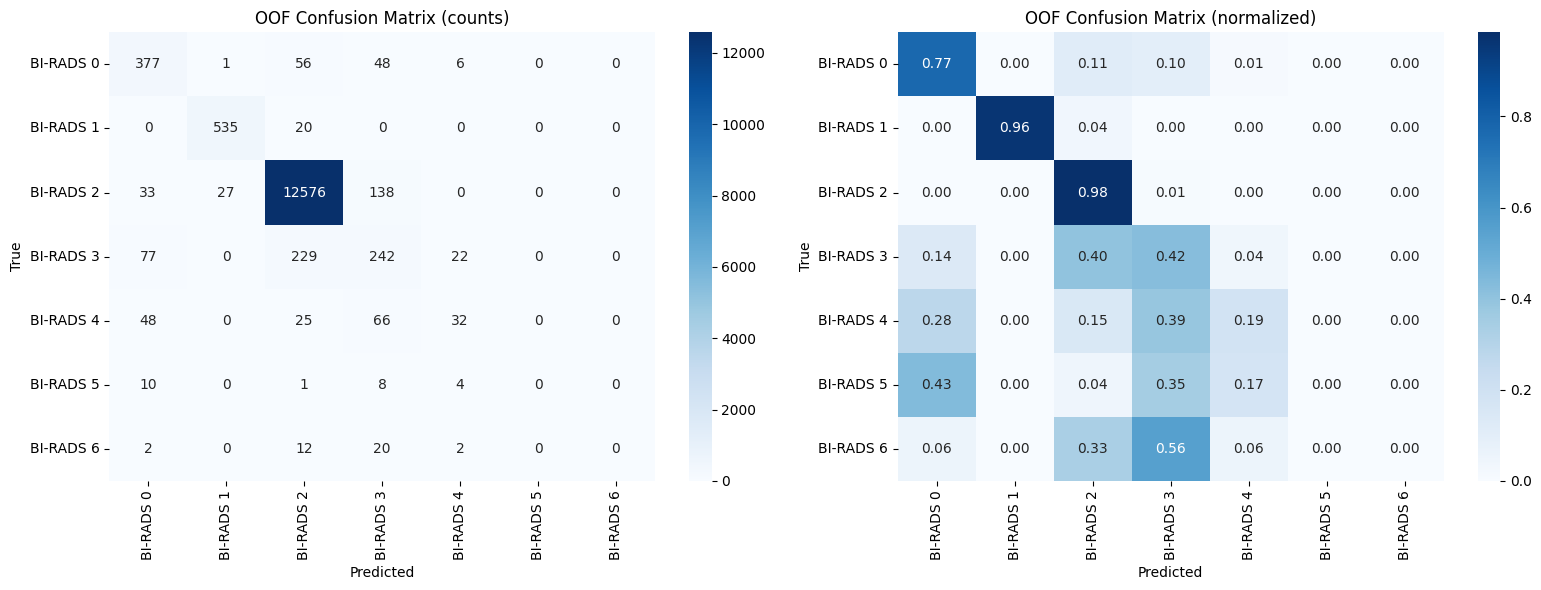

In [15]:
# Confusion matrix
cm = confusion_matrix(oof_labels, oof_pred_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm,      "OOF Confusion Matrix (counts)",     "d"),
    (axes[1], cm_norm, "OOF Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Blues", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

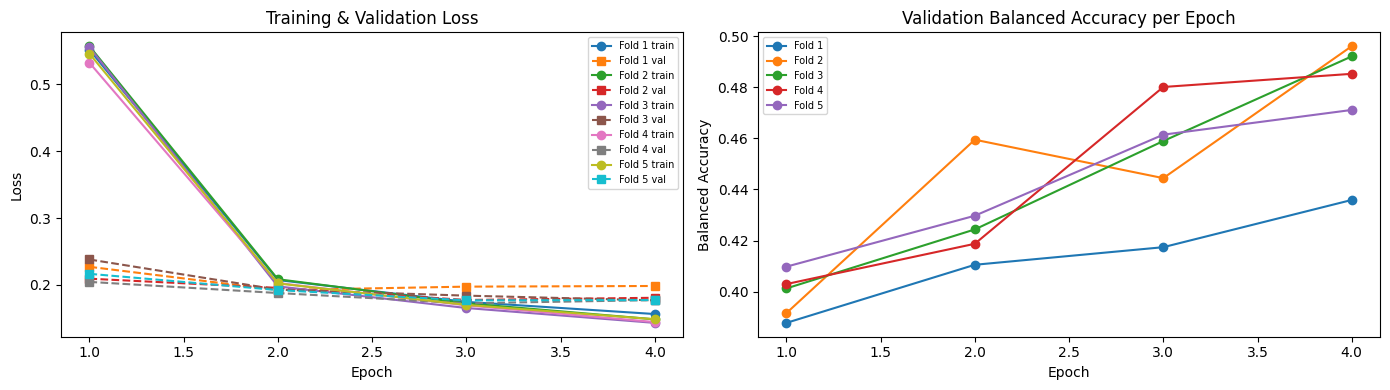

In [16]:
# Training curves
hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for fold_id in range(1, N_FOLDS+1):
    fd = hist_df[hist_df["fold"] == fold_id]
    axes[0].plot(fd["epoch"], fd["train_loss"], marker="o", label=f"Fold {fold_id} train")
    axes[0].plot(fd["epoch"], fd["val_loss"],   marker="s", linestyle="--", label=f"Fold {fold_id} val")
    axes[1].plot(fd["epoch"], fd["val_bal_acc"], marker="o", label=f"Fold {fold_id}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend(fontsize=7)

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_title("Validation Balanced Accuracy per Epoch")
axes[1].legend(fontsize=7)

plt.tight_layout()
plt.show()

## 10. Inference & Evaluation on Held-Out Test Set

Ensemble all fold models by averaging their softmax probabilities, then evaluate
against the ground-truth labels in `test_df`.

In [17]:
test_texts  = test_df["report"].tolist()
test_labels = test_df["target"].tolist()

test_ds     = MammographyDataset(test_texts, labels=test_labels, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

test_preds = np.zeros((len(test_df), NUM_CLASSES))

for fold in range(N_FOLDS):
    model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    if not os.path.exists(model_path):
        print(f"Skipping fold {fold+1} — model not found")
        continue

    print(f"Fold {fold+1}: loading {model_path}")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Fold {fold+1} inference", leave=False):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            fold_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    test_preds += np.concatenate(fold_probs, axis=0)
    del model
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

# Average over folds
test_preds /= N_FOLDS
test_pred_classes = test_preds.argmax(axis=1)


Fold 1: loading ./outputs_distilbert/best_fold1.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 33288.13it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 985.04it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 484.78it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 405.56it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 349.23it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 261.18it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 299.21it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 255.73it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 285.84it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 248.02it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 240.09it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 224.14it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 234.82it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 213.98it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 221.13it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 209.53it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 215.29it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 206.22it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 223.62it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 220.06it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 239.03it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 236.58it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 254.80it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 251.74it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 253.95it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 250.22it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 265.43it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 262.95it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 278.37it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 275.84it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 290.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 287.97it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 302.58it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 300.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 306.31it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 303.72it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 315.59it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 313.00it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 324.57it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 320.94it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 334.06it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 331.48it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 343.94it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 341.27it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 353.61it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 350.96it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 363.10it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 356.77it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 368.54it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 366.10it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 377.44it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 374.88it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 386.26it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 383.73it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 394.72it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 391.69it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 402.39it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 399.83it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 396.96it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 394.63it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 404.48it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 401.83it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 411.59it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 408.86it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 418.40it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 415.83it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 425.26it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 422.53it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 431.78it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 420.35it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 429.26it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 426.93it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 435.73it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 433.24it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 441.90it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 439.38it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 448.06it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 445.36it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 445.52it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 443.15it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 449.66it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 445.79it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 453.69it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 451.45it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 456.51it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 454.19it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 461.68it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 459.20it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 466.95it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 464.62it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 472.09it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 469.95it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 477.14it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 474.69it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 481.90it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 479.81it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 49/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 486.80it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 486.80it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 486.80it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 486.80it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 486.80it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 575.02it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 1 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 1 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:37,  1.17it/s]

Fold 1 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:35,  1.18it/s]

Fold 1 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:35,  1.18it/s]

Fold 1 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:34,  1.17it/s]

Fold 1 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:34,  1.16it/s]

Fold 1 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:33,  1.17it/s]

Fold 1 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:05<01:32,  1.17it/s]

Fold 1 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:31,  1.17it/s]

Fold 1 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:31,  1.16it/s]

Fold 1 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:30,  1.17it/s]

Fold 1 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:29,  1.17it/s]

Fold 1 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:28,  1.17it/s]

Fold 1 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:27,  1.17it/s]

Fold 1 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:11<01:26,  1.17it/s]

Fold 1 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:12<01:25,  1.17it/s]

Fold 1 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:13<01:24,  1.17it/s]

Fold 1 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:14<01:24,  1.17it/s]

Fold 1 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:15<01:23,  1.16it/s]

Fold 1 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:16<01:22,  1.16it/s]

Fold 1 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:17<01:22,  1.16it/s]

Fold 1 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:18<01:21,  1.16it/s]

Fold 1 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:18<01:20,  1.16it/s]

Fold 1 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:19<01:19,  1.16it/s]

Fold 1 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:20<01:18,  1.16it/s]

Fold 1 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:21<01:17,  1.16it/s]

Fold 1 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:22<01:16,  1.16it/s]

Fold 1 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:23<01:16,  1.16it/s]

Fold 1 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:24<01:15,  1.16it/s]

Fold 1 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:24<01:14,  1.16it/s]

Fold 1 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:25<01:13,  1.16it/s]

Fold 1 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:58,  1.41s/it]

Fold 1 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:43,  1.25s/it]

Fold 1 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:33,  1.14s/it]

Fold 1 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:25,  1.06s/it]

Fold 1 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:20,  1.01s/it]

Fold 1 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:16,  1.03it/s]

Fold 1 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:13,  1.06it/s]

Fold 1 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:11,  1.08it/s]

Fold 1 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:09,  1.09it/s]

Fold 1 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:08,  1.10it/s]

Fold 1 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:06,  1.11it/s]

Fold 1 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:05,  1.12it/s]

Fold 1 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:39<01:03,  1.13it/s]

Fold 1 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:02,  1.13it/s]

Fold 1 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:01,  1.14it/s]

Fold 1 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<01:00,  1.14it/s]

Fold 1 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<00:59,  1.15it/s]

Fold 1 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:58,  1.15it/s]

Fold 1 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:57,  1.15it/s]

Fold 1 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:56,  1.15it/s]

Fold 1 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:46<00:55,  1.15it/s]

Fold 1 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:46<00:54,  1.15it/s]

Fold 1 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:47<00:53,  1.15it/s]

Fold 1 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:48<00:52,  1.15it/s]

Fold 1 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:49<00:52,  1.15it/s]

Fold 1 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:50<00:51,  1.15it/s]

Fold 1 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:51<00:50,  1.15it/s]

Fold 1 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:52<00:49,  1.15it/s]

Fold 1 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:52<00:48,  1.15it/s]

Fold 1 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:53<00:47,  1.15it/s]

Fold 1 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:54<00:46,  1.15it/s]

Fold 1 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:55<00:45,  1.15it/s]

Fold 1 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:56<00:45,  1.15it/s]

Fold 1 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:57<00:44,  1.15it/s]

Fold 1 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:58<00:43,  1.15it/s]

Fold 1 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [00:59<00:42,  1.15it/s]

Fold 1 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [00:59<00:41,  1.15it/s]

Fold 1 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<01:01,  1.32s/it]

Fold 1 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:54,  1.18s/it]

Fold 1 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:03<00:48,  1.09s/it]

Fold 1 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:44,  1.02s/it]

Fold 1 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:41,  1.03it/s]

Fold 1 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:39,  1.06it/s]

Fold 1 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:37,  1.09it/s]

Fold 1 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:36,  1.10it/s]

Fold 1 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:35,  1.11it/s]

Fold 1 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:33,  1.12it/s]

Fold 1 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:10<00:32,  1.13it/s]

Fold 1 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:31,  1.14it/s]

Fold 1 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.14it/s]

Fold 1 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:29,  1.14it/s]

Fold 1 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:28,  1.15it/s]

Fold 1 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:27,  1.15it/s]

Fold 1 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:26,  1.15it/s]

Fold 1 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:26,  1.15it/s]

Fold 1 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:17<00:25,  1.16it/s]

Fold 1 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.15it/s]

Fold 1 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.15it/s]

Fold 1 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:20<00:22,  1.14it/s]

Fold 1 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:21<00:21,  1.15it/s]

Fold 1 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:22<00:20,  1.15it/s]

Fold 1 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:23<00:19,  1.16it/s]

Fold 1 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:23<00:19,  1.15it/s]

Fold 1 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:24<00:18,  1.15it/s]

Fold 1 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:25<00:17,  1.15it/s]

Fold 1 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:26<00:16,  1.15it/s]

Fold 1 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:27<00:15,  1.15it/s]

Fold 1 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:28<00:14,  1.16it/s]

Fold 1 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:29<00:13,  1.16it/s]

Fold 1 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:30<00:12,  1.16it/s]

Fold 1 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:30<00:12,  1.16it/s]

Fold 1 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:31<00:11,  1.15it/s]

Fold 1 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:32<00:10,  1.15it/s]

Fold 1 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:33<00:09,  1.15it/s]

Fold 1 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:13,  1.38s/it]

Fold 1 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:11,  1.22s/it]

Fold 1 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:08,  1.12s/it]

Fold 1 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:07,  1.04s/it]

Fold 1 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.01it/s]

Fold 1 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.05it/s]

Fold 1 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.08it/s]

Fold 1 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.10it/s]

Fold 1 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:42<00:01,  1.12it/s]

Fold 1 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.12it/s]

Fold 1 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.47it/s]

Fold 2: loading ./outputs_distilbert/best_fold2.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 49932.19it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 622.21it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 595.65it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 385.22it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 325.25it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 282.59it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 293.56it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 260.58it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 261.30it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 252.14it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 244.53it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 220.72it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 234.85it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 221.45it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 225.33it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 218.95it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 226.05it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 220.65it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 226.66it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 223.05it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 233.10it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 230.90it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 248.47it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 246.02it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 263.54it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 261.12it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 277.64it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 274.66it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 289.90it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 284.18it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 299.76it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 283.27it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 297.83it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 295.24it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 309.52it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 307.05it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 321.03it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 318.34it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 325.85it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 323.37it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 335.96it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 332.08it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 343.43it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 341.10it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 350.16it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 347.99it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 359.75it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 356.92it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 364.52it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 361.03it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 371.43it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 369.03it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 380.05it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 377.36it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 385.50it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 382.90it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 391.39it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 388.41it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 398.56it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 396.11it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 406.18it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 403.65it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 411.51it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 404.43it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 412.89it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 410.50it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 418.51it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 415.11it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 423.13it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 419.65it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 428.67it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 426.30it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 432.74it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 429.97it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 438.17it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 435.62it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 444.05it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 441.49it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 449.92it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 447.40it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 455.52it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 453.20it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 461.00it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 458.63it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 457.27it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 454.11it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 460.89it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 458.44it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 463.64it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 461.18it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 467.04it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 464.62it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 472.00it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 469.78it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 48/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 474.43it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 474.43it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 474.43it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 474.43it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 474.43it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 569.16it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 2 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 2 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:37,  1.17it/s]

Fold 2 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:36,  1.17it/s]

Fold 2 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:36,  1.16it/s]

Fold 2 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:36,  1.15it/s]

Fold 2 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:35,  1.16it/s]

Fold 2 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:34,  1.16it/s]

Fold 2 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:33,  1.16it/s]

Fold 2 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:32,  1.16it/s]

Fold 2 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:31,  1.16it/s]

Fold 2 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:31,  1.15it/s]

Fold 2 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:30,  1.15it/s]

Fold 2 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:29,  1.15it/s]

Fold 2 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:28,  1.15it/s]

Fold 2 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:12<01:27,  1.15it/s]

Fold 2 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:12<01:26,  1.15it/s]

Fold 2 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:13<01:25,  1.15it/s]

Fold 2 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:14<01:25,  1.15it/s]

Fold 2 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:15<01:24,  1.15it/s]

Fold 2 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:16<01:23,  1.15it/s]

Fold 2 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:17<01:22,  1.15it/s]

Fold 2 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:18<01:21,  1.16it/s]

Fold 2 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:19<01:20,  1.16it/s]

Fold 2 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:19<01:19,  1.16it/s]

Fold 2 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:20<01:18,  1.16it/s]

Fold 2 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:21<01:17,  1.16it/s]

Fold 2 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<02:01,  1.37s/it]

Fold 2 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:25<01:47,  1.22s/it]

Fold 2 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:36,  1.11s/it]

Fold 2 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:29,  1.04s/it]

Fold 2 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:24,  1.01it/s]

Fold 2 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:20,  1.05it/s]

Fold 2 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:17,  1.08it/s]

Fold 2 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:14,  1.10it/s]

Fold 2 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:12,  1.11it/s]

Fold 2 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:32<01:11,  1.13it/s]

Fold 2 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:09,  1.14it/s]

Fold 2 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:08,  1.14it/s]

Fold 2 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:07,  1.14it/s]

Fold 2 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:06,  1.15it/s]

Fold 2 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:05,  1.15it/s]

Fold 2 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:04,  1.15it/s]

Fold 2 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:03,  1.15it/s]

Fold 2 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:38<01:02,  1.15it/s]

Fold 2 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:01,  1.15it/s]

Fold 2 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:00,  1.15it/s]

Fold 2 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<00:59,  1.15it/s]

Fold 2 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<00:58,  1.15it/s]

Fold 2 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:58,  1.15it/s]

Fold 2 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:57,  1.15it/s]

Fold 2 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:56,  1.15it/s]

Fold 2 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:45<00:55,  1.15it/s]

Fold 2 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:46<00:54,  1.15it/s]

Fold 2 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:47<00:53,  1.15it/s]

Fold 2 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:48<00:52,  1.16it/s]

Fold 2 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:49<00:51,  1.16it/s]

Fold 2 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:50<00:51,  1.16it/s]

Fold 2 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:51<00:50,  1.15it/s]

Fold 2 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:51<00:49,  1.15it/s]

Fold 2 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:52<00:48,  1.15it/s]

Fold 2 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:53<00:47,  1.15it/s]

Fold 2 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:54<00:46,  1.15it/s]

Fold 2 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:55<00:45,  1.15it/s]

Fold 2 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<01:11,  1.37s/it]

Fold 2 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<01:02,  1.22s/it]

Fold 2 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:55,  1.12s/it]

Fold 2 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:50,  1.04s/it]

Fold 2 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:47,  1.01it/s]

Fold 2 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:44,  1.05it/s]

Fold 2 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:42,  1.07it/s]

Fold 2 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:04<00:41,  1.10it/s]

Fold 2 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:39,  1.11it/s]

Fold 2 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:38,  1.12it/s]

Fold 2 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:37,  1.13it/s]

Fold 2 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:36,  1.14it/s]

Fold 2 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:35,  1.14it/s]

Fold 2 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:34,  1.14it/s]

Fold 2 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:33,  1.15it/s]

Fold 2 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:32,  1.15it/s]

Fold 2 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:31,  1.15it/s]

Fold 2 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.15it/s]

Fold 2 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:29,  1.15it/s]

Fold 2 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:28,  1.15it/s]

Fold 2 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:27,  1.15it/s]

Fold 2 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:26,  1.15it/s]

Fold 2 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:26,  1.15it/s]

Fold 2 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:17<00:25,  1.15it/s]

Fold 2 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.15it/s]

Fold 2 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.15it/s]

Fold 2 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:20<00:22,  1.15it/s]

Fold 2 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:21<00:21,  1.15it/s]

Fold 2 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:22<00:20,  1.15it/s]

Fold 2 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:23<00:20,  1.15it/s]

Fold 2 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:24<00:19,  1.15it/s]

Fold 2 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:24<00:18,  1.15it/s]

Fold 2 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:25<00:17,  1.15it/s]

Fold 2 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:26<00:16,  1.15it/s]

Fold 2 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:27<00:15,  1.16it/s]

Fold 2 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:28<00:14,  1.15it/s]

Fold 2 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:29<00:13,  1.15it/s]

Fold 2 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:30<00:13,  1.15it/s]

Fold 2 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:19,  1.37s/it]

Fold 2 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:15,  1.22s/it]

Fold 2 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:13,  1.12s/it]

Fold 2 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:11,  1.04s/it]

Fold 2 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:09,  1.01it/s]

Fold 2 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:37<00:08,  1.05it/s]

Fold 2 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.07it/s]

Fold 2 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.10it/s]

Fold 2 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.12it/s]

Fold 2 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.13it/s]

Fold 2 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.13it/s]

Fold 2 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.14it/s]

Fold 2 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.14it/s]

Fold 2 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.15it/s]

Fold 2 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.50it/s]

Fold 3: loading ./outputs_distilbert/best_fold3.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 54471.48it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 633.39it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 540.36it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 324.55it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 319.69it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 255.22it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 296.06it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 262.81it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 280.46it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 253.53it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 257.82it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 231.60it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 234.77it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 224.38it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 229.02it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 208.69it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 219.35it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 204.92it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 223.07it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 220.69it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 239.33it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 236.69it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 255.00it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 252.40it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 270.06it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 267.61it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 271.93it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 269.61it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 285.48it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 282.88it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 291.71it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 288.00it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 302.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 300.29it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 313.03it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 310.49it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 324.65it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 318.48it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 332.09it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 329.41it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 342.64it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 340.35it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 348.58it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 346.14it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 358.57it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 355.94it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 368.31it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 365.71it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 371.42it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 367.78it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 379.20it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 376.58it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 387.75it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 384.98it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 395.99it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 393.16it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 403.20it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 400.60it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 410.07it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 407.53it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 417.61it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 415.07it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 419.27it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 416.96it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 421.01it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 418.66it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 426.14it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 423.71it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 428.56it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 435.66it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 433.29it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 440.48it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 437.01it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 446.40it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 443.95it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 452.51it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 449.65it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 453.41it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 450.98it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 457.40it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 454.94it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 461.48it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 459.02it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 467.03it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 464.57it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 472.37it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 470.05it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 472.79it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 469.40it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 476.99it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 474.42it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 481.68it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 479.03it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 482.44it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 479.25it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 49/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 485.68it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 485.68it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 485.68it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 485.68it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 485.68it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 583.85it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 3 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 3 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:37,  1.17it/s]

Fold 3 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:36,  1.17it/s]

Fold 3 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:36,  1.17it/s]

Fold 3 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:35,  1.16it/s]

Fold 3 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:34,  1.16it/s]

Fold 3 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:33,  1.16it/s]

Fold 3 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:33,  1.16it/s]

Fold 3 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:32,  1.16it/s]

Fold 3 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:31,  1.16it/s]

Fold 3 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:30,  1.16it/s]

Fold 3 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:29,  1.16it/s]

Fold 3 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:28,  1.16it/s]

Fold 3 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:27,  1.16it/s]

Fold 3 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:12<01:27,  1.16it/s]

Fold 3 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:12<01:26,  1.16it/s]

Fold 3 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:13<01:25,  1.16it/s]

Fold 3 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:14<01:24,  1.16it/s]

Fold 3 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:15<01:23,  1.16it/s]

Fold 3 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:16<01:22,  1.16it/s]

Fold 3 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:17<01:22,  1.16it/s]

Fold 3 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:19<02:08,  1.37s/it]

Fold 3 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:53,  1.22s/it]

Fold 3 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:42,  1.12s/it]

Fold 3 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:34,  1.04s/it]

Fold 3 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:29,  1.01it/s]

Fold 3 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<01:24,  1.05it/s]

Fold 3 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:25<01:21,  1.08it/s]

Fold 3 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:18,  1.10it/s]

Fold 3 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:16,  1.12it/s]

Fold 3 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:15,  1.13it/s]

Fold 3 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:14,  1.13it/s]

Fold 3 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:13,  1.14it/s]

Fold 3 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:11,  1.14it/s]

Fold 3 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:10,  1.14it/s]

Fold 3 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:10,  1.14it/s]

Fold 3 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:09,  1.14it/s]

Fold 3 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:07,  1.15it/s]

Fold 3 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:06,  1.15it/s]

Fold 3 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:05,  1.16it/s]

Fold 3 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:05,  1.15it/s]

Fold 3 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:04,  1.15it/s]

Fold 3 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:03,  1.15it/s]

Fold 3 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:38<01:02,  1.15it/s]

Fold 3 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:01,  1.15it/s]

Fold 3 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:00,  1.15it/s]

Fold 3 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<00:59,  1.16it/s]

Fold 3 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<00:58,  1.15it/s]

Fold 3 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:58,  1.14it/s]

Fold 3 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:57,  1.15it/s]

Fold 3 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:56,  1.15it/s]

Fold 3 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:45<00:55,  1.15it/s]

Fold 3 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:46<00:54,  1.16it/s]

Fold 3 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:47<00:53,  1.15it/s]

Fold 3 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:48<00:53,  1.15it/s]

Fold 3 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:49<00:52,  1.15it/s]

Fold 3 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:50<00:51,  1.15it/s]

Fold 3 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:51<00:50,  1.15it/s]

Fold 3 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<01:18,  1.37s/it]

Fold 3 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<01:08,  1.22s/it]

Fold 3 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<01:01,  1.11s/it]

Fold 3 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:56,  1.04s/it]

Fold 3 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:57<00:52,  1.01it/s]

Fold 3 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<00:49,  1.05it/s]

Fold 3 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:47,  1.08it/s]

Fold 3 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:45,  1.10it/s]

Fold 3 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:43,  1.12it/s]

Fold 3 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:42,  1.13it/s]

Fold 3 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.14it/s]

Fold 3 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:40,  1.14it/s]

Fold 3 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:04<00:39,  1.15it/s]

Fold 3 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:38,  1.15it/s]

Fold 3 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.15it/s]

Fold 3 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:36,  1.15it/s]

Fold 3 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:35,  1.15it/s]

Fold 3 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:34,  1.15it/s]

Fold 3 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:33,  1.15it/s]

Fold 3 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:32,  1.15it/s]

Fold 3 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:10<00:32,  1.15it/s]

Fold 3 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:31,  1.15it/s]

Fold 3 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.15it/s]

Fold 3 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:29,  1.15it/s]

Fold 3 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:28,  1.15it/s]

Fold 3 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:27,  1.16it/s]

Fold 3 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:26,  1.16it/s]

Fold 3 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:25,  1.16it/s]

Fold 3 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:17<00:25,  1.16it/s]

Fold 3 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.16it/s]

Fold 3 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.16it/s]

Fold 3 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:20<00:22,  1.16it/s]

Fold 3 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:21<00:21,  1.15it/s]

Fold 3 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:22<00:20,  1.15it/s]

Fold 3 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:23<00:19,  1.15it/s]

Fold 3 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:23<00:19,  1.15it/s]

Fold 3 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:24<00:18,  1.15it/s]

Fold 3 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:25<00:17,  1.15it/s]

Fold 3 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:26,  1.38s/it]

Fold 3 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:29<00:22,  1.22s/it]

Fold 3 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:29<00:18,  1.12s/it]

Fold 3 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:16,  1.05s/it]

Fold 3 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:14,  1.01it/s]

Fold 3 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:13,  1.05it/s]

Fold 3 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:12,  1.08it/s]

Fold 3 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.10it/s]

Fold 3 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.11it/s]

Fold 3 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:08,  1.12it/s]

Fold 3 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:07,  1.13it/s]

Fold 3 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.14it/s]

Fold 3 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.14it/s]

Fold 3 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.15it/s]

Fold 3 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.14it/s]

Fold 3 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.15it/s]

Fold 3 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.15it/s]

Fold 3 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.15it/s]

Fold 3 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.15it/s]

Fold 3 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.51it/s]

Fold 4: loading ./outputs_distilbert/best_fold4.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 51150.05it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 314.04it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 410.84it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 291.90it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 289.66it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 219.74it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 256.53it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 231.77it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 237.32it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 216.04it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 223.21it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 210.38it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 218.65it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 203.99it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 217.71it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 204.68it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 223.93it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 221.16it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 242.28it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 239.14it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 241.40it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 237.92it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 256.33it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 253.79it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 269.40it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 266.85it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 284.06it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 281.44it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 297.84it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 294.92it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 304.64it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 300.72it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 316.09it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 313.10it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 327.69it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 324.78it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 339.13it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 336.22it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 350.18it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 347.33it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 352.03it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 347.89it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 359.69it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 355.72it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 367.10it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 362.99it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 374.04it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 369.83it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 380.88it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 376.65it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 387.24it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 383.39it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 394.67it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 391.85it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 402.92it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 400.14it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 410.41it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 407.51it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 418.32it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 415.58it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 418.64it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 415.84it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 425.74it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 422.89it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 432.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 430.16it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 440.09it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 437.48it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 446.64it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 443.65it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 452.50it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 449.48it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 458.46it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 455.61it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 464.83it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 462.20it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 456.05it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 453.64it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 462.03it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 459.35it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 467.72it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 465.39it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 472.55it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 470.13it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 478.11it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 475.31it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 476.49it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 474.26it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 480.53it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 478.15it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 485.67it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 483.31it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 490.93it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 488.48it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 489.58it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 486.97it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 492.85it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 490.66it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 50/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 497.74it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 497.74it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 497.74it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 497.74it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 497.74it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 582.94it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 4 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 4 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:50,  1.03it/s]

Fold 4 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:41,  1.11it/s]

Fold 4 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:38,  1.14it/s]

Fold 4 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:36,  1.15it/s]

Fold 4 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:34,  1.16it/s]

Fold 4 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:33,  1.16it/s]

Fold 4 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:33,  1.16it/s]

Fold 4 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:32,  1.16it/s]

Fold 4 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:31,  1.16it/s]

Fold 4 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:31,  1.15it/s]

Fold 4 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:30,  1.15it/s]

Fold 4 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:29,  1.16it/s]

Fold 4 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:28,  1.16it/s]

Fold 4 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:12<01:27,  1.16it/s]

Fold 4 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:14<02:19,  1.39s/it]

Fold 4 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:15<02:02,  1.23s/it]

Fold 4 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:16<01:50,  1.13s/it]

Fold 4 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:17<01:41,  1.05s/it]

Fold 4 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:18<01:35,  1.00it/s]

Fold 4 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:19<01:31,  1.04it/s]

Fold 4 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:20<01:28,  1.07it/s]

Fold 4 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:25,  1.09it/s]

Fold 4 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:23,  1.10it/s]

Fold 4 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:21,  1.11it/s]

Fold 4 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:20,  1.12it/s]

Fold 4 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<01:17,  1.14it/s]

Fold 4 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:25<01:16,  1.15it/s]

Fold 4 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:26<01:14,  1.16it/s]

Fold 4 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:13,  1.17it/s]

Fold 4 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:11,  1.18it/s]

Fold 4 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:10,  1.19it/s]

Fold 4 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:10,  1.18it/s]

Fold 4 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:10,  1.17it/s]

Fold 4 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:09,  1.16it/s]

Fold 4 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:32<01:08,  1.16it/s]

Fold 4 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:08,  1.16it/s]

Fold 4 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:07,  1.16it/s]

Fold 4 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:06,  1.16it/s]

Fold 4 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:05,  1.16it/s]

Fold 4 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:04,  1.16it/s]

Fold 4 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:04,  1.15it/s]

Fold 4 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:03,  1.15it/s]

Fold 4 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:38<01:02,  1.15it/s]

Fold 4 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:01,  1.15it/s]

Fold 4 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:00,  1.15it/s]

Fold 4 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<00:59,  1.15it/s]

Fold 4 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<00:59,  1.15it/s]

Fold 4 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:58,  1.15it/s]

Fold 4 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:57,  1.15it/s]

Fold 4 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:56,  1.15it/s]

Fold 4 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:45<00:55,  1.15it/s]

Fold 4 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:48<01:27,  1.39s/it]

Fold 4 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:49<01:16,  1.23s/it]

Fold 4 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:50<01:08,  1.13s/it]

Fold 4 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:51<01:03,  1.06s/it]

Fold 4 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:52<00:59,  1.01s/it]

Fold 4 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:56,  1.03it/s]

Fold 4 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:54,  1.05it/s]

Fold 4 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:52,  1.07it/s]

Fold 4 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:50,  1.09it/s]

Fold 4 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:48,  1.11it/s]

Fold 4 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:57<00:47,  1.12it/s]

Fold 4 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:58<00:46,  1.12it/s]

Fold 4 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:59<00:45,  1.13it/s]

Fold 4 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:43,  1.14it/s]

Fold 4 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:42,  1.14it/s]

Fold 4 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:41,  1.14it/s]

Fold 4 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.14it/s]

Fold 4 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:40,  1.15it/s]

Fold 4 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:04<00:39,  1.15it/s]

Fold 4 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:05<00:38,  1.16it/s]

Fold 4 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:06<00:37,  1.16it/s]

Fold 4 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:36,  1.16it/s]

Fold 4 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:35,  1.17it/s]

Fold 4 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:34,  1.18it/s]

Fold 4 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:33,  1.17it/s]

Fold 4 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:32,  1.17it/s]

Fold 4 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:31,  1.17it/s]

Fold 4 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:12<00:30,  1.17it/s]

Fold 4 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.16it/s]

Fold 4 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:29,  1.16it/s]

Fold 4 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:28,  1.15it/s]

Fold 4 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:27,  1.16it/s]

Fold 4 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:26,  1.15it/s]

Fold 4 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:26,  1.15it/s]

Fold 4 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:18<00:25,  1.15it/s]

Fold 4 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.15it/s]

Fold 4 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.15it/s]

Fold 4 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:22<00:35,  1.37s/it]

Fold 4 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:23<00:30,  1.22s/it]

Fold 4 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:24<00:26,  1.12s/it]

Fold 4 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:25<00:24,  1.06s/it]

Fold 4 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:22,  1.01s/it]

Fold 4 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:20,  1.03it/s]

Fold 4 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:18,  1.05it/s]

Fold 4 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:17,  1.07it/s]

Fold 4 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:29<00:16,  1.10it/s]

Fold 4 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:30<00:15,  1.12it/s]

Fold 4 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:31<00:14,  1.13it/s]

Fold 4 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:32<00:13,  1.13it/s]

Fold 4 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:12,  1.14it/s]

Fold 4 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.14it/s]

Fold 4 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.15it/s]

Fold 4 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.15it/s]

Fold 4 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:08,  1.16it/s]

Fold 4 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:37<00:07,  1.16it/s]

Fold 4 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:38<00:06,  1.16it/s]

Fold 4 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.16it/s]

Fold 4 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.16it/s]

Fold 4 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.16it/s]

Fold 4 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.17it/s]

Fold 4 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.18it/s]

Fold 4 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.18it/s]

Fold 4 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:44<00:00,  1.17it/s]

Fold 4 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.53it/s]

Fold 5: loading ./outputs_distilbert/best_fold5.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 55924.05it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 628.36it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 399.80it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 300.17it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 324.58it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 229.22it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 257.17it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 231.06it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 240.58it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 216.20it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 225.70it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 205.05it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 218.47it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 204.91it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 218.21it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 208.44it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 215.35it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 203.99it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 220.62it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 218.34it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 236.77it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 234.29it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 252.36it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 249.73it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 267.56it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 265.18it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 282.27it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 279.59it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 294.04it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 291.46it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 306.94it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 303.97it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 307.62it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 304.24it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 300.70it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 297.18it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 309.72it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 306.41it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 318.43it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 315.10it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 326.87it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 323.29it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 334.49it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 330.75it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 341.91it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 338.46it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 349.30it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 345.85it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 356.29it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 353.94it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 363.26it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 360.64it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 371.25it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 368.88it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 379.52it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 376.94it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 387.41it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 384.94it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 395.34it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 392.96it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 402.94it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 400.44it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 410.35it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 407.87it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 405.90it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 402.50it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 410.79it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 408.61it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 417.67it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 415.00it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 424.12it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 421.61it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 430.46it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 428.10it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 436.69it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 434.33it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 442.70it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 440.32it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 448.55it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 446.19it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 453.77it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 451.81it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 459.82it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 457.49it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 465.13it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 462.80it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 470.31it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 468.07it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 475.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 472.92it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 480.64it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 477.84it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 485.18it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 482.67it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 48/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 467.44it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 467.44it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 467.44it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 467.44it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 467.44it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 565.93it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 5 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 5 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:37,  1.17it/s]

Fold 5 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:36,  1.17it/s]

Fold 5 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:36,  1.16it/s]

Fold 5 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:35,  1.16it/s]

Fold 5 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:34,  1.16it/s]

Fold 5 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:34,  1.16it/s]

Fold 5 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:33,  1.16it/s]

Fold 5 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:32,  1.16it/s]

Fold 5 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:32,  1.15it/s]

Fold 5 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:10<02:26,  1.39s/it]

Fold 5 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:11<02:08,  1.24s/it]

Fold 5 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:12<01:57,  1.14s/it]

Fold 5 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:13<01:48,  1.06s/it]

Fold 5 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:13<01:42,  1.01s/it]

Fold 5 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:14<01:37,  1.02it/s]

Fold 5 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:15<01:34,  1.05it/s]

Fold 5 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:16<01:30,  1.08it/s]

Fold 5 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:17<01:28,  1.09it/s]

Fold 5 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:18<01:26,  1.11it/s]

Fold 5 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:19<01:24,  1.12it/s]

Fold 5 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:20<01:22,  1.14it/s]

Fold 5 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:20,  1.15it/s]

Fold 5 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:19,  1.16it/s]

Fold 5 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:18,  1.16it/s]

Fold 5 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:17,  1.16it/s]

Fold 5 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<01:16,  1.16it/s]

Fold 5 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:25<01:15,  1.17it/s]

Fold 5 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:26<01:14,  1.17it/s]

Fold 5 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:13,  1.16it/s]

Fold 5 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:13,  1.16it/s]

Fold 5 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:12,  1.16it/s]

Fold 5 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:11,  1.16it/s]

Fold 5 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:10,  1.16it/s]

Fold 5 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:10,  1.16it/s]

Fold 5 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:32<01:09,  1.16it/s]

Fold 5 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:08,  1.16it/s]

Fold 5 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:07,  1.16it/s]

Fold 5 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:06,  1.15it/s]

Fold 5 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:05,  1.15it/s]

Fold 5 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:04,  1.15it/s]

Fold 5 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:04,  1.15it/s]

Fold 5 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:03,  1.16it/s]

Fold 5 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:39<01:02,  1.15it/s]

Fold 5 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:01,  1.15it/s]

Fold 5 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:00,  1.15it/s]

Fold 5 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<00:59,  1.15it/s]

Fold 5 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:44<01:31,  1.35s/it]

Fold 5 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:44<01:21,  1.21s/it]

Fold 5 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:45<01:13,  1.12s/it]

Fold 5 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:46<01:08,  1.05s/it]

Fold 5 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:47<01:04,  1.00s/it]

Fold 5 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:48<01:01,  1.03it/s]

Fold 5 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:49<00:58,  1.06it/s]

Fold 5 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:50<00:56,  1.08it/s]

Fold 5 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:51<00:54,  1.10it/s]

Fold 5 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:52<00:52,  1.12it/s]

Fold 5 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:51,  1.13it/s]

Fold 5 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:50,  1.14it/s]

Fold 5 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:48,  1.15it/s]

Fold 5 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:47,  1.15it/s]

Fold 5 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:46,  1.16it/s]

Fold 5 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:57<00:45,  1.16it/s]

Fold 5 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:58<00:44,  1.16it/s]

Fold 5 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:43,  1.16it/s]

Fold 5 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:42,  1.16it/s]

Fold 5 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:42,  1.16it/s]

Fold 5 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:41,  1.15it/s]

Fold 5 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:40,  1.15it/s]

Fold 5 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:39,  1.16it/s]

Fold 5 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:04<00:38,  1.15it/s]

Fold 5 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:05<00:38,  1.15it/s]

Fold 5 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.15it/s]

Fold 5 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:36,  1.15it/s]

Fold 5 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:35,  1.15it/s]

Fold 5 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:34,  1.15it/s]

Fold 5 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:33,  1.16it/s]

Fold 5 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:32,  1.16it/s]

Fold 5 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:32,  1.16it/s]

Fold 5 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:31,  1.15it/s]

Fold 5 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.15it/s]

Fold 5 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:29,  1.15it/s]

Fold 5 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:28,  1.15it/s]

Fold 5 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:27,  1.15it/s]

Fold 5 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:17<00:42,  1.36s/it]

Fold 5 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:18<00:36,  1.22s/it]

Fold 5 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:19<00:32,  1.12s/it]

Fold 5 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:20<00:29,  1.06s/it]

Fold 5 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:21<00:27,  1.01s/it]

Fold 5 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:22<00:25,  1.02it/s]

Fold 5 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:23<00:23,  1.06it/s]

Fold 5 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:24<00:22,  1.09it/s]

Fold 5 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:25<00:20,  1.10it/s]

Fold 5 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:19,  1.12it/s]

Fold 5 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:18,  1.14it/s]

Fold 5 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:17,  1.15it/s]

Fold 5 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:16,  1.16it/s]

Fold 5 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:29<00:15,  1.17it/s]

Fold 5 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:30<00:14,  1.18it/s]

Fold 5 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:13,  1.18it/s]

Fold 5 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:12,  1.18it/s]

Fold 5 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:11,  1.18it/s]

Fold 5 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.18it/s]

Fold 5 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.18it/s]

Fold 5 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.18it/s]

Fold 5 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:08,  1.18it/s]

Fold 5 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:07,  1.17it/s]

Fold 5 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:06,  1.17it/s]

Fold 5 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:05,  1.17it/s]

Fold 5 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.17it/s]

Fold 5 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.17it/s]

Fold 5 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.17it/s]

Fold 5 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.16it/s]

Fold 5 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:42<00:01,  1.15it/s]

Fold 5 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.15it/s]

Fold 5 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.50it/s]

In [18]:
# ── Test set evaluation metrics ───────────────────────────────────────────────
test_true = np.array(test_labels)

print("Test Set Classification Report:")
print(classification_report(
    test_true, test_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

test_bal_acc = balanced_accuracy_score(test_true, test_pred_classes)
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"\nSummary:")
print(f"  OOF  Balanced Accuracy: {balanced_accuracy_score(oof_labels, oof_pred_classes):.4f}")
print(f"  Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Set Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.74      0.76      0.75       122
   BI-RADS 1       0.94      0.95      0.94       138
   BI-RADS 2       0.97      0.99      0.98      3194
   BI-RADS 3       0.43      0.35      0.39       143
   BI-RADS 4       0.72      0.30      0.43        43
   BI-RADS 5       0.00      0.00      0.00         6
   BI-RADS 6       0.00      0.00      0.00         9

    accuracy                           0.94      3655
   macro avg       0.54      0.48      0.50      3655
weighted avg       0.93      0.94      0.93      3655

Test Balanced Accuracy: 0.4786

Summary:
  OOF  Balanced Accuracy: 0.4761
  Test Balanced Accuracy: 0.4786


/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

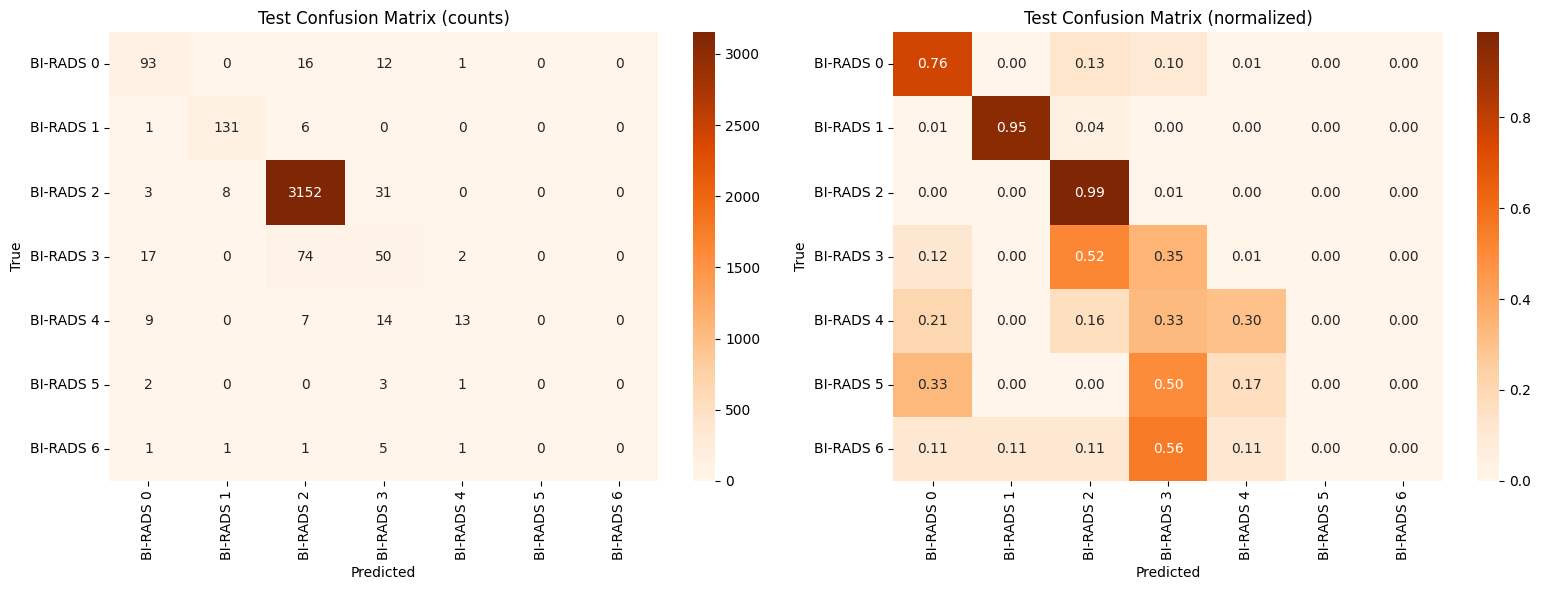

In [19]:
# ── Test confusion matrix ─────────────────────────────────────────────────────
cm_test      = confusion_matrix(test_true, test_pred_classes)
cm_test_norm = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm_test,      "Test Confusion Matrix (counts)",     "d"),
    (axes[1], cm_test_norm, "Test Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Oranges", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 11. Save Predictions

In [20]:
# ── Test predictions with ground truth ────────────────────────────────────────
test_results = test_df[["ID", "target"]].copy()
test_results["predicted"] = test_pred_classes
test_results["correct"]   = test_results["target"] == test_results["predicted"]
for i in range(NUM_CLASSES):
    test_results[f"prob_class_{i}"] = test_preds[:, i]

test_results.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
print(f"Test predictions saved to {OUTPUT_DIR}/test_predictions.csv")
print(f"Overall accuracy: {test_results['correct'].mean()*100:.2f}%")
test_results.head(10)

Test predictions saved to ./outputs_distilbert/test_predictions.csv
Overall accuracy: 94.09%


ID  target  predicted  correct  prob_class_0  prob_class_1  \
0   Acc8052       2          2     True      0.000167      0.000260   
1  Acc13753       2          2     True      0.000196      0.000285   
2   Acc4514       2          2     True      0.000181      0.000263   
3  Acc12396       2          2     True      0.000165      0.000255   
4  Acc22659       2          2     True      0.001128      0.464387   
5  Acc22473       2          2     True      0.000168      0.000272   
6  Acc11889       2          2     True      0.000169      0.000268   
7   Acc4700       0          0     True      0.611614      0.001603   
8  Acc10650       2          2     True      0.000165      0.000275   
9  Acc16931       2          2     True      0.340988      0.000948   

   prob_class_2  prob_class_3  prob_class_4  prob_class_5  prob_class_6  
0      0.998907      0.000332      0.000113      0.000091      0.000129  
1      0.998851      0.000323      0.000119      0.000096      0.000131  
2      0.998889      0.000341      0.000111      0.000090      0.000125  
3      0.998918      0.000336      0.000110      0.000089      0.000128  
4      0.529955      0.001427      0.000835      0.000978      0.001290  
5      0.998909      0.000323      0.000110      0.000091      0.000128  
6      0.998913      0.000325      0.000109      0.000090      0.000126  
7      0.213455      0.130192      0.029612      0.007214      0.006310  
8      0.998907      0.000322      0.000112      0.000091      0.000129  
9      0.519770      0.099934      0.027827      0.005573      0.004959

In [21]:
# ── OOF predictions for stacking / further analysis ───────────────────────────
oof_df = pd.DataFrame(
    oof_preds,
    columns=[f"prob_class_{i}" for i in range(NUM_CLASSES)]
)
oof_df.insert(0, "ID",        train_df["ID"].values)
oof_df.insert(1, "target",    train_df["target"].values)
oof_df.insert(2, "predicted", oof_pred_classes)
oof_df.to_csv(f"{OUTPUT_DIR}/oof_predictions.csv", index=False)
print("OOF predictions saved.")

OOF predictions saved.
